In [1]:
import itertools
import sys, os

import numpy as np
import pandas as pd
from scipy.special import comb
from scipy import stats
import scipy.cluster.hierarchy as hac
import matplotlib.pyplot as plt
plt.style.use('classic')
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn import metrics

sns.set(rc={'figure.figsize':(15,8)})
sns.set_context('poster')
from sklearn.model_selection import train_test_split

In [2]:
%load_ext autoreload
%autoreload 2
import CCPA_lib as cp


In [3]:
sns.set_context('poster')
sns.set_style('white')

In [4]:
ppallete = 'RdYlGn'#'YlGn_d' #"BuGn_d"
porder = ['MED4',  'MIT9312','MIT0604', 'Natl2A', 'MIT9313']
ppallete = [ '#62A586', '#face6e','#f79934', '#7A9BC8', '#F47681', ]
# #ffd7a1
    
pedge = 'green'
apallete = "spring"
aorder = ['DE', 'DE1', '1A3', 'ATCC', 'BS11']
amarkers = ['X', 'P', 's', 'D', 'o']
aedge='orange'
epallete = ['#6cf0ba', '#d13f75', '#eeb7cb', '#b9d2d8', '#407f90']
#sns.diverging_palette(355, 217, s=74, l=50, n=4) #'Paired' # 'BrBG'# "coolwarm"
eorder = ['e1','e3', 'e4', 'e5', 'e6']
#aedge='orange'

espallete = ['#6cf0ba', '#D55282', '#538B9B']
#  604 #FCC479
#     #ffd7a1
#     #fcb14c
#     MED4 = #62A586
#     9313 #F47681
#     natl #7A9BC8

In [5]:
df = pd.read_pickle('CCPA.pkl.gz')
df.loc[df.PRO == 'C9B', 'PRO'] = 'MIT0604'

In [6]:
dfw = df.loc[(df.experiment.isin(['e1', 'e3', 'e4','e5', 'e6']))]

In [7]:
#dfw = df.loc[(df.experiment.isin(['e1','e3', 'e4','e5', 'e6'])) # & (df.culture == 'Co_Culture')
#            ]

In [8]:
dfdecline = cp.generate_decline(dfw, scale=False)
#dfdecline = dfdecline.loc[dfdecline['day'] <= 80]

In [9]:
dfdecline.head()

experiment_sample       day     FL experiment sample      PRO ALT  \
0           e1, 10A  0.000000  5.621         e1    10A  MIT0604  DE   
1           e1, 10A  0.893056  4.045         e1    10A  MIT0604  DE   
2           e1, 10A  1.991667  2.749         e1    10A  MIT0604  DE   
3           e1, 10A  4.697222  2.924         e1    10A  MIT0604  DE   
4           e1, 10A  5.700000  2.519         e1    10A  MIT0604  DE   

      culture  
0  Co_Culture  
1  Co_Culture  
2  Co_Culture  
3  Co_Culture  
4  Co_Culture

In [45]:
dfdecline.FL = dfdecline.FL + 1

In [46]:
for n, f in [
    ('exponential', cp.model_exponential1),
    #('hyperbolic', cp.model_hyperbolic),
    ('harmonic', cp.model_harmonic),
]:
    #f = cp.model_exponential
    t = dfdecline.groupby('experiment_sample').apply(lambda x: cp.apply_fit1(x, f, print_popt=False))
    dfdecline[n] = t['y_pred']
    for i in range(3):
        dfdecline[f'{n}_popt_{i}'] = t[f'popt_{i}']
#dfdecline['decline'] = dfdecline.FL
#dfdecline['exponential_diff'] = dfdecline.FL - dfdecline.exponential
#dfdecline['decline_scaled'] = dfdecline.groupby('experiment_sample').FL.transform(lambda x: x / x.max())
#df_exp_coef = dfdecline.groupby(['experiment_sample','popt_0', 'popt_1', 'popt_2'])['decline'].count().reset_index(level=[1,2,3])\
#.drop(columns='decline')

In [47]:
dfdecline.columns

Index(['experiment_sample', 'day', 'FL', 'experiment', 'sample', 'PRO', 'ALT',
       'culture', 'exponential', 'exponential_popt_0', 'exponential_popt_1',
       'exponential_popt_2', 'harmonic', 'harmonic_popt_0', 'harmonic_popt_1',
       'harmonic_popt_2'],
      dtype='object')

In [48]:
dfdecline.head()

experiment_sample       day     FL experiment sample      PRO ALT  \
0           e1, 10A  0.000000  6.621         e1    10A  MIT0604  DE   
1           e1, 10A  0.893056  5.045         e1    10A  MIT0604  DE   
2           e1, 10A  1.991667  3.749         e1    10A  MIT0604  DE   
3           e1, 10A  4.697222  3.924         e1    10A  MIT0604  DE   
4           e1, 10A  5.700000  3.519         e1    10A  MIT0604  DE   

      culture  exponential  exponential_popt_0  exponential_popt_1  \
0  Co_Culture     6.621000            0.030385                 1.0   
1  Co_Culture     6.443751            0.030385                 1.0   
2  Co_Culture     6.232200            0.030385                 1.0   
3  Co_Culture     5.740352            0.030385                 1.0   
4  Co_Culture     5.568084            0.030385                 1.0   

   exponential_popt_2  harmonic  harmonic_popt_0  harmonic_popt_1  \
0                 1.0  6.621000         0.074455              0.5   
1                 1.0  6.208201         0.074455              0.5   
2                 1.0  5.765966         0.074455              0.5   
3                 1.0  4.905417         0.074455              0.5   
4                 1.0  4.648291         0.074455              0.5   

   harmonic_popt_2  
0              0.5  
1              0.5  
2              0.5  
3              0.5  
4              0.5

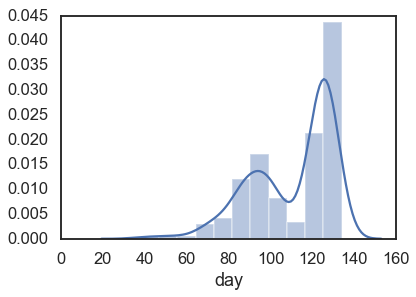

In [49]:
sns.distplot(dfdecline.groupby('experiment_sample')['day'].max()) #.sort_values()

In [50]:
def _compute_score_model(x,m):
    res = {f'{m}_popt_{i}' : x[f'{m}_popt_{i}'].unique()[0] for i in range(3)}
    if np.isnan(res[f'{m}_popt_0']):
        res.update({
            f'rmse_{m}' : np.NaN,
            f'rmse_{m}_60' : np.NaN,
            f'rmse_{m}_5' : np.NaN,
            f'bic_{m}' : np.NaN,
        })
    else:
        x60 = x.loc[x.day >= 60]
        x5 = x.loc[x.day <= 5]
        n = x.shape[0]
        num_params = 3 if m == 'hyperbolic' else 2
        res.update({
            f'rmse_{m}' : np.sqrt(metrics.mean_squared_error(x['FL'], x[m])),
            f'rmse_{m}_60' : np.sqrt(metrics.mean_squared_error(x60['FL'], x60[m])) if x60.shape[0]>2 else np.NaN,
            f'rmse_{m}_5' : np.sqrt(metrics.mean_squared_error(x5['FL'], x5[m])),
            f'bic_{m}' : n * np.log(metrics.mean_squared_error(x['FL'], x[m])) + num_params * np.log(n),
        })
    return res

def _compute_r2(x):
    models = ['exponential', #'hyperbolic',
              'harmonic', ]
    res_list = [_compute_score_model(x,m) for m in models]
    res =dict()
    for i in res_list:
        res.update(i)
    return pd.Series(res)
groupcols = ['experiment_sample', 'experiment', 'sample', 'PRO', 'ALT', 'culture', ]
dfscore = dfdecline.groupby(groupcols).apply(_compute_r2).reset_index()

In [51]:
dfscorem = dfscore.melt(id_vars=['experiment_sample', 'experiment', 'sample', 'PRO', 'ALT', 'culture'],
                        value_vars=['rmse_exponential', #'rmse_hyperbolic', 
                                    'rmse_harmonic', 
                                    'rmse_exponential_60', #'rmse_hyperbolic_60', 
                                    'rmse_harmonic_60',
                                    'rmse_exponential_5', #'rmse_hyperbolic_5',
                                    'rmse_harmonic_5',
                                    'bic_exponential', #'bic_hyperbolic', 
                                    'bic_harmonic'
                                    
                                   ], 
                        value_name='RMSE',
                        var_name='model')


In [52]:
dfscorem['s'] = dfscorem['sample'] +', '+ dfscorem.ALT
dfscorem['e'] = dfscorem['experiment'] +', '+ dfscorem.culture
dfscorem['p'] = dfscorem['PRO'] 
dfscorem.loc[dfscorem.culture == 'Axenic', 'p'] =dfscorem.loc[dfscorem.culture == 'Axenic', 'p']+ ' Axenic'



Text(0.5,1,'root mean square error per model')

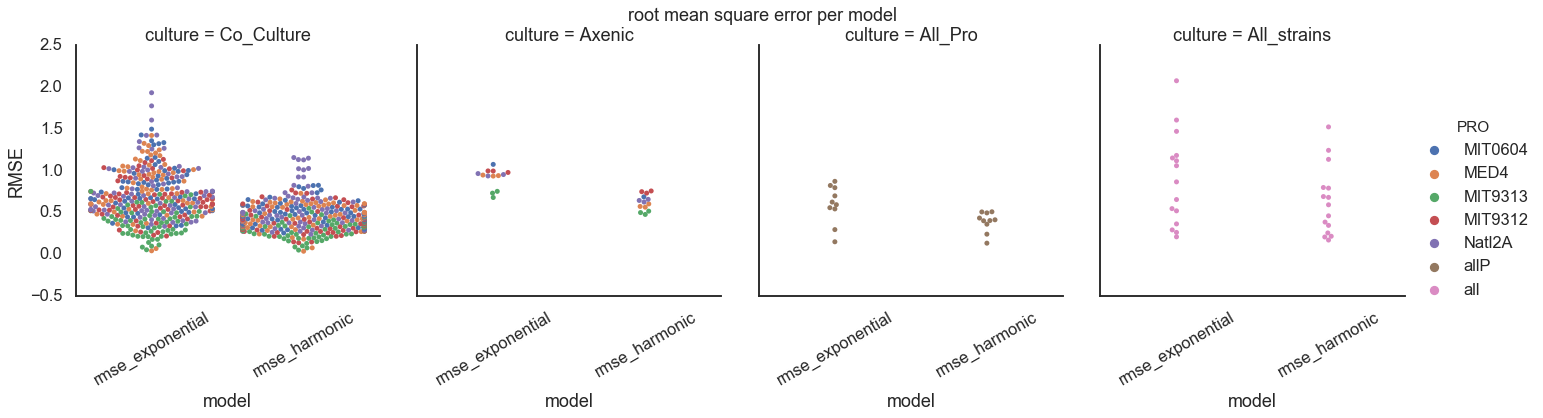

In [53]:
cols=['rmse_exponential',# 'rmse_hyperbolic', 
      'rmse_harmonic', 
      #'rmse_exponential_60', 'rmse_hyperbolic_60', 'rmse_harmonic_60',
      #'mse_exponential_5', 'mse_hyperbolic_5', 'mse_harmonic_5'
] 

g = sns.catplot(data=dfscorem.loc[dfscorem.model.isin(cols)], x='model', y='RMSE', hue='PRO', kind='swarm', #aspect=2,
           #palette='cubehelix'
            col='culture',
           )
g.set_xticklabels(rotation=30)
#plt.xticks(rotation=45)
plt.suptitle('root mean square error per model', y=1)

C:\Users\wosnat\Anaconda3\lib\site-packages\numpy\core\_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
C:\Users\wosnat\Anaconda3\lib\site-packages\numpy\core\_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Text(0.5,1,'RMSE co-culture')

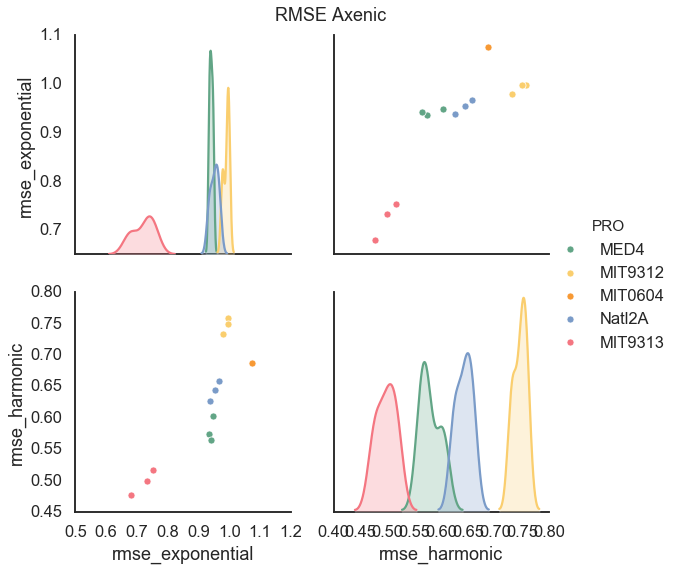

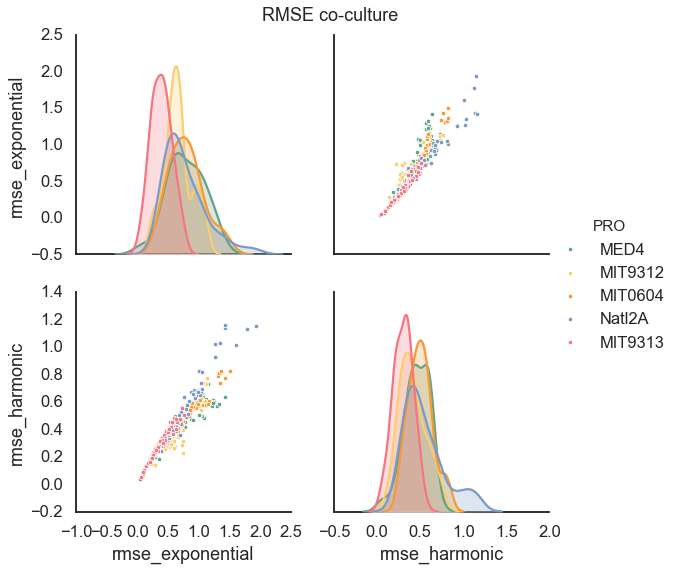

In [54]:
sns.pairplot(dfscore.loc[dfscore.culture == 'Axenic'], 
             vars=['rmse_exponential', #'rmse_hyperbolic', 
                   'rmse_harmonic',
                            #'rmse_exponential_60', 'rmse_hyperbolic_60', 'rmse_harmonic_60'
                            #'rmse_exponential_5', 'rmse_hyperbolic_5', 'rmse_harmonic_5',
                           ],
             height=4, 
             hue='PRO', hue_order=porder, palette=ppallete,
             plot_kws={"s": 50},
             #kind='reg'
            )
plt.suptitle('RMSE Axenic', y=1)
sns.pairplot(dfscore.loc[dfscore.culture == 'Co_Culture'], 
             vars=['rmse_exponential', #'rmse_hyperbolic',
                   'rmse_harmonic',
                            #'rmse_exponential_60', 'rmse_hyperbolic_60', 'rmse_harmonic_60'
                            #'rmse_exponential_5', 'rmse_hyperbolic_5', 'rmse_harmonic_5',
                           ],
             height=4, 
             plot_kws={"s": 20},
             hue='PRO', hue_order=porder, palette=ppallete,
             #kind='reg'
            )
plt.suptitle('RMSE co-culture', y=1)


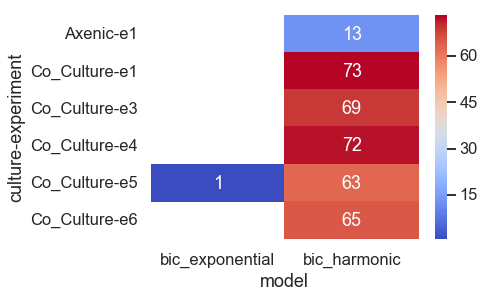

In [55]:
best_model_df = dfscorem.loc[dfscorem.model.isin(['bic_exponential', 'bic_harmonic'])
                            ].sort_values('RMSE', ascending=True).drop_duplicates([
    'experiment_sample', ])
t = best_model_df.loc[best_model_df.culture.isin(['Axenic', 'Co_Culture'])].pivot_table(index=['culture',  'experiment'],columns=['model'], values='sample', aggfunc='count')
sns.set_context('talk')
sns.heatmap(t, annot=True, cmap='coolwarm')


Text(0.5,1,'best model (lowest bic)')

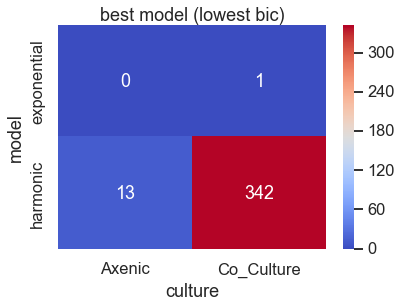

In [56]:
best_model_df = dfscorem.loc[dfscorem.model.isin(['bic_exponential', 'bic_harmonic'])
                            ].sort_values('RMSE', ascending=True).drop_duplicates([
    'experiment_sample', ])
t = best_model_df.loc[best_model_df.culture.isin(['Axenic', 'Co_Culture'])].pivot_table(index=['culture'],columns=['model'], values='sample', aggfunc='count')
t.rename(columns={'bic_exponential': 'exponential', 'bic_harmonic': 'harmonic'}, inplace=True)
t.fillna(0, inplace=True)
for i in t.columns:
    t[i] = t[i].astype(int)
sns.set_context('talk')
sns.heatmap(t.T, annot=True, cmap='coolwarm', fmt='d')
plt.title('best model (lowest bic)')

Text(0.5,1,'best model fit')

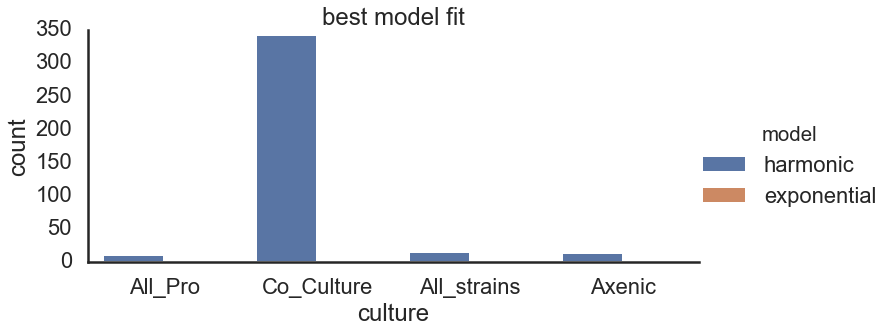

In [57]:
sns.set_context('poster')
best_model_df = dfscorem.loc[dfscorem.model.isin(['bic_exponential', 'bic_harmonic'])
                            ].sort_values('RMSE', ascending=True).drop_duplicates([
    'experiment_sample', ])
best_model_df.model = best_model_df.model.map({'bic_exponential': 'exponential', 'bic_harmonic': 'harmonic'})
sns.catplot(data=best_model_df, x='culture', hue='model', kind='count', aspect=2)
plt.title("best model fit")

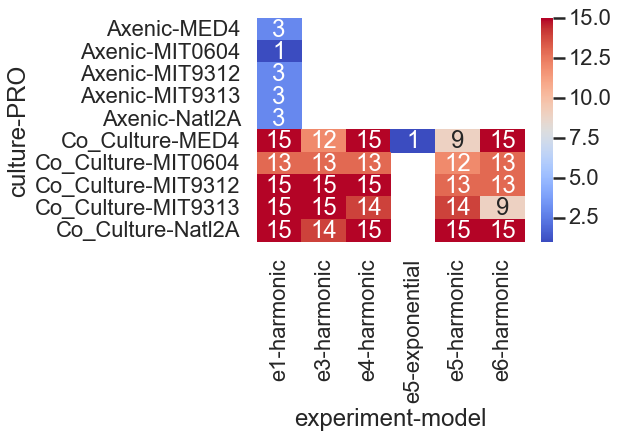

In [58]:
t = best_model_df.loc[best_model_df.culture.isin(['Axenic', 'Co_Culture'])].pivot_table(index=['culture',  'PRO', ],columns=['experiment', 'model', ], values='sample', aggfunc='count')
#sns.set_context('talk')
sns.heatmap(t, annot=True, cmap='coolwarm')


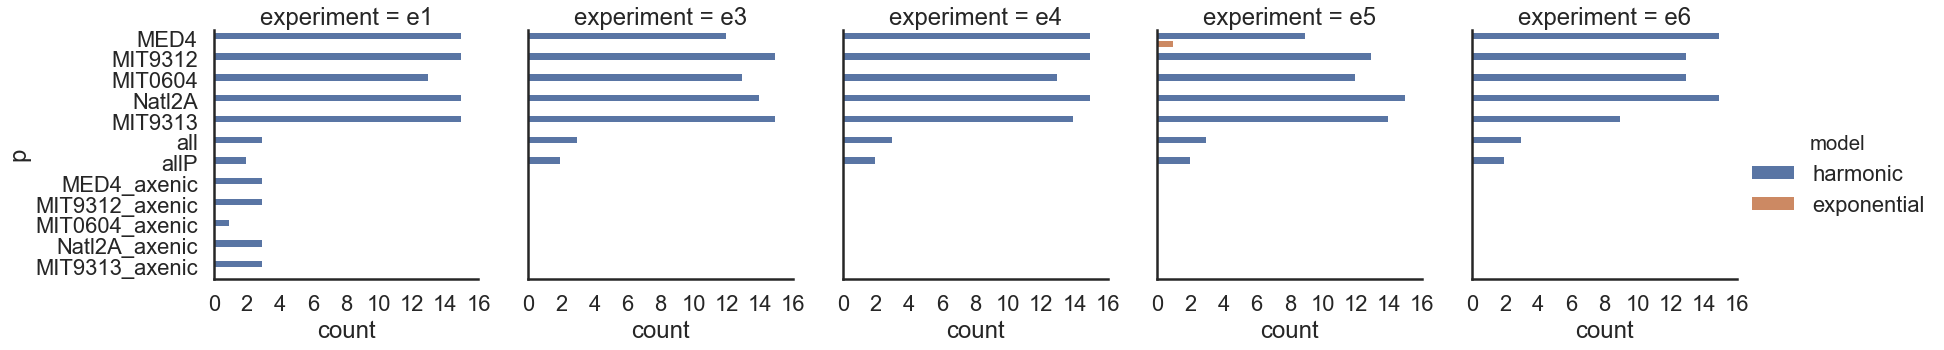

In [59]:
best_model_df['p'] = best_model_df['PRO']
best_model_df.loc[best_model_df.culture == 'Axenic','p'] = best_model_df.loc[best_model_df.culture == 'Axenic','p'] + '_axenic'
sns.catplot(data=best_model_df, y='p', hue='model', kind='count', col='experiment',
           order=['MED4', 'MIT9312', 'MIT0604', 'Natl2A', 'MIT9313', 'all', 'allP',
                     'MED4_axenic', 'MIT9312_axenic', 'MIT0604_axenic', 'Natl2A_axenic', 'MIT9313_axenic'
                     ],
            col_order=eorder,
           )


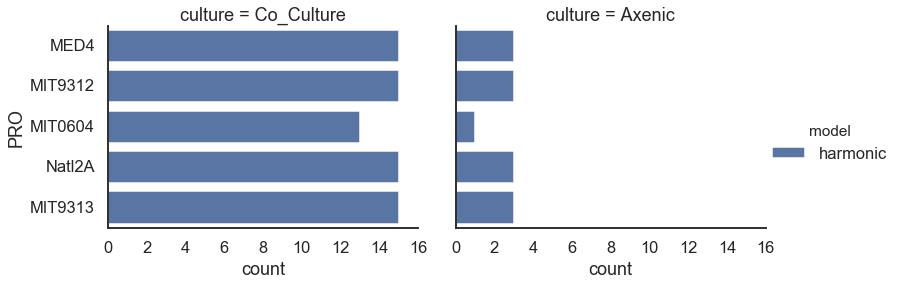

In [60]:
sns.set_context('talk')
#best_model_df['p'] = best_model_df['PRO']
#best_model_df.loc[best_model_df.culture == 'Axenic','p'] = best_model_df.loc[best_model_df.culture == 'Axenic','p'] + '_axenic'
sns.catplot(data=best_model_df.loc[(best_model_df.experiment == 'e1') & 
                                   (best_model_df.culture.isin(['Co_Culture', 'Axenic']))],
            y='PRO', hue='model', kind='count', col='culture',
           order=porder,
            col_order=['Co_Culture', 'Axenic'],
            aspect=1.4, height=4
            #col_order=eorder,
           )


In [61]:
best_model_df.p.unique()

array(['allP', 'MIT9313', 'all', 'MIT9312', 'MIT0604', 'Natl2A', 'MED4',
       'MIT9313_axenic', 'MED4_axenic', 'Natl2A_axenic', 'MIT0604_axenic',
       'MIT9312_axenic'], dtype=object)

In [62]:
porder

['MED4', 'MIT9312', 'MIT0604', 'Natl2A', 'MIT9313']

In [63]:
best_model_df.head()

experiment_sample experiment sample      PRO      ALT      culture  \
2808           e3, 36B         e3    36B     allP  all_Pro      All_Pro   
2971            e5, 7C         e5     7C  MIT9313       DE   Co_Culture   
2809           e3, 37A         e3    37A      all      all  All_strains   
2826            e3, 7C         e3     7C  MIT9313       DE   Co_Culture   
2853           e4, 17A         e4    17A  MIT9313     BS11   Co_Culture   

         model        RMSE             s                e        p  
2808  harmonic -277.491666  36B, all_Pro      e3, All_Pro     allP  
2971  harmonic -253.756168        7C, DE   e5, Co_Culture  MIT9313  
2809  harmonic -249.394135      37A, all  e3, All_strains      all  
2826  harmonic -244.514677        7C, DE   e3, Co_Culture  MIT9313  
2853  harmonic -232.121809     17A, BS11   e4, Co_Culture  MIT9313

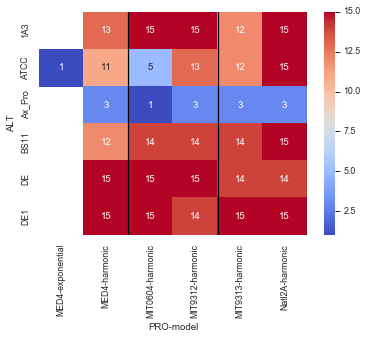

In [64]:

t = best_model_df.loc[best_model_df.culture.isin(['Axenic', 'Co_Culture'])
                     ].pivot_table(index=['ALT'], columns=['PRO','model', ], values='sample', aggfunc='count')
sns.set_context('paper')
sns.heatmap(t, annot=True, cmap='coolwarm' )
for i in [2,4,6,8,10]:
    plt.axvline(i, color='black',)


In [65]:
best_model_df['model'].value_counts()


harmonic       380
exponential      1
Name: model, dtype: int64

In [66]:
best_model_df.head()


experiment_sample experiment sample      PRO      ALT      culture  \
2808           e3, 36B         e3    36B     allP  all_Pro      All_Pro   
2971            e5, 7C         e5     7C  MIT9313       DE   Co_Culture   
2809           e3, 37A         e3    37A      all      all  All_strains   
2826            e3, 7C         e3     7C  MIT9313       DE   Co_Culture   
2853           e4, 17A         e4    17A  MIT9313     BS11   Co_Culture   

         model        RMSE             s                e        p  
2808  harmonic -277.491666  36B, all_Pro      e3, All_Pro     allP  
2971  harmonic -253.756168        7C, DE   e5, Co_Culture  MIT9313  
2809  harmonic -249.394135      37A, all  e3, All_strains      all  
2826  harmonic -244.514677        7C, DE   e3, Co_Culture  MIT9313  
2853  harmonic -232.121809     17A, BS11   e4, Co_Culture  MIT9313

In [67]:
dfscore.describe()

exponential_popt_0  exponential_popt_1  exponential_popt_2  \
count          381.000000          381.000000          381.000000   
mean             0.022386            0.800525            0.800525   
std              0.018102            0.245163            0.245163   
min              0.004071            0.500000            0.500000   
25%              0.014078            0.500000            0.500000   
50%              0.018768            1.000000            1.000000   
75%              0.025356            1.000000            1.000000   
max              0.133408            1.000000            1.000000   

       rmse_exponential  rmse_exponential_60  rmse_exponential_5  \
count        381.000000           373.000000          381.000000   
mean           0.695150             0.450949            0.747805   
std            0.319538             0.249773            0.575306   
min            0.042274             0.064405            0.019889   
25%            0.480646             0.271911            0.367181   
50%            0.654244             0.407699            0.616361   
75%            0.910559             0.558712            0.982160   
max            2.075748             1.360195            4.305681   

       bic_exponential  harmonic_popt_0  harmonic_popt_1  harmonic_popt_2  \
count       381.000000       381.000000       381.000000       381.000000   
mean        -43.162952         0.044115         0.759843         0.759843   
std          58.538463         0.028877         0.250135         0.250135   
min        -260.873489         0.005001         0.500000         0.500000   
25%         -73.289229         0.025445         0.500000         0.500000   
50%         -37.271866         0.037492         1.000000         1.000000   
75%          -3.928115         0.056770         1.000000         1.000000   
max         115.527767         0.198173         1.000000         1.000000   

       rmse_harmonic  rmse_harmonic_60  rmse_harmonic_5  bic_harmonic  
count     381.000000        373.000000       381.000000    381.000000  
mean        0.458171          0.289862         0.592982    -91.309031  
std         0.198889          0.127790         0.471978     50.841322  
min         0.036900          0.057496         0.002190   -277.491666  
25%         0.329875          0.188626         0.267798   -116.375789  
50%         0.434844          0.275450         0.487958    -82.541132  
75%         0.572832          0.374598         0.770582    -59.866959  
max         1.523937          0.632306         3.753550     70.090257

In [68]:
sns.set_context('poster')

In [69]:
dfscore.columns

Index(['experiment_sample', 'experiment', 'sample', 'PRO', 'ALT', 'culture',
       'exponential_popt_0', 'exponential_popt_1', 'exponential_popt_2',
       'rmse_exponential', 'rmse_exponential_60', 'rmse_exponential_5',
       'bic_exponential', 'harmonic_popt_0', 'harmonic_popt_1',
       'harmonic_popt_2', 'rmse_harmonic', 'rmse_harmonic_60',
       'rmse_harmonic_5', 'bic_harmonic'],
      dtype='object')

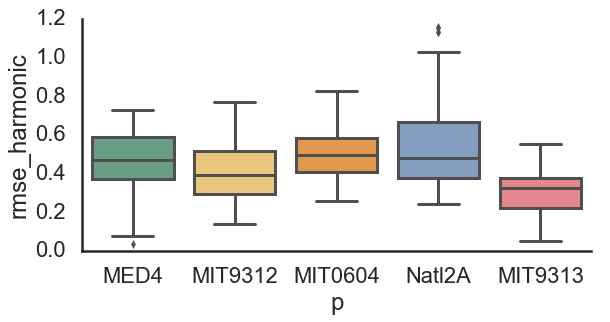

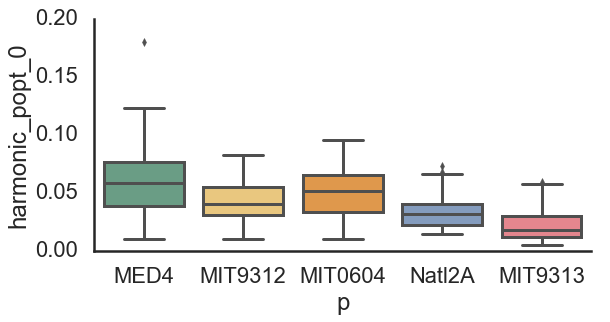

In [70]:
dfscore['p'] = dfscore.PRO
dfscore.loc[dfscore.culture=='Axenic','p'] = dfscore.loc[dfscore.culture=='Axenic','p'] + '_Axenic'

for i in ['rmse_harmonic', 'harmonic_popt_0', ]:
    sns.catplot(data=dfscore.loc[dfscore.culture =='Co_Culture'], 
                x='p', y=i, kind='box',
           order=porder, palette=ppallete,
           aspect=1.8)


In [71]:
best_model_df.loc[best_model_df.model == 'bic_hyperbolic', 'experiment_sample']

Series([], Name: experiment_sample, dtype: object)

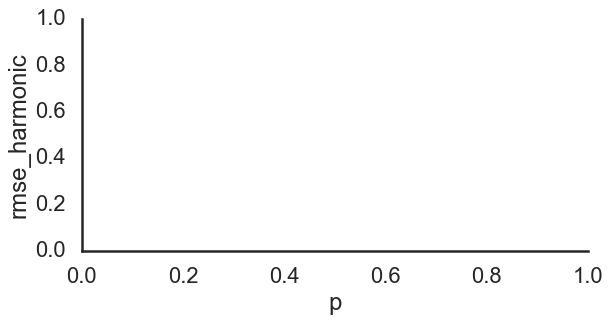

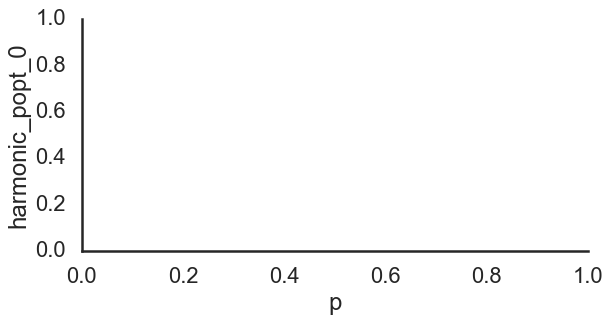

In [72]:
dfscore['p'] = dfscore.PRO
dfscore.loc[dfscore.culture=='Axenic','p'] = dfscore.loc[dfscore.culture=='Axenic','p'] + '_Axenic'

for i in ['rmse_harmonic', 'harmonic_popt_0',  ]:
    sns.catplot(data=dfscore.loc[#(dfscore.culture =='Co_Culture') &
                                dfscore.experiment_sample.isin(
                                    best_model_df.loc[best_model_df.model == 'bic_harmonic', 'experiment_sample'])
                                ], 
                x='p', y=i, kind='box',
           order=porder, palette=ppallete,
           aspect=1.8)
    



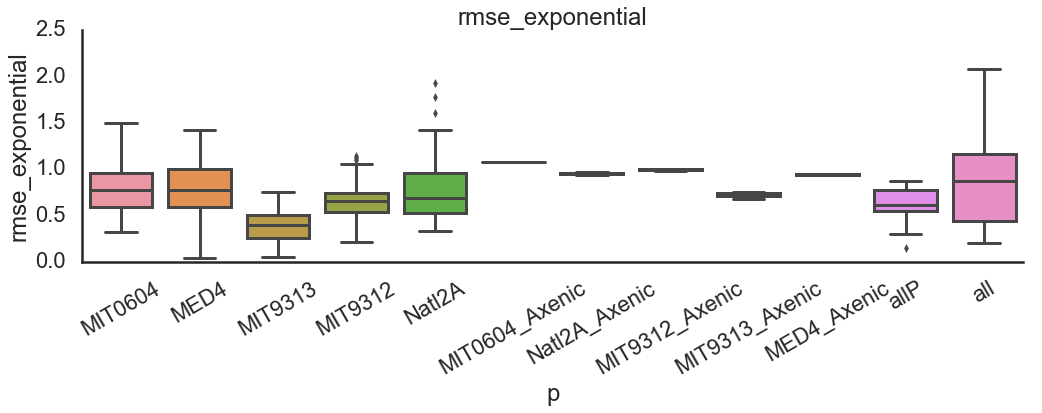

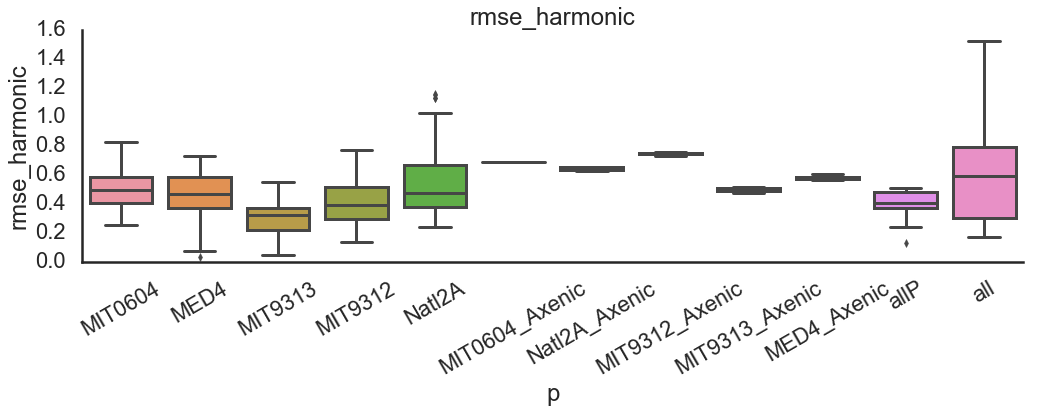

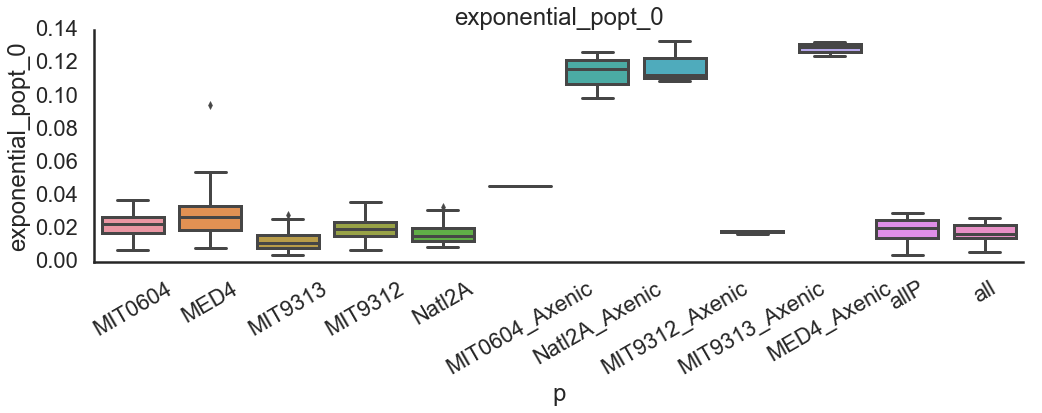

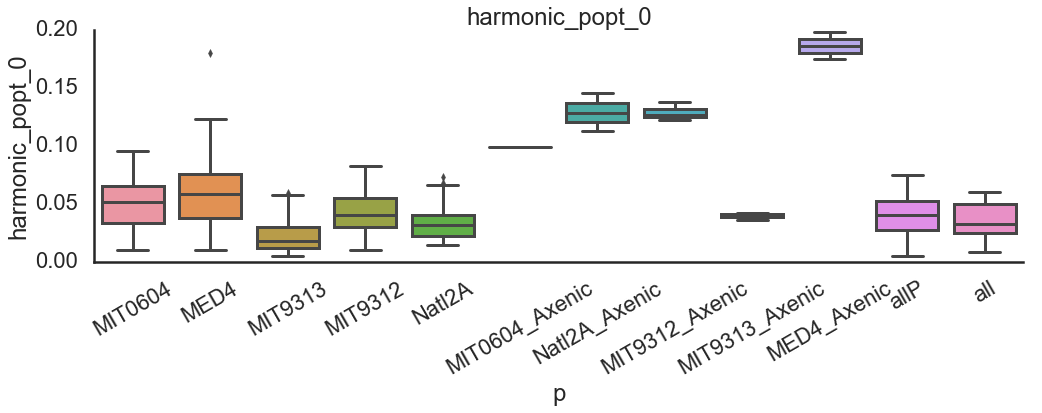

In [73]:
dfscore['p'] = dfscore.PRO
dfscore.loc[dfscore.culture.isin(['Axenic']),'p'] = dfscore.loc[dfscore.culture.isin(['Axenic']),'p'] + '_Axenic'

for i in ['rmse_exponential','rmse_harmonic', 'exponential_popt_0',  'harmonic_popt_0']:
    sns.catplot(data=dfscore, 
                x='p', y=i, kind='box',
           #order=porder, palette=ppallete,
           aspect=3)
    #plt.yscale('log')
    plt.xticks(rotation=30)
    plt.title(i)


In [74]:
dfscore.head()

experiment_sample experiment sample      PRO  ALT     culture  \
0           e1, 10A         e1    10A  MIT0604   DE  Co_Culture   
1           e1, 10B         e1    10B  MIT0604   DE  Co_Culture   
2           e1, 10C         e1    10C  MIT0604   DE  Co_Culture   
3           e1, 11A         e1    11A     MED4  DE1  Co_Culture   
4           e1, 11B         e1    11B     MED4  DE1  Co_Culture   

   exponential_popt_0  exponential_popt_1  exponential_popt_2  \
0            0.030385                 1.0                 1.0   
1            0.028786                 1.0                 1.0   
2            0.029997                 0.5                 0.5   
3            0.051013                 1.0                 1.0   
4            0.054454                 0.5                 0.5   

   rmse_exponential  ...  rmse_exponential_5  bic_exponential  \
0          1.310166  ...            1.689817        51.423179   
1          1.323008  ...            1.634439        52.964343   
2          1.358430  ...            1.676144        57.138967   
3          1.074726  ...            0.858538        20.294636   
4          1.180525  ...            1.658170        34.960479   

   harmonic_popt_0  harmonic_popt_1  harmonic_popt_2  rmse_harmonic  \
0         0.074455              0.5              0.5       0.787542   
1         0.069021              0.5              0.5       0.808392   
2         0.073705              0.5              0.5       0.825611   
3         0.112871              0.5              0.5       0.478794   
4         0.123036              1.0              1.0       0.584613   

   rmse_harmonic_60  rmse_harmonic_5  bic_harmonic        p  
0          0.480087         1.263365    -28.997653  MIT0604  
1          0.449541         1.211366    -24.868969  MIT0604  
2          0.447725         1.218666    -21.538885  MIT0604  
3          0.467234         0.513106   -109.073366     MED4  
4          0.533575         0.953541    -76.076352     MED4  

[5 rows x 21 columns]

In [75]:
best_model_df.columns

Index(['experiment_sample', 'experiment', 'sample', 'PRO', 'ALT', 'culture',
       'model', 'RMSE', 's', 'e', 'p'],
      dtype='object')

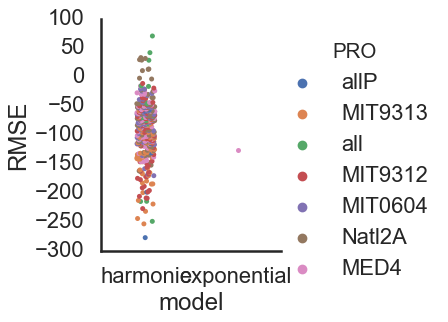

In [76]:
sns.catplot(data=best_model_df, x='model', y='RMSE', hue='PRO')

In [77]:
df_best_count = best_model_df.groupby(['culture','p', 'experiment',  'model'])['sample'].count().reset_index()
df_best_count.model =df_best_count.model.map({'bic_exponential': 'exponential', 'bic_harmonic': 'harmonic'})
df_best_count.rename(columns={'sample': 'number of samples'}, inplace=True)

sns.catplot(data=df_best_count,y='p', hue='model', x='number of samples', #row='culture',
            col='experiment', kind='bar')

ValueError: min() arg is an empty sequence

In [78]:
value_vars = [ 'FL', 'exponential', #'hyperbolic',
              'harmonic',
             ]
id_vars = ['experiment_sample', 'day',  'experiment', 'sample', 'PRO', 'ALT',
       'culture', ]      
dfresm = dfdecline.melt(value_vars=value_vars, id_vars=id_vars )

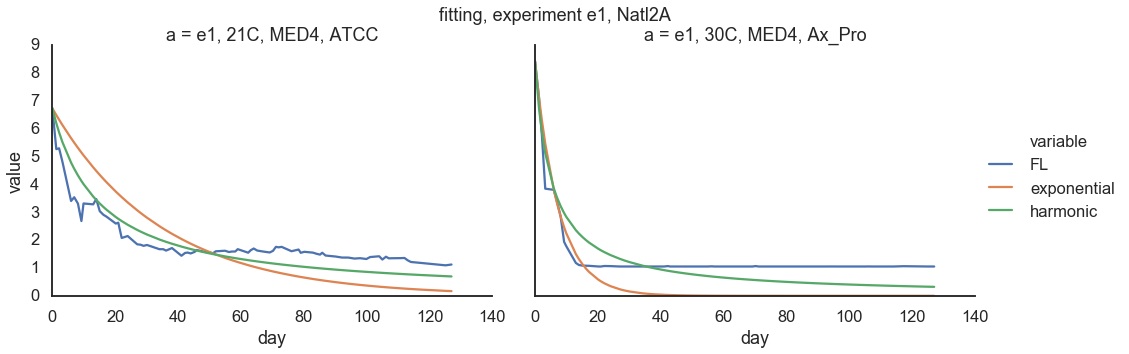

In [79]:
sns.set_context('talk')
dfresm['alt'] = dfresm['sample'] +', '+dfresm['ALT']
dfresm['a'] = dfresm['experiment_sample'] +', '+dfresm['PRO']+', '+dfresm['ALT']

for p in ['Natl2A']:
    for e in ['e1']:
        sns.relplot(data=dfresm.loc[(dfresm.experiment == e) & #(dfresm.PRO == p) &
                                   (dfresm['sample'].isin(['21C', '30C']))], 
                x='day',
                y='value',
                hue='variable',
                col='a',
                #col_wrap=6,
                kind='line',
                    aspect=1.4
               )
        plt.suptitle(f'fitting, experiment {e}, {p}', y=1)
        plt.show()

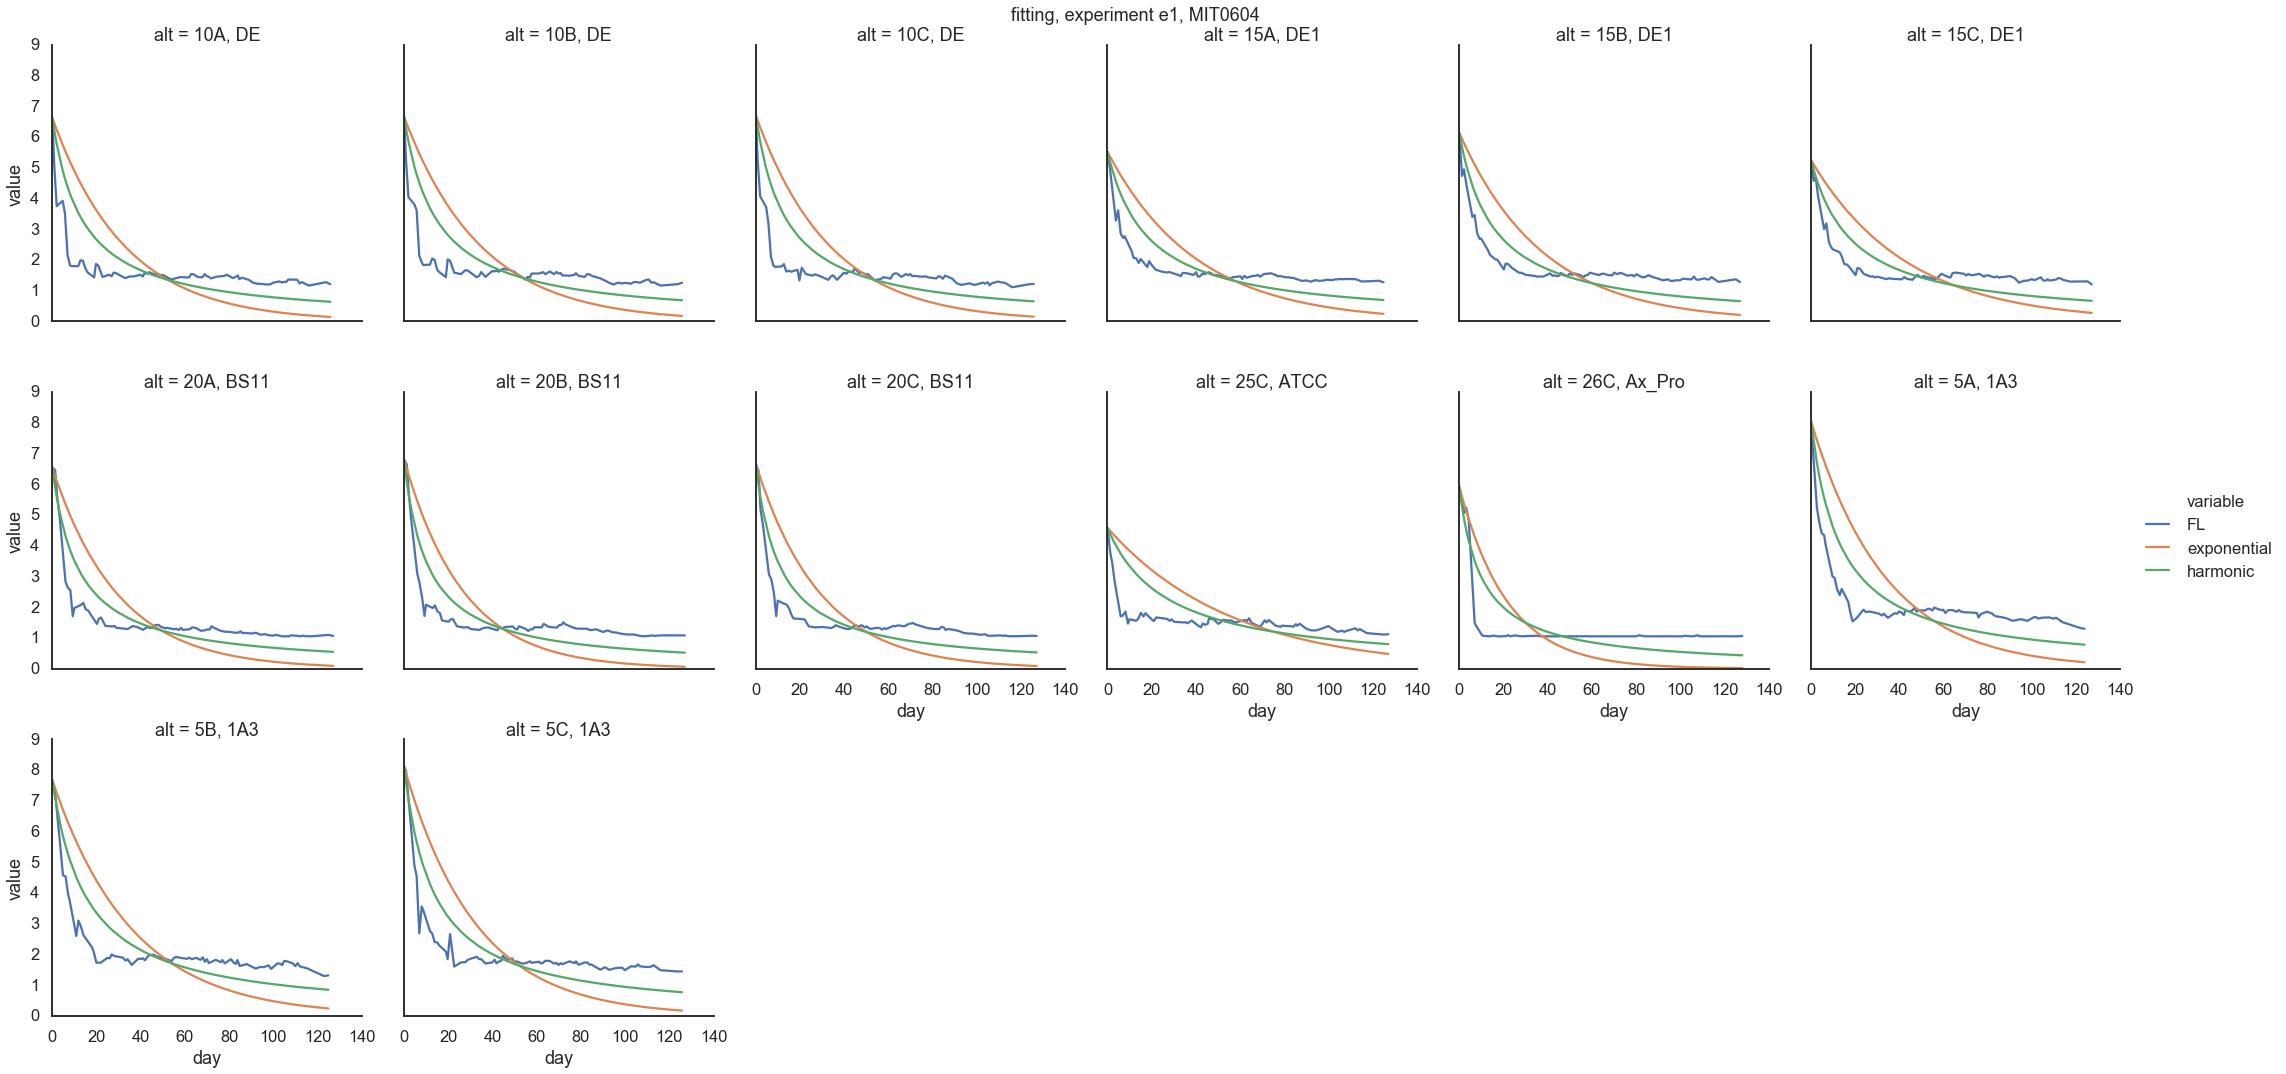

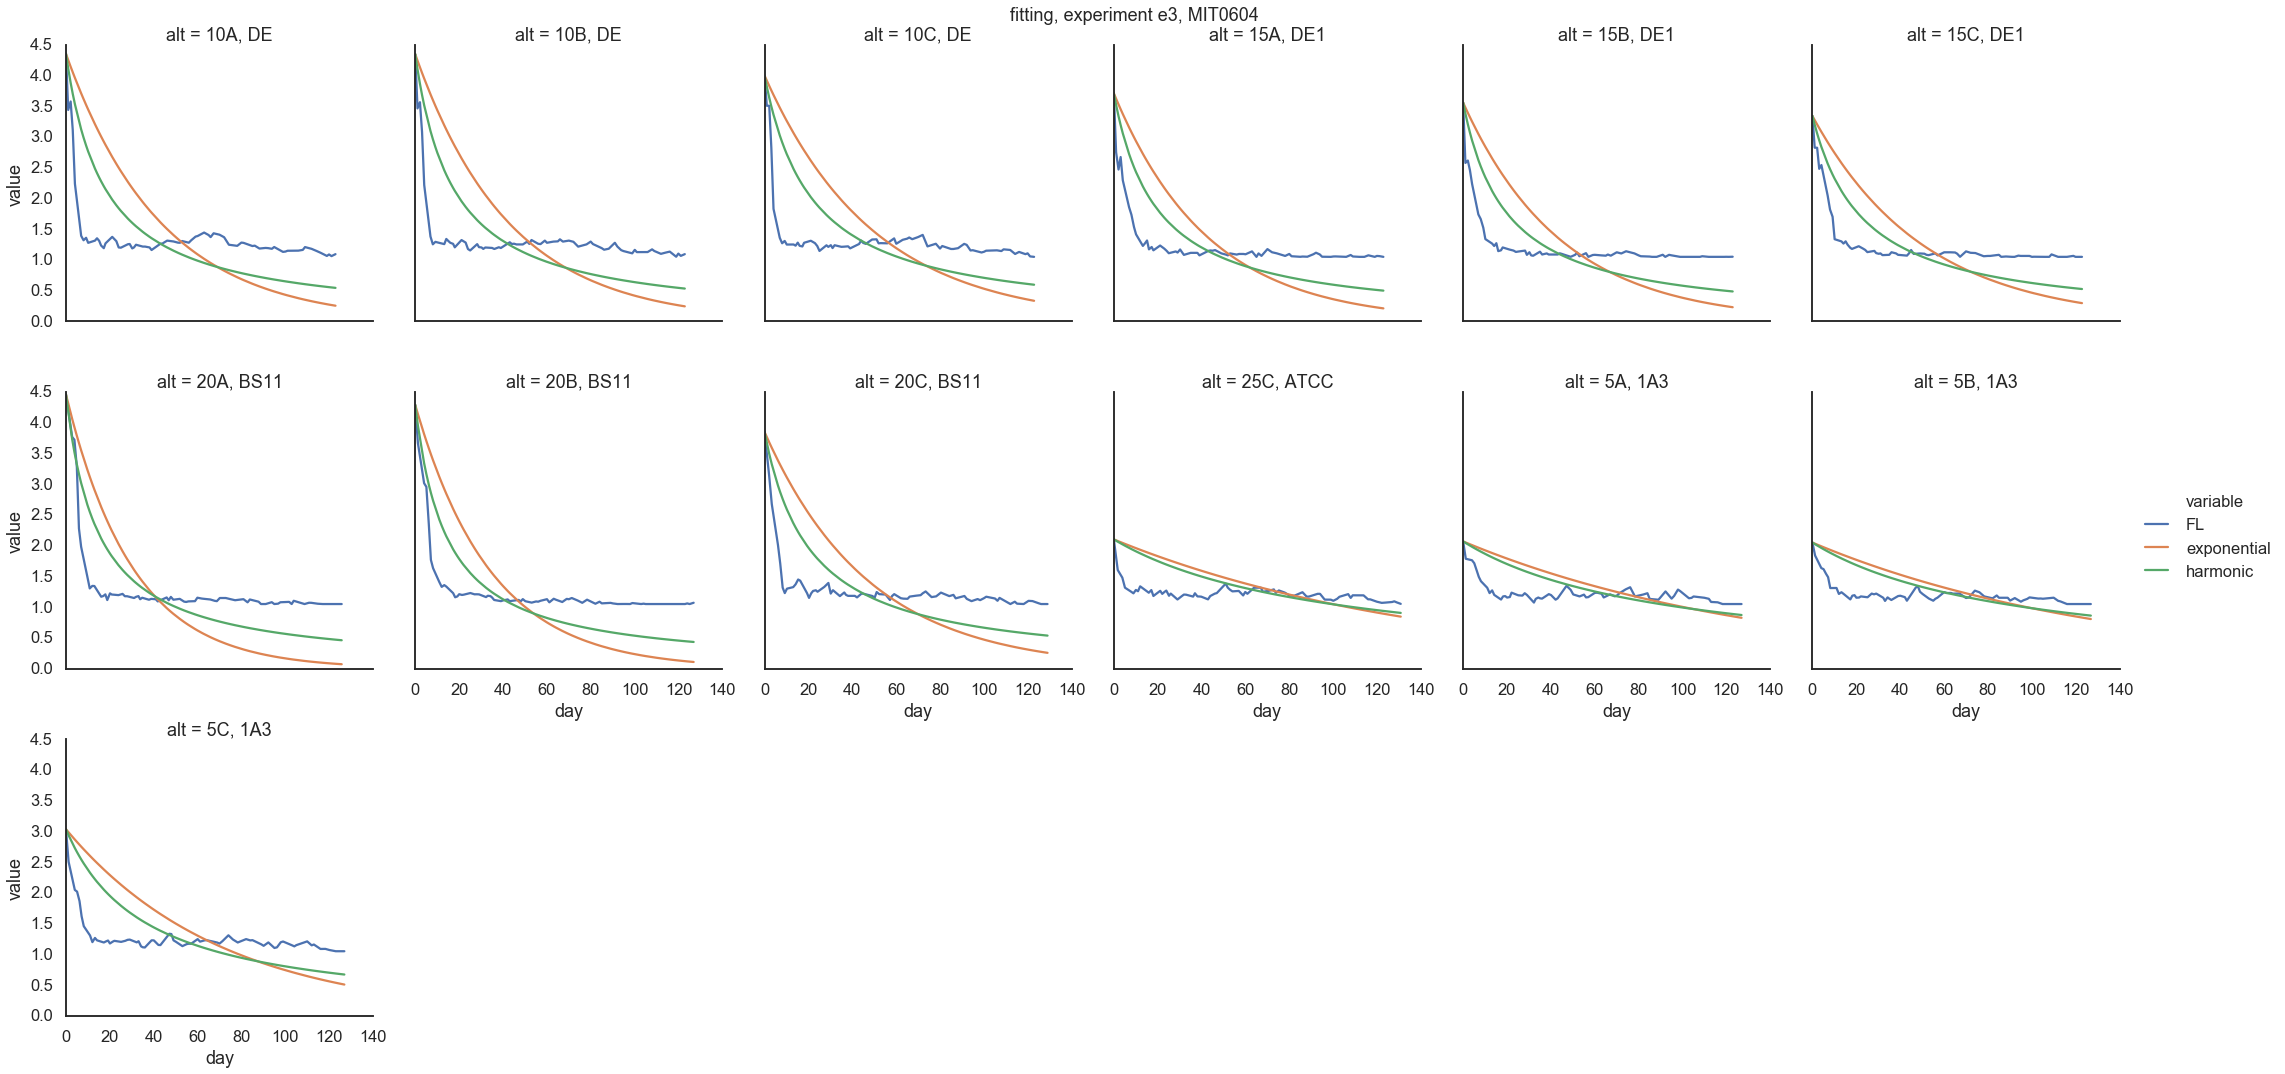

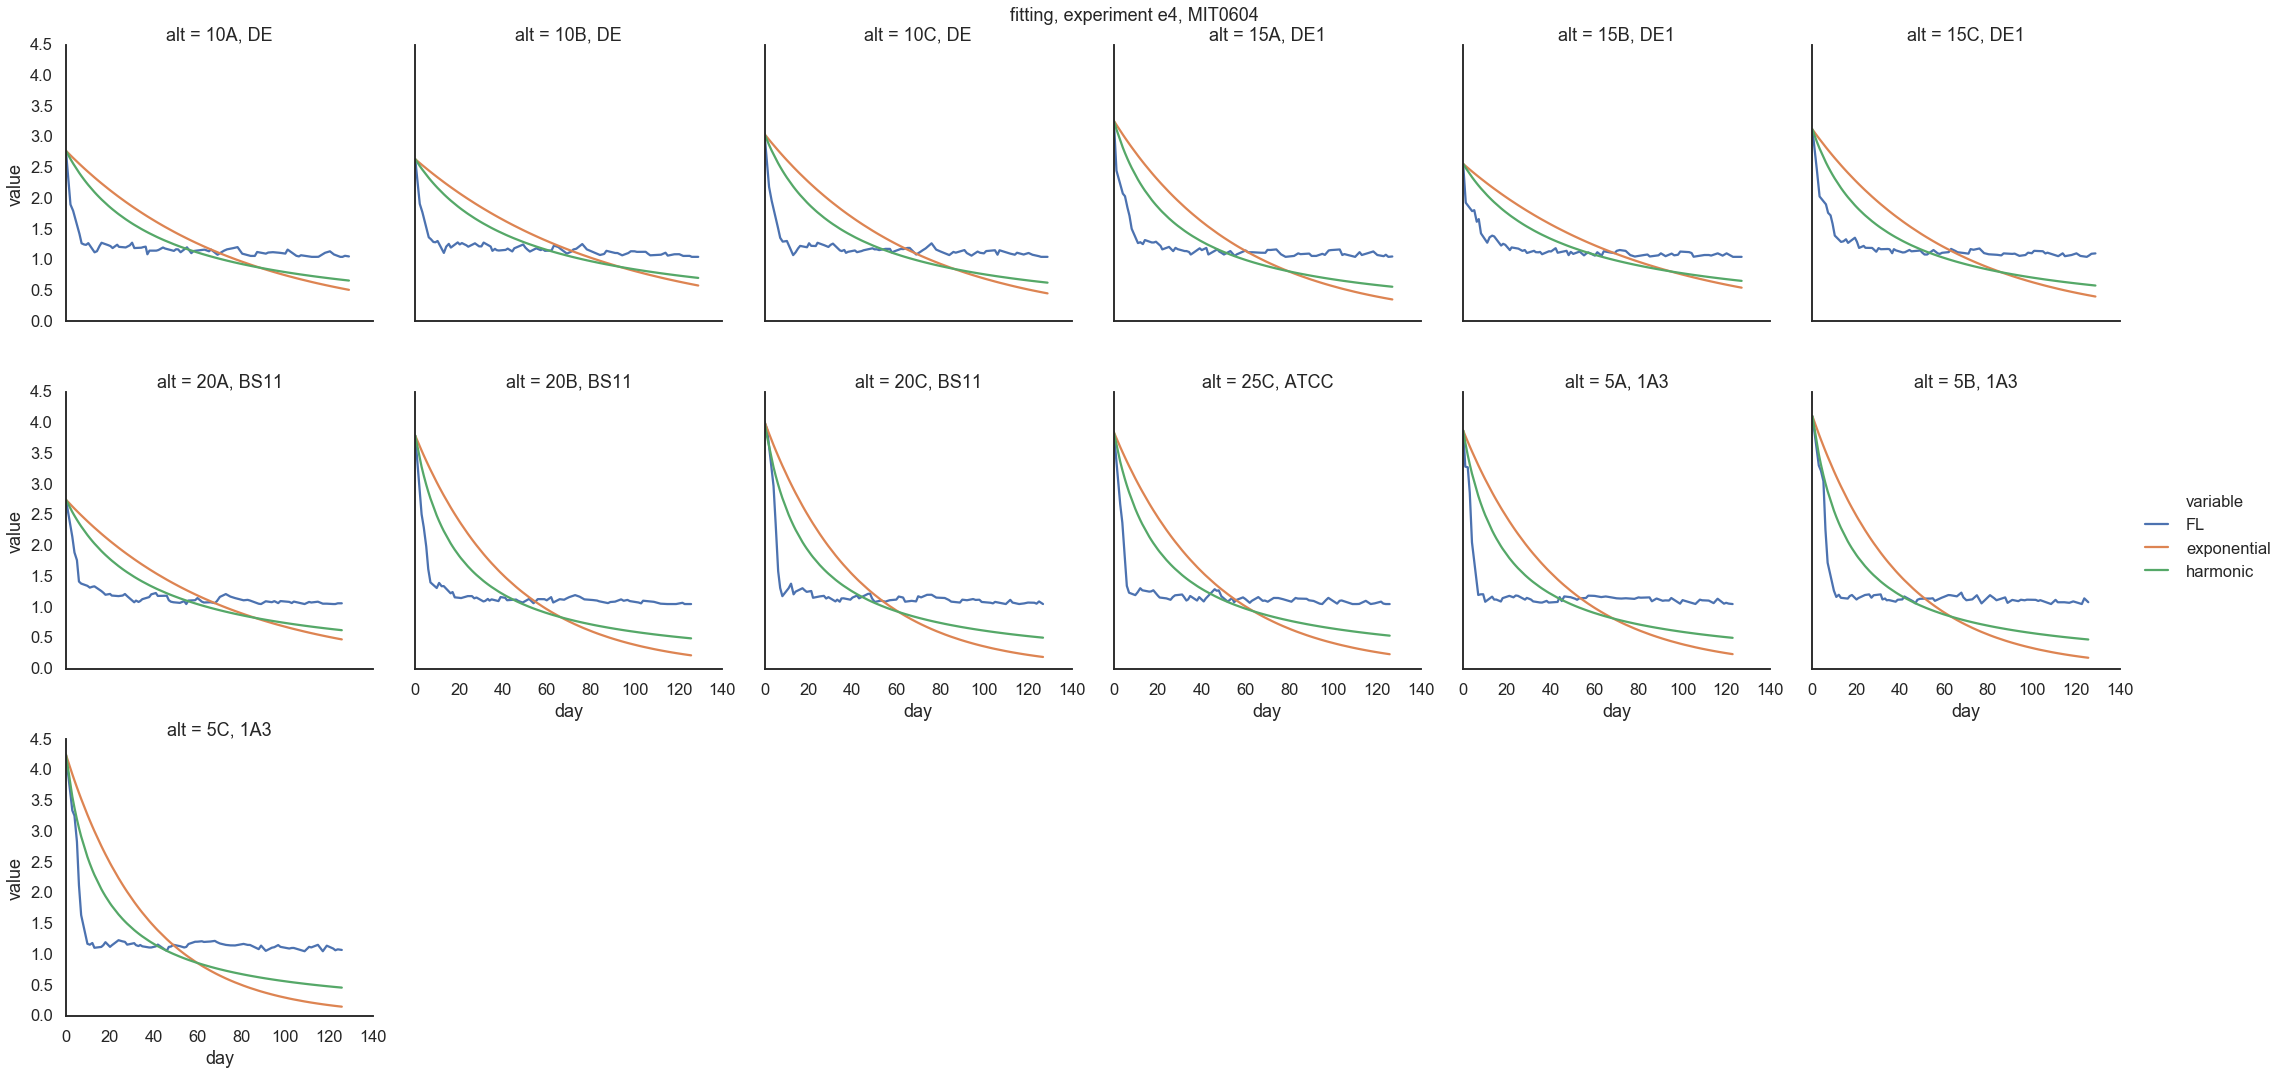

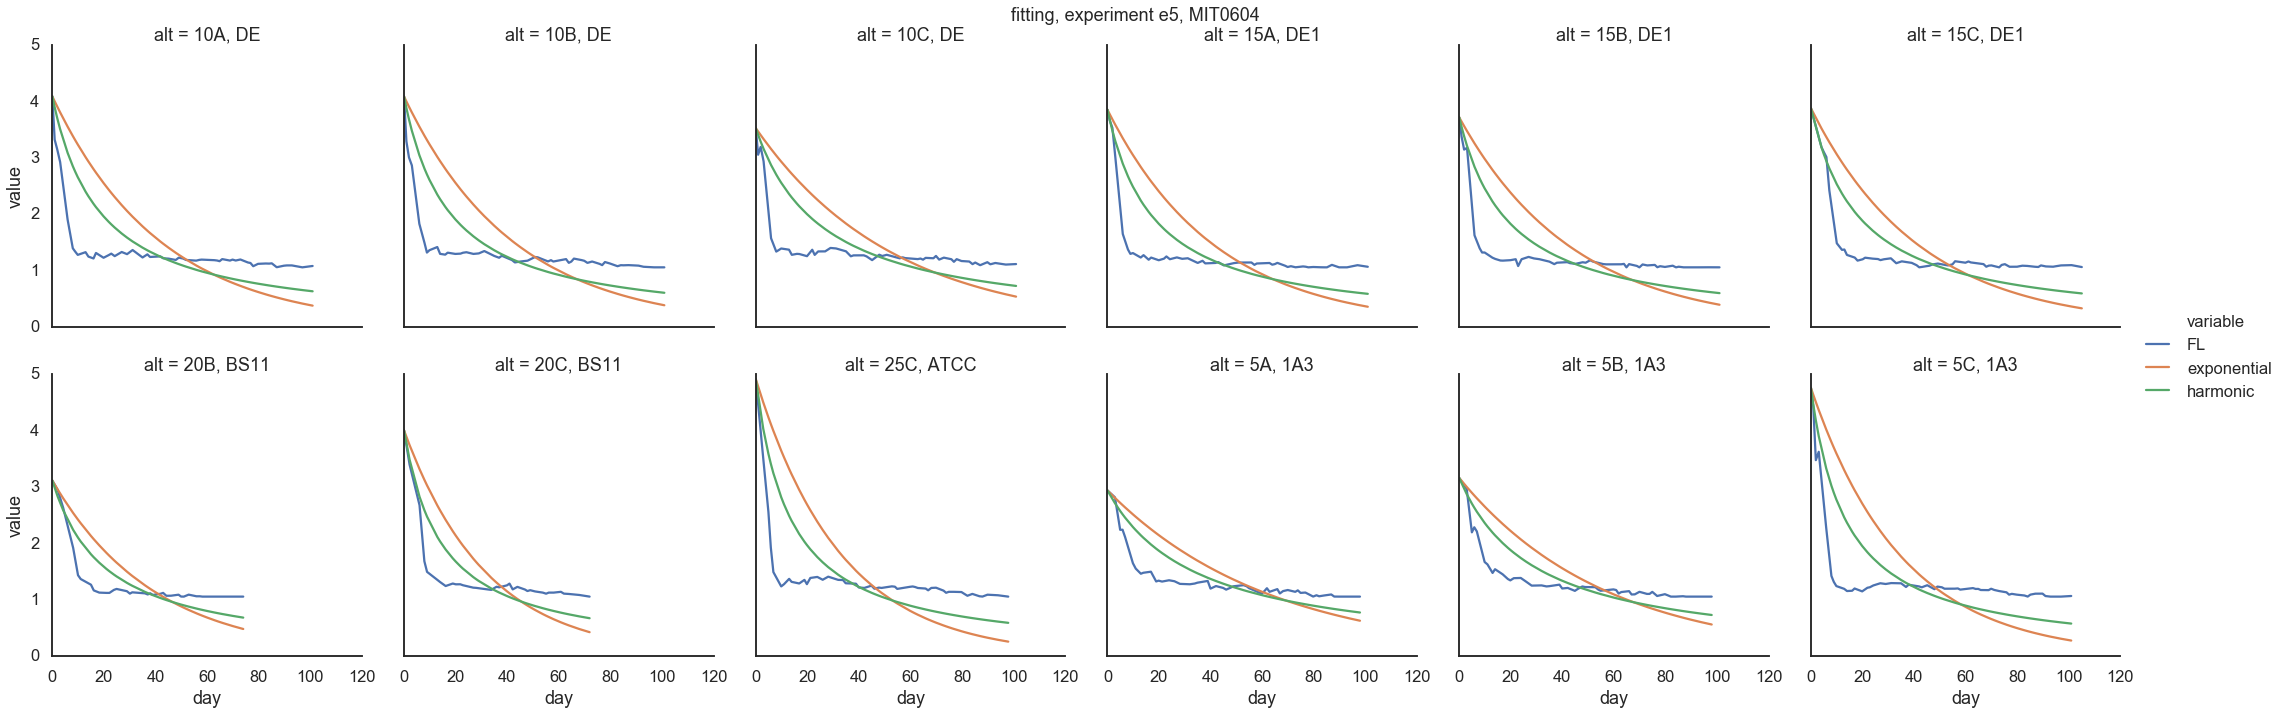

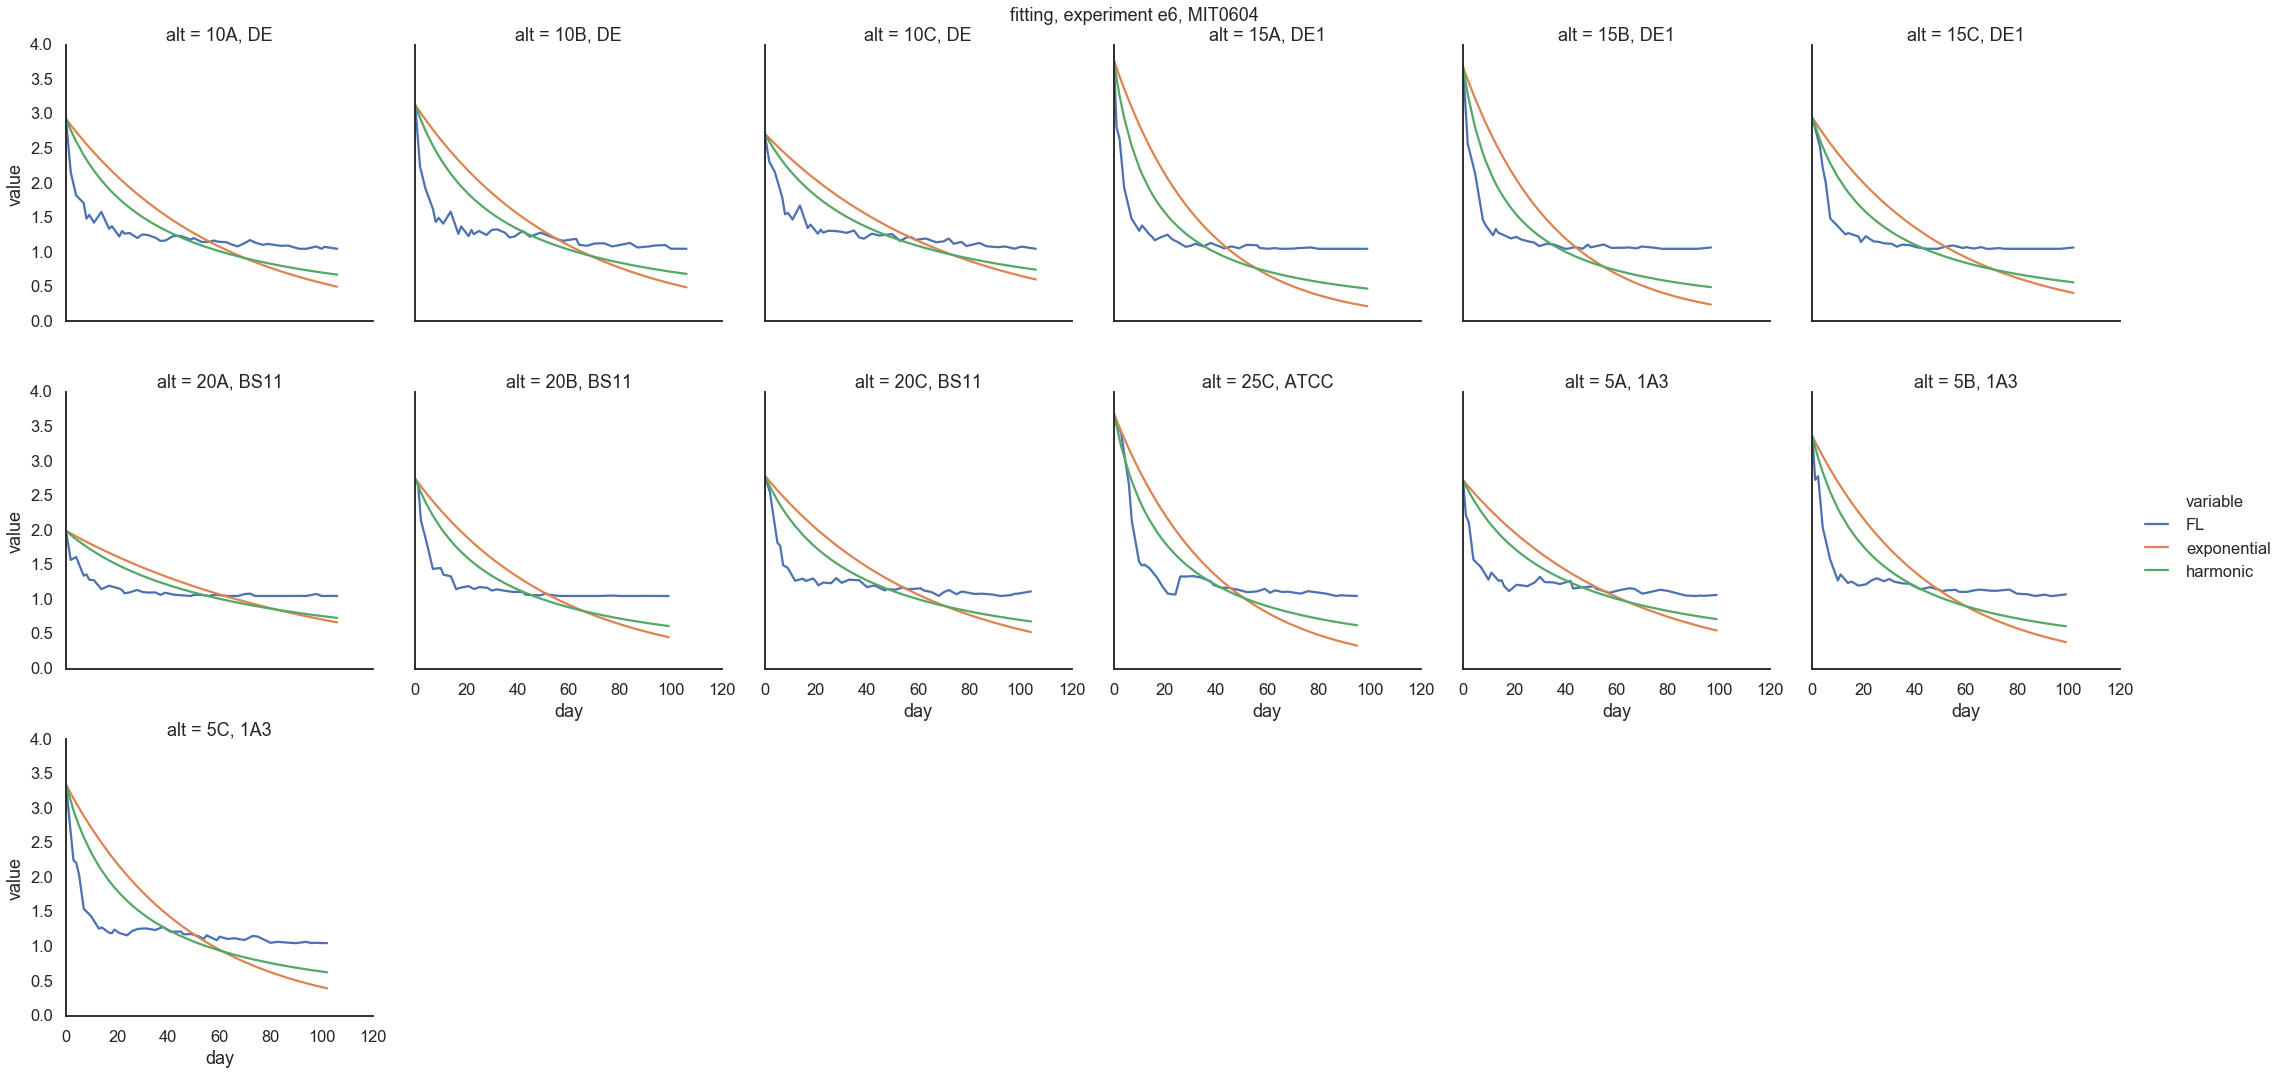

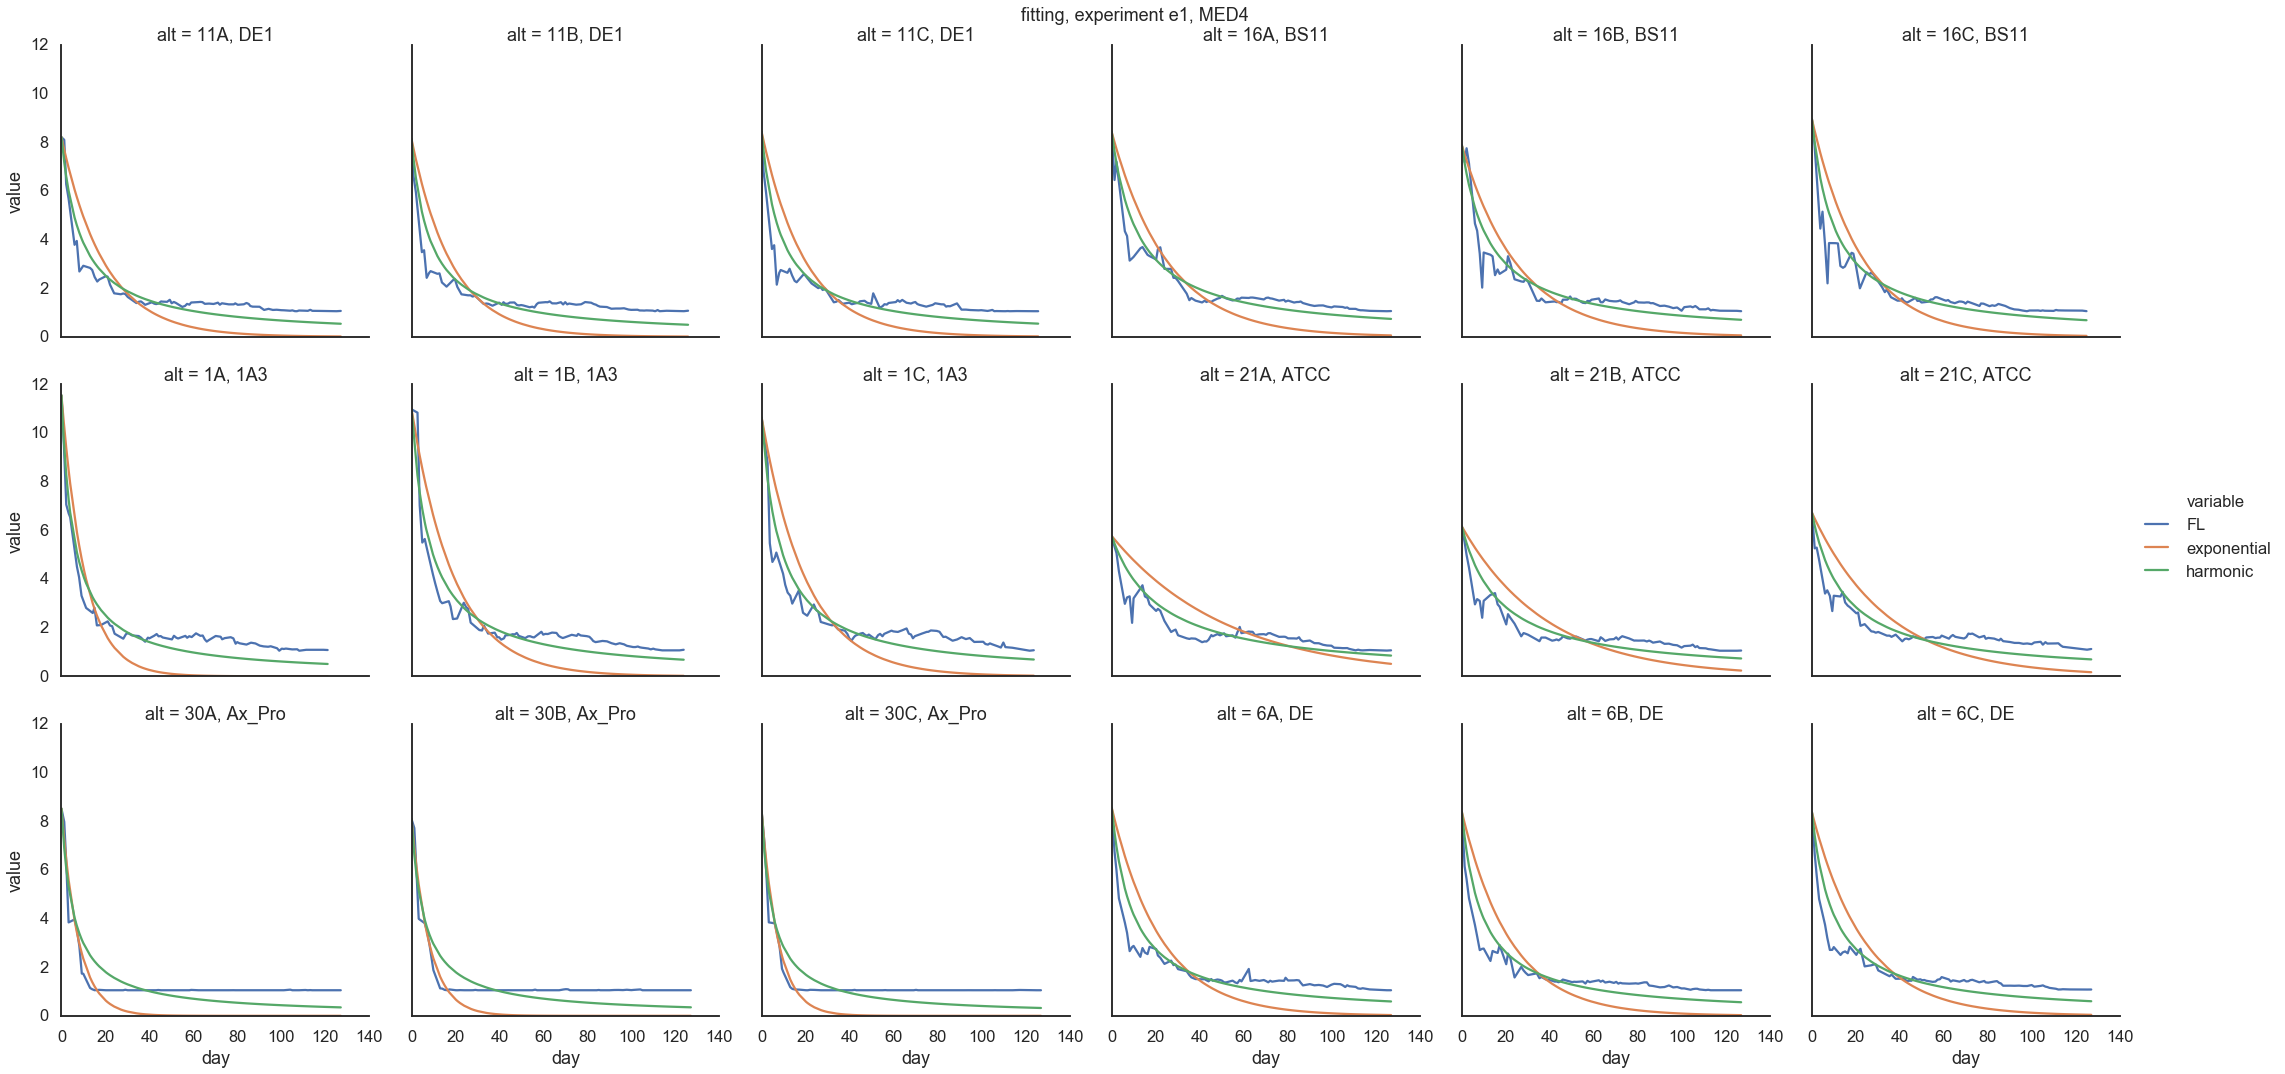

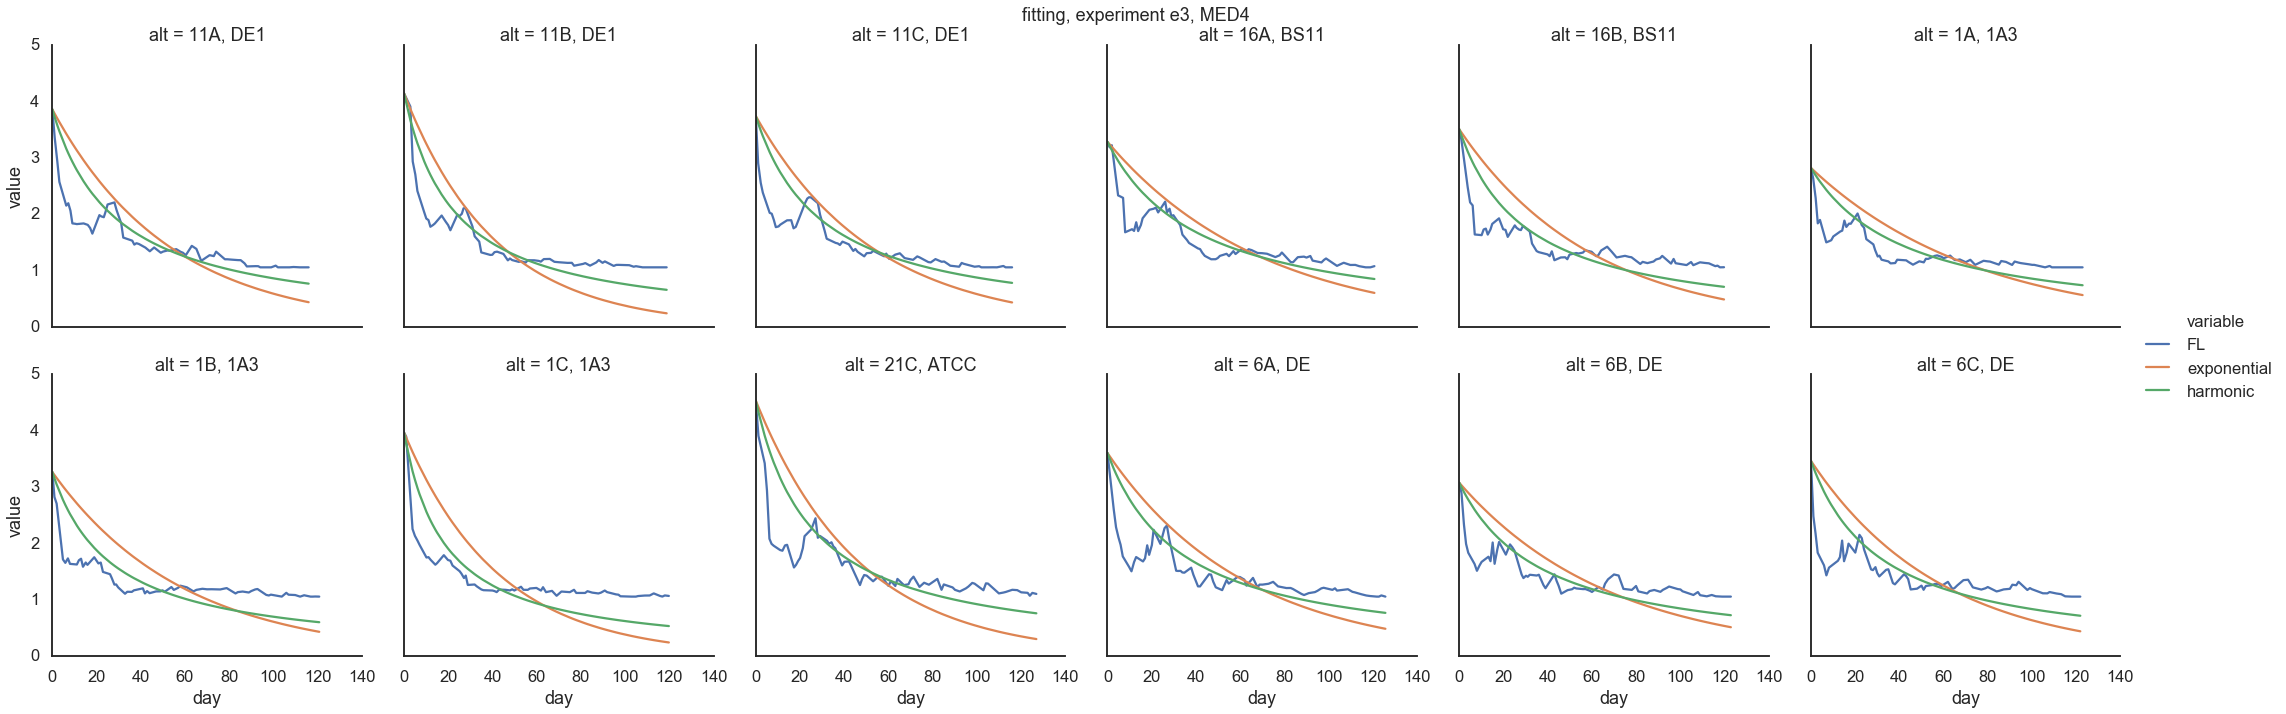

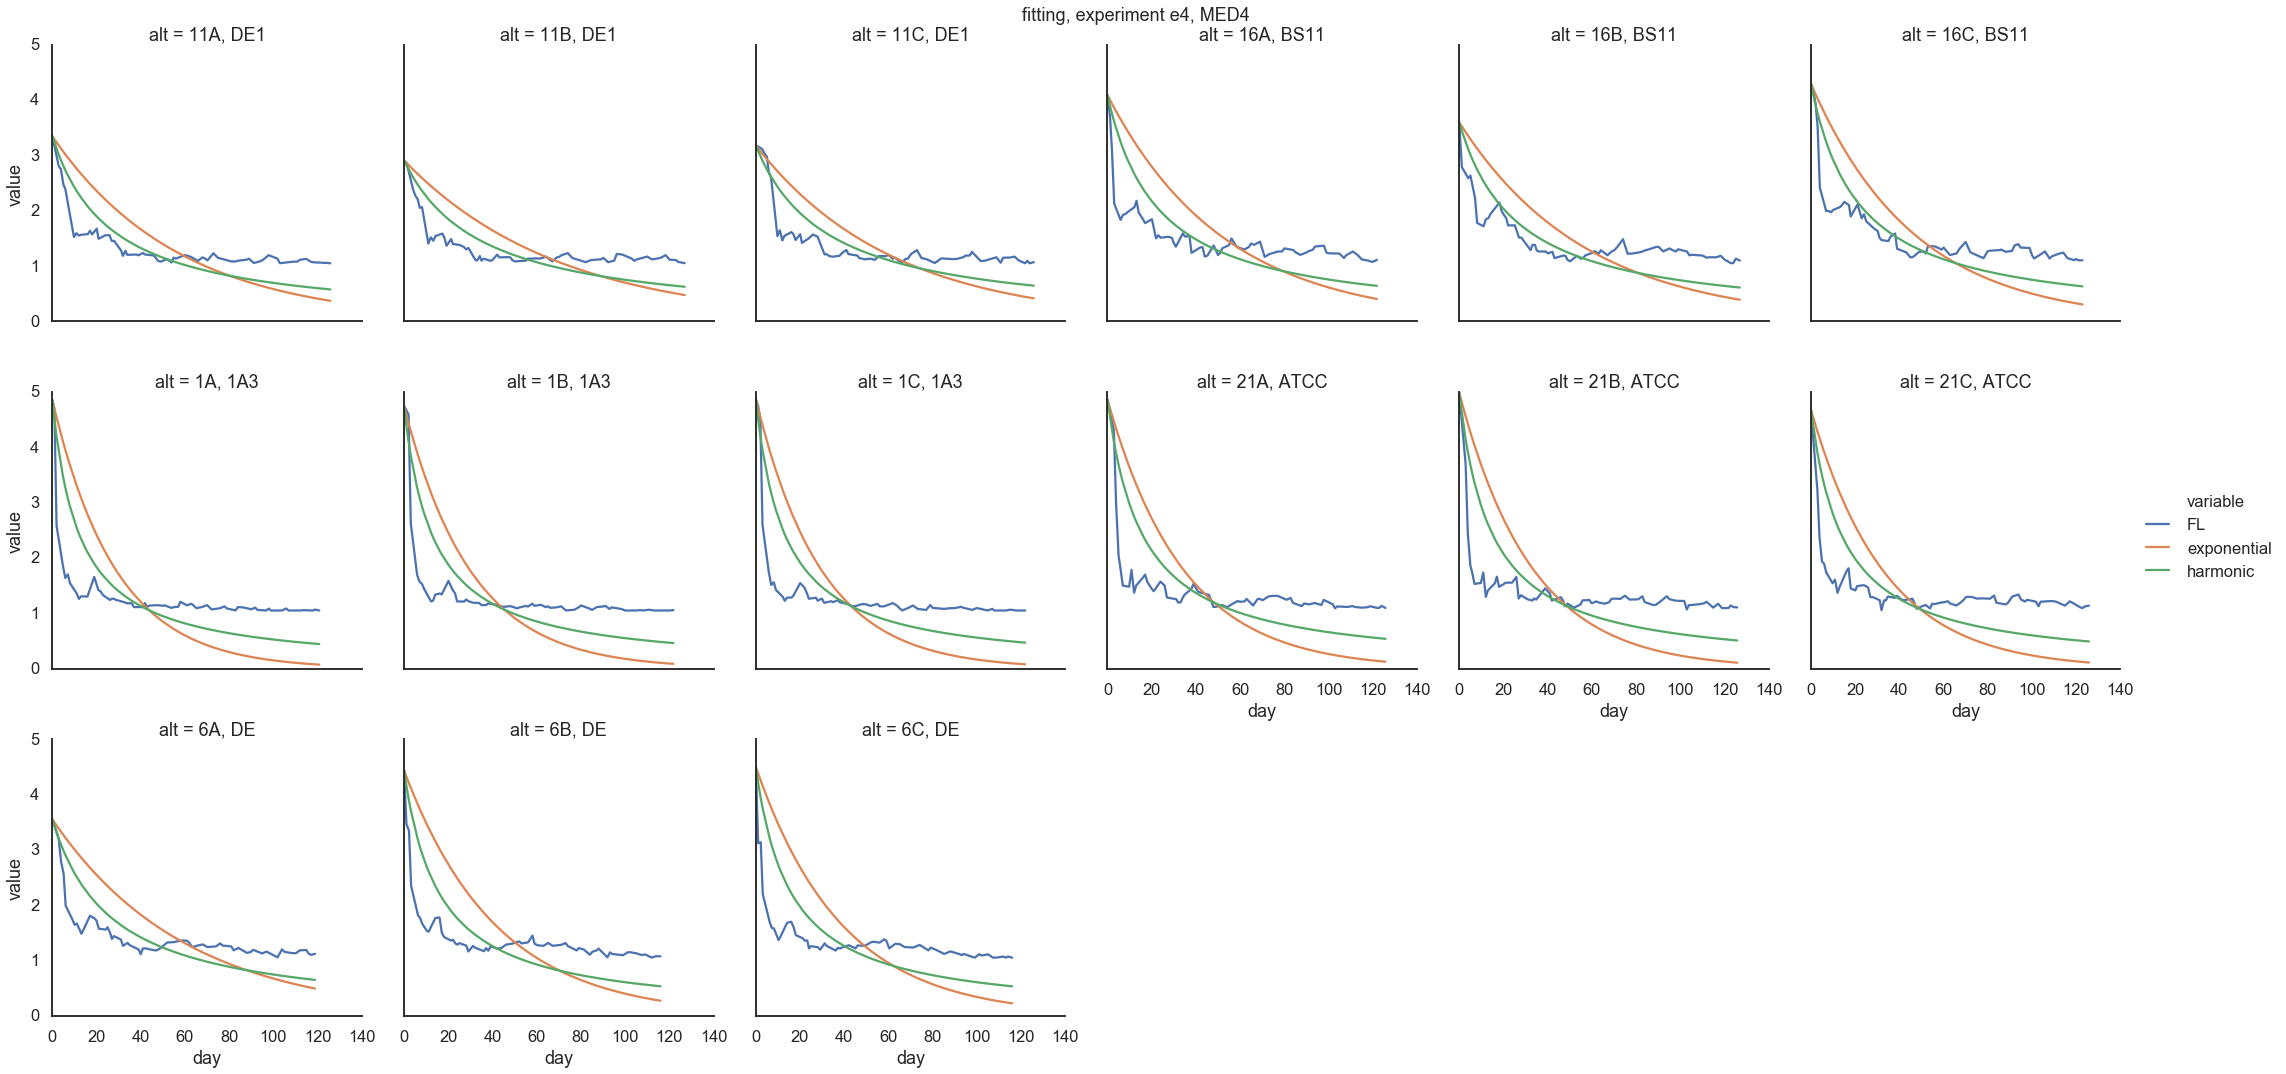

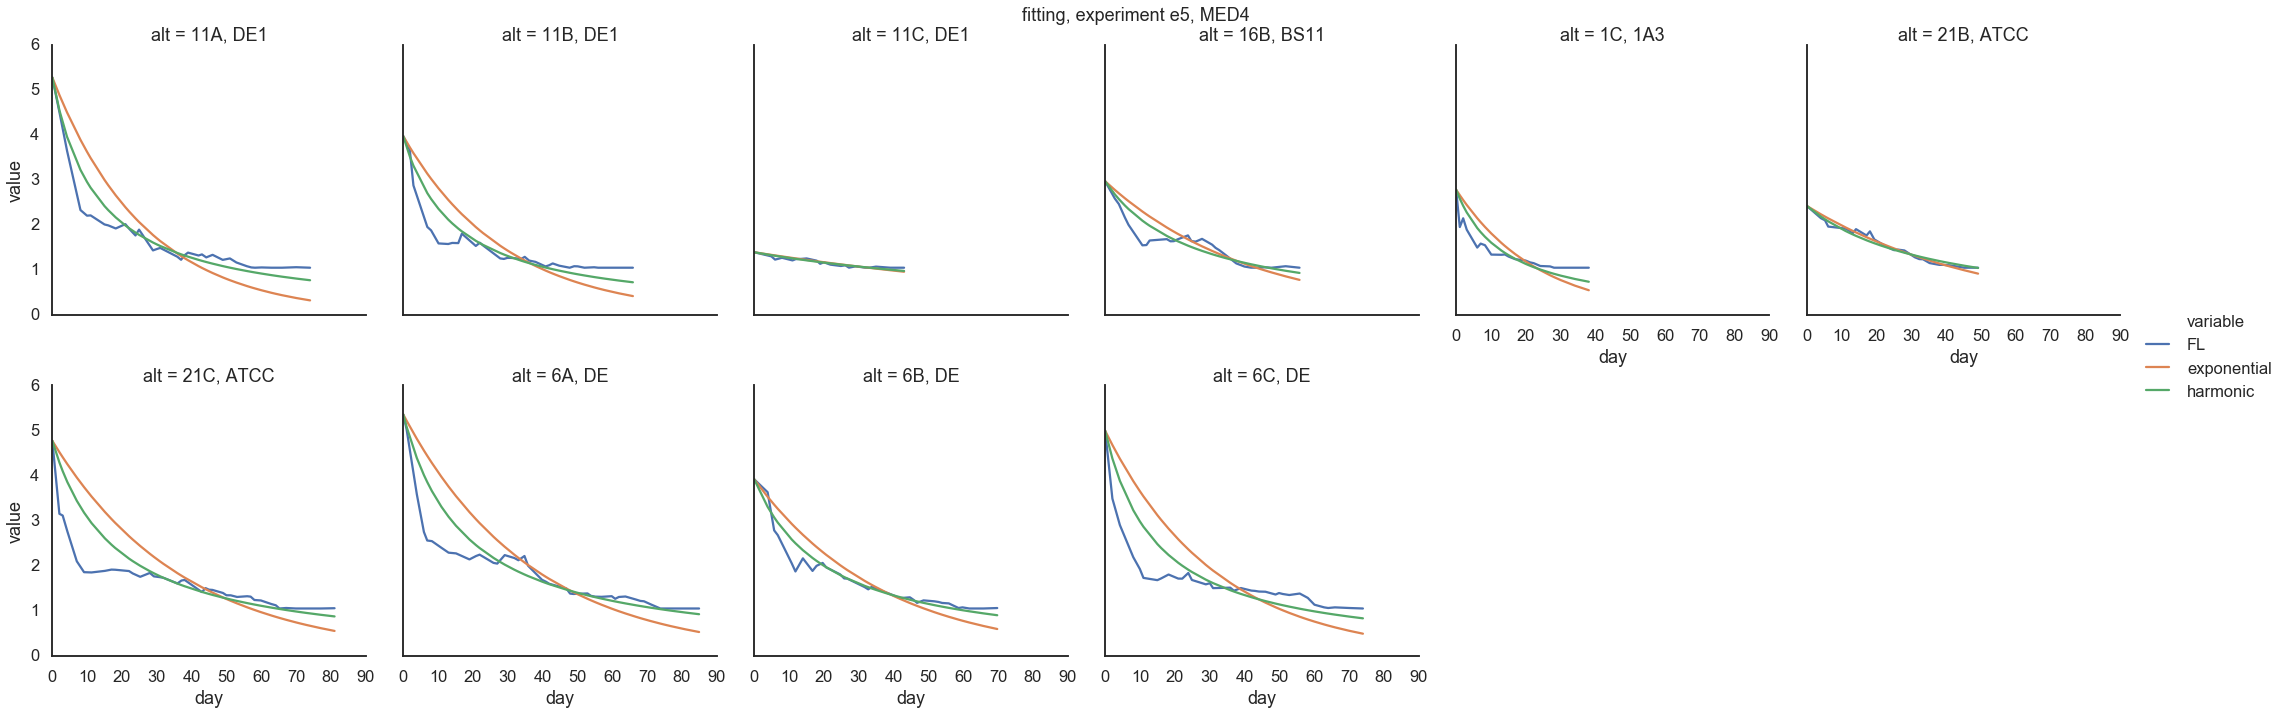

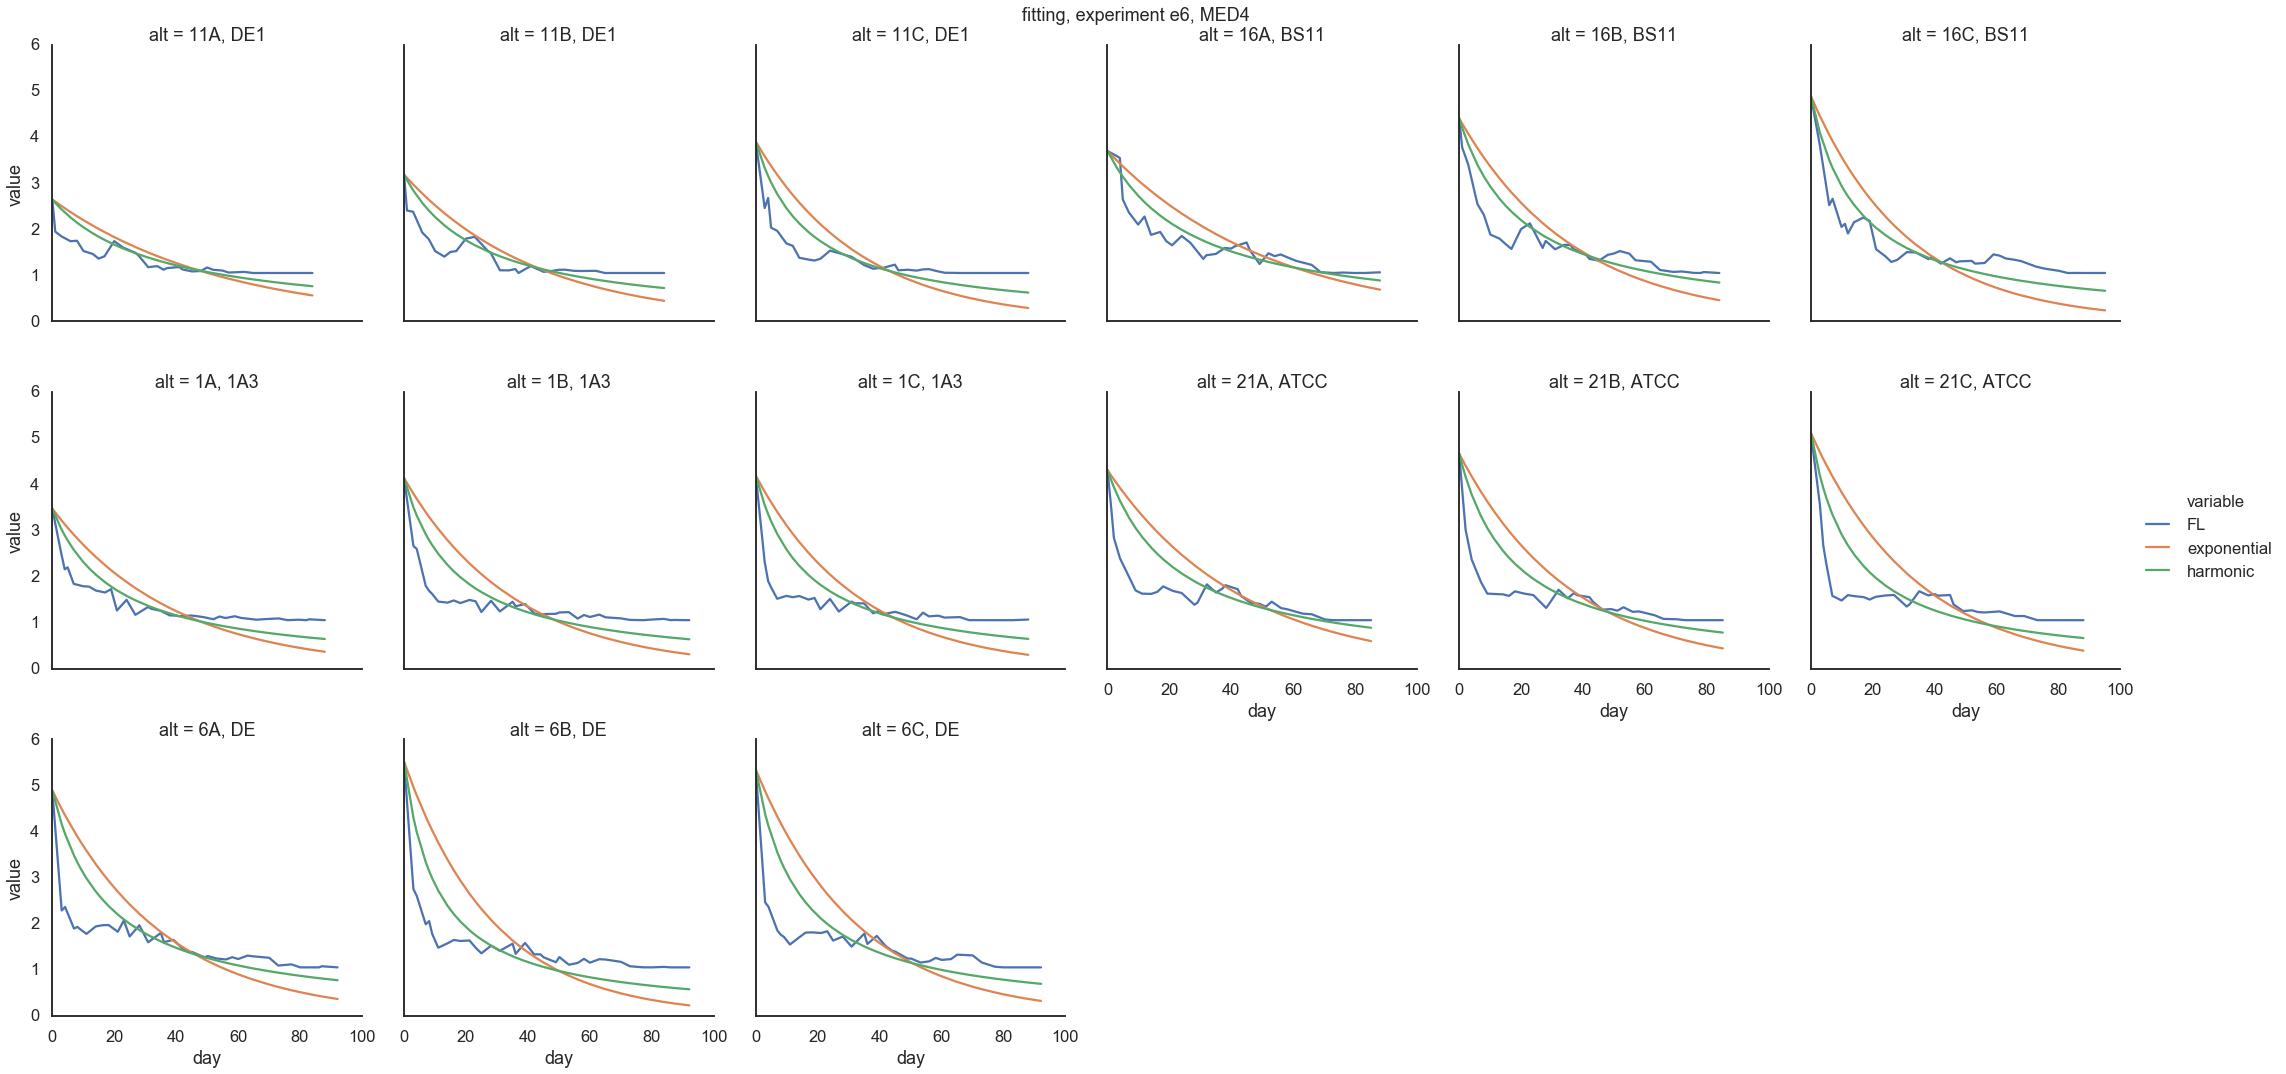

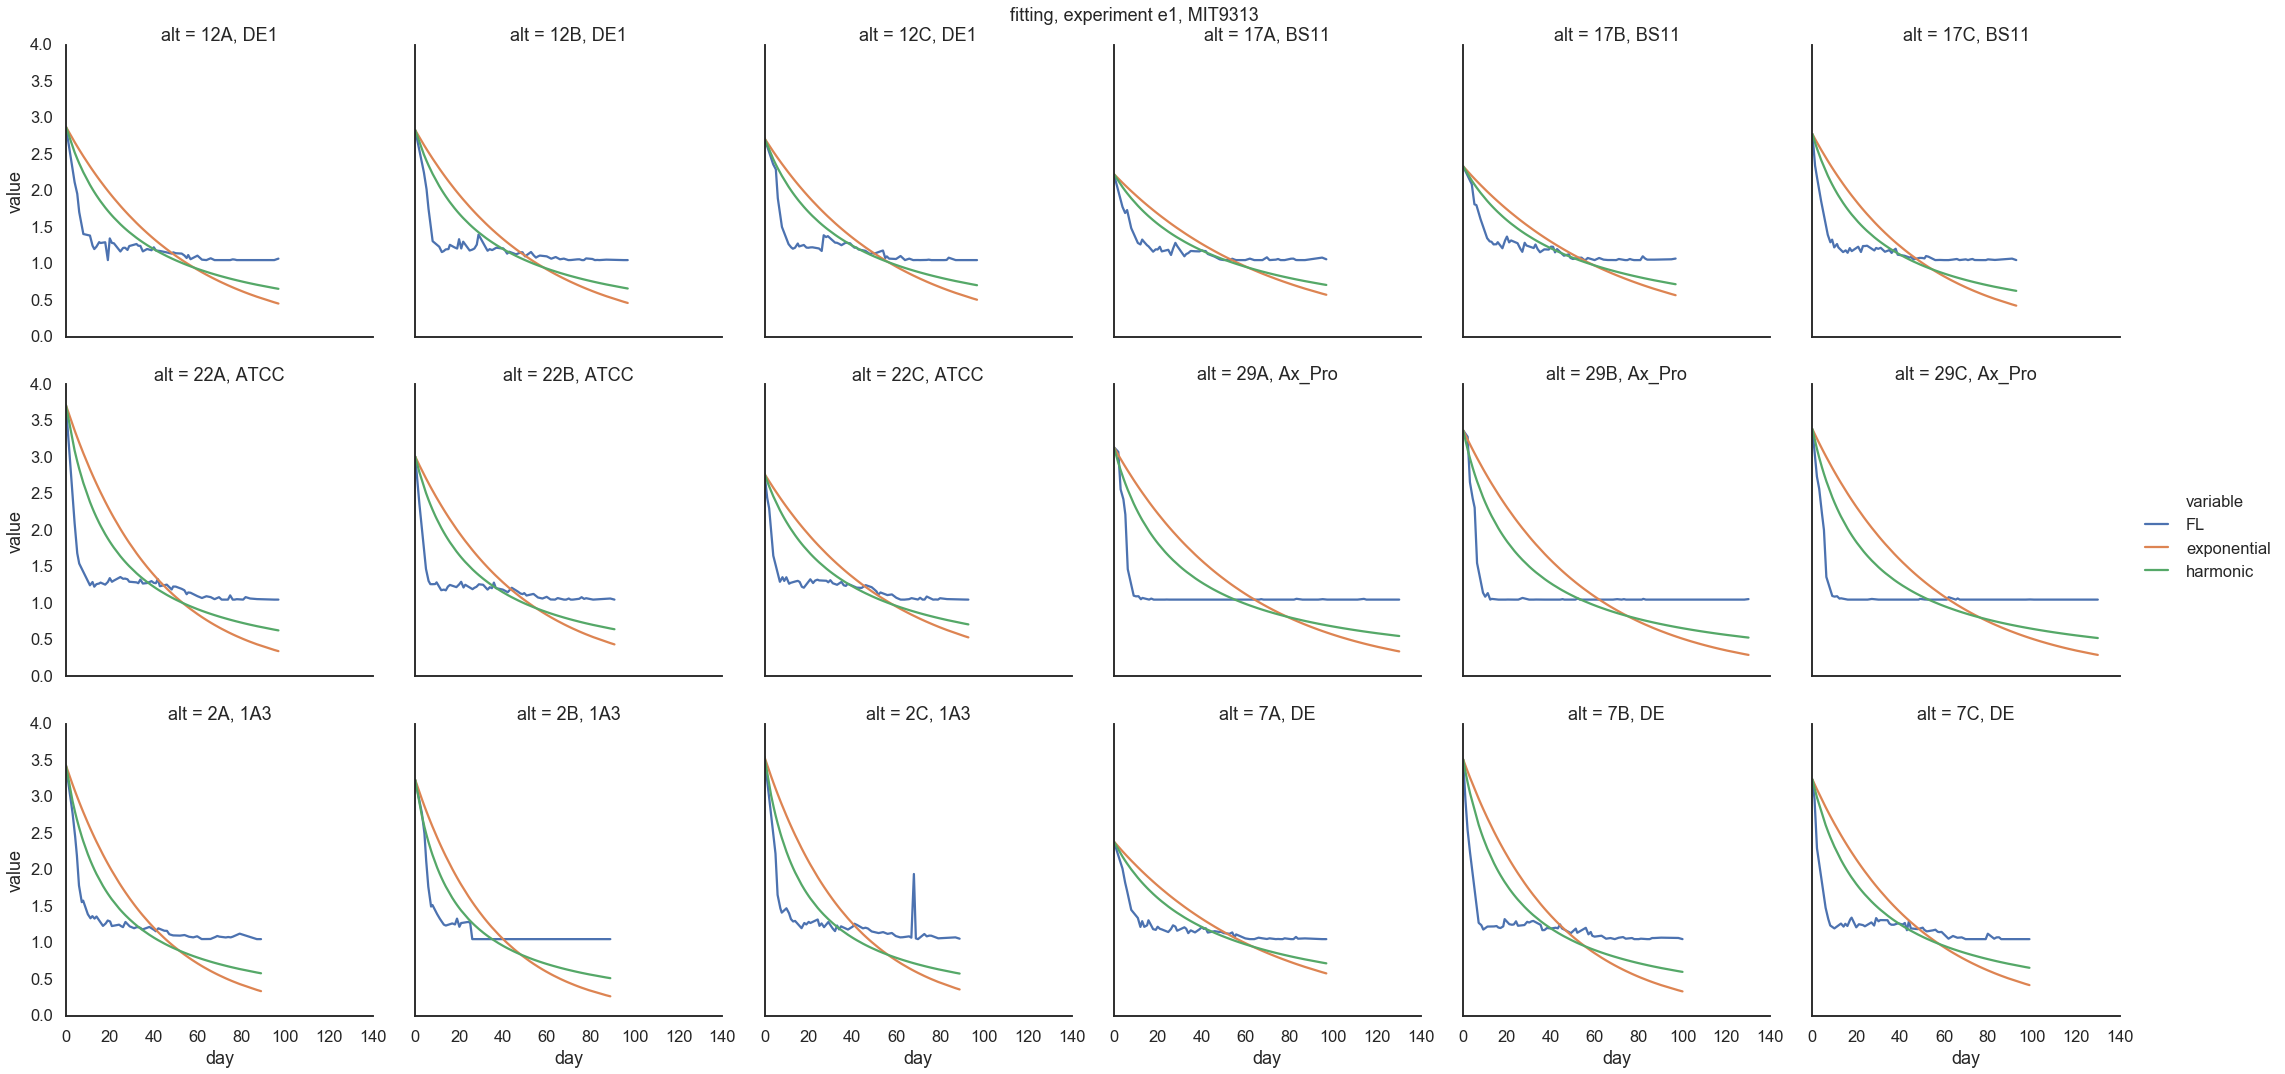

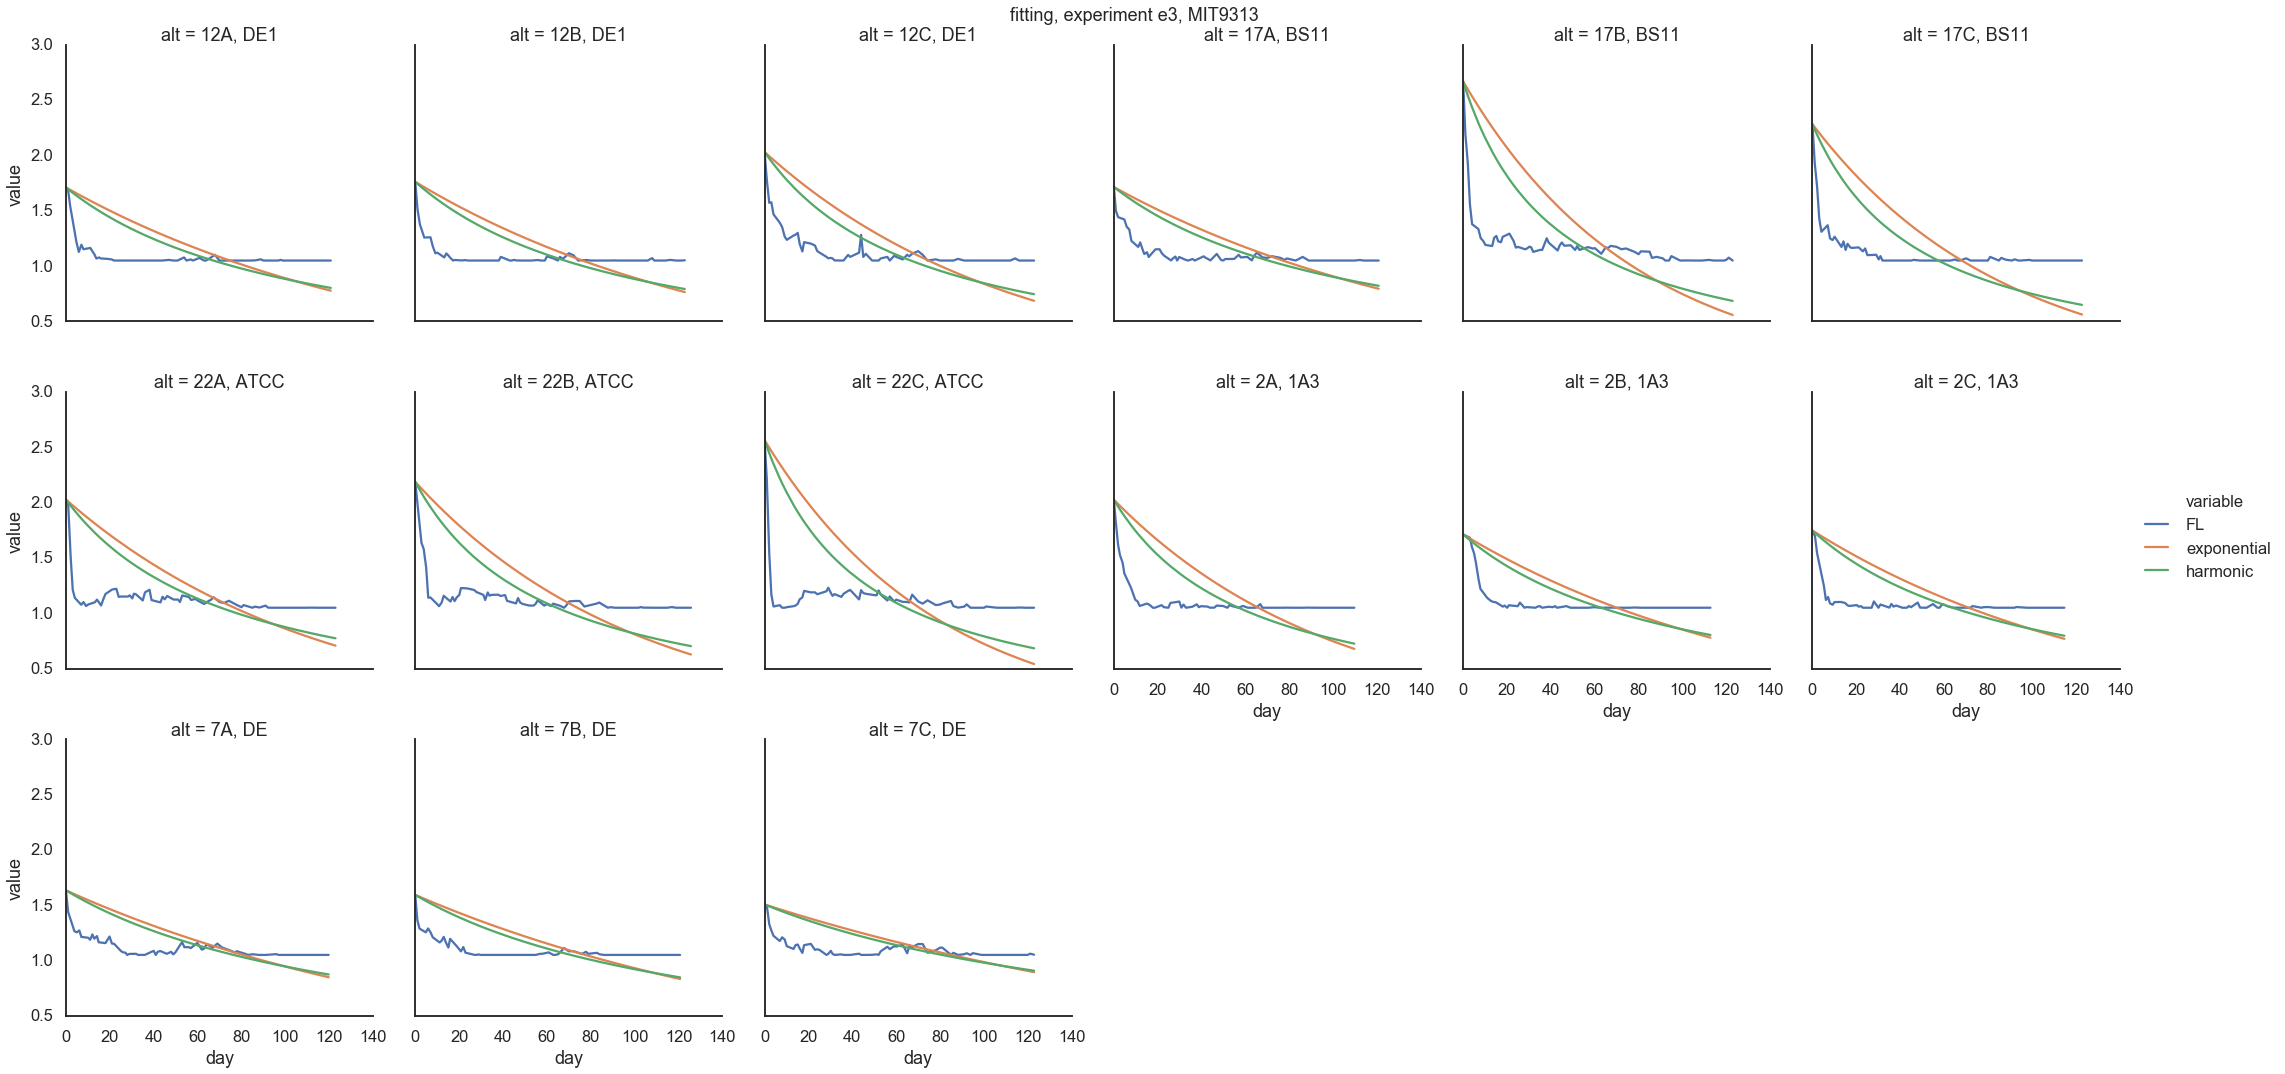

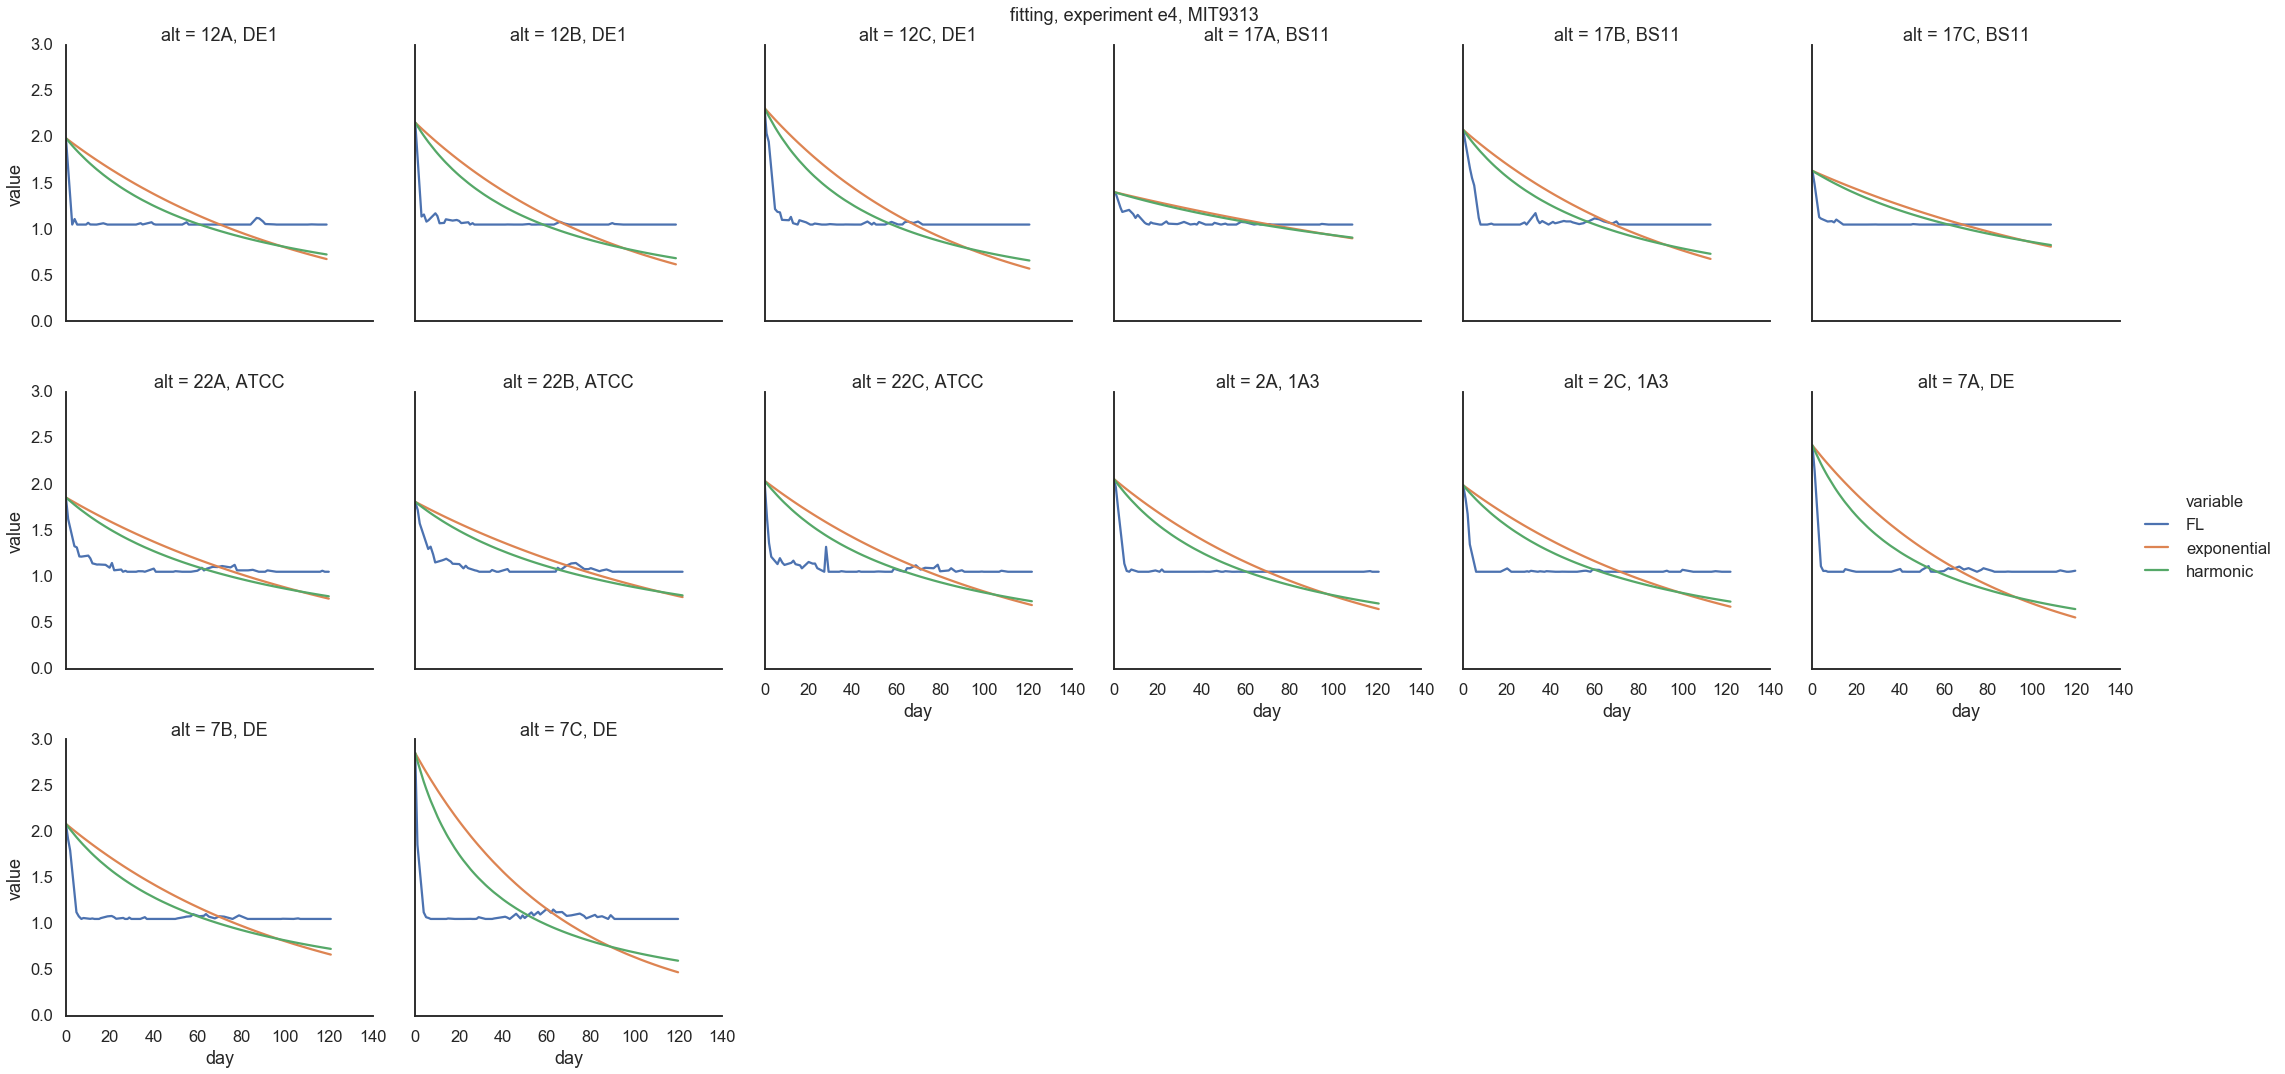

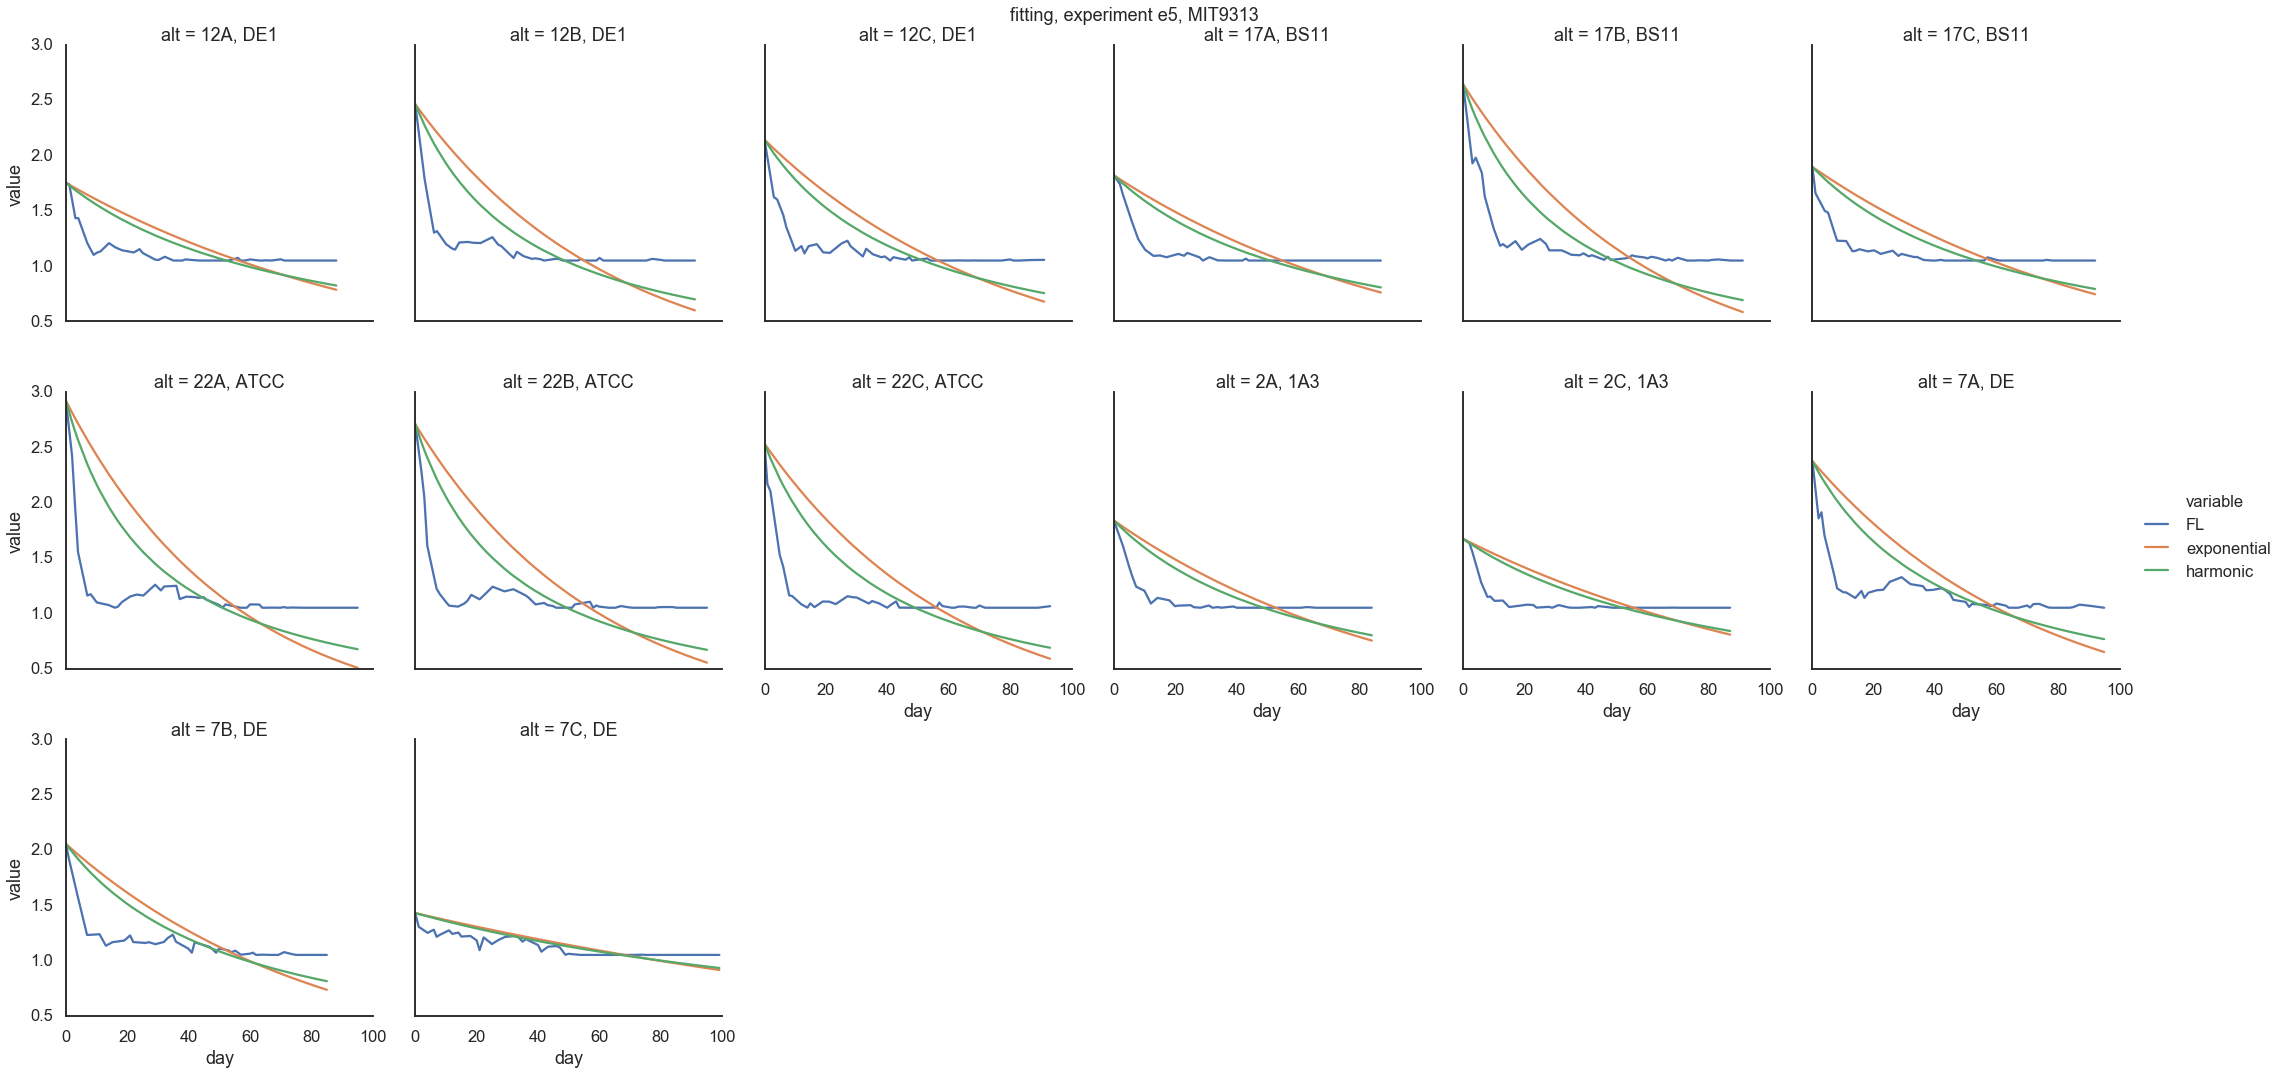

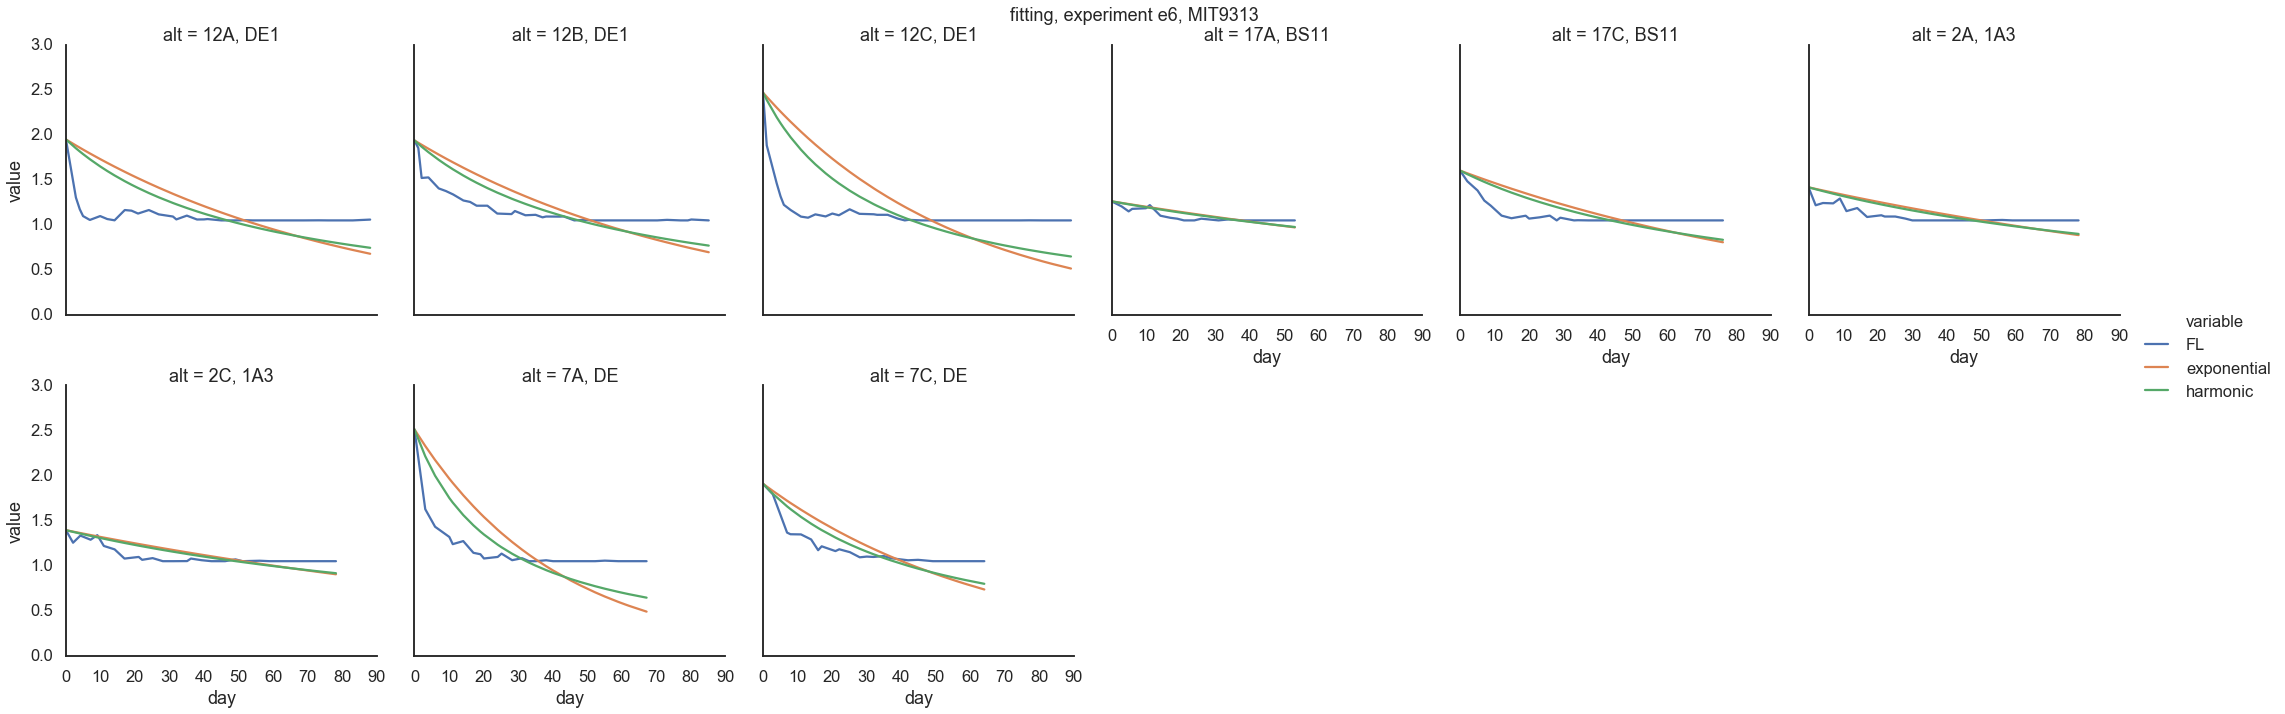

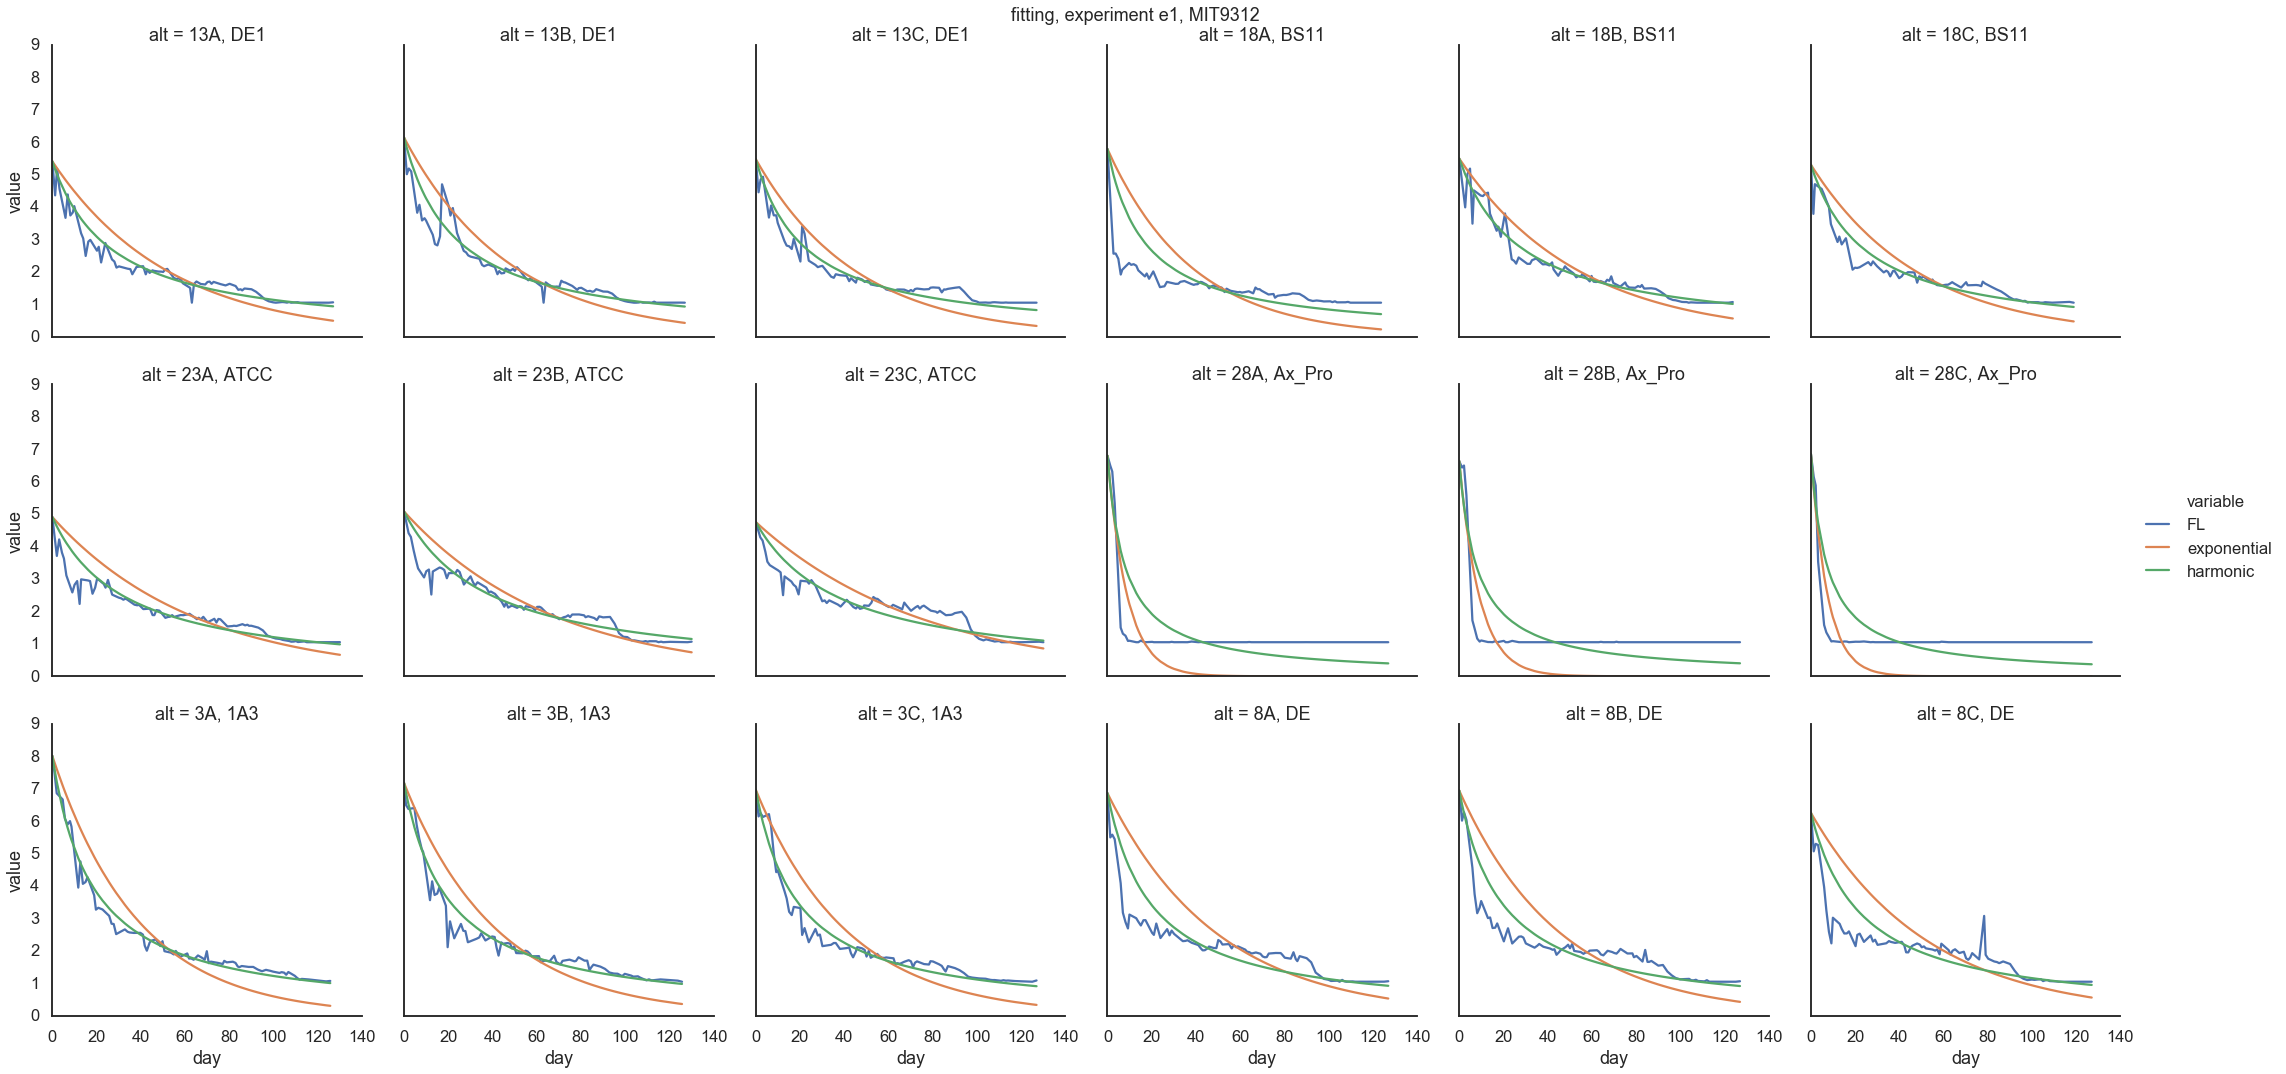

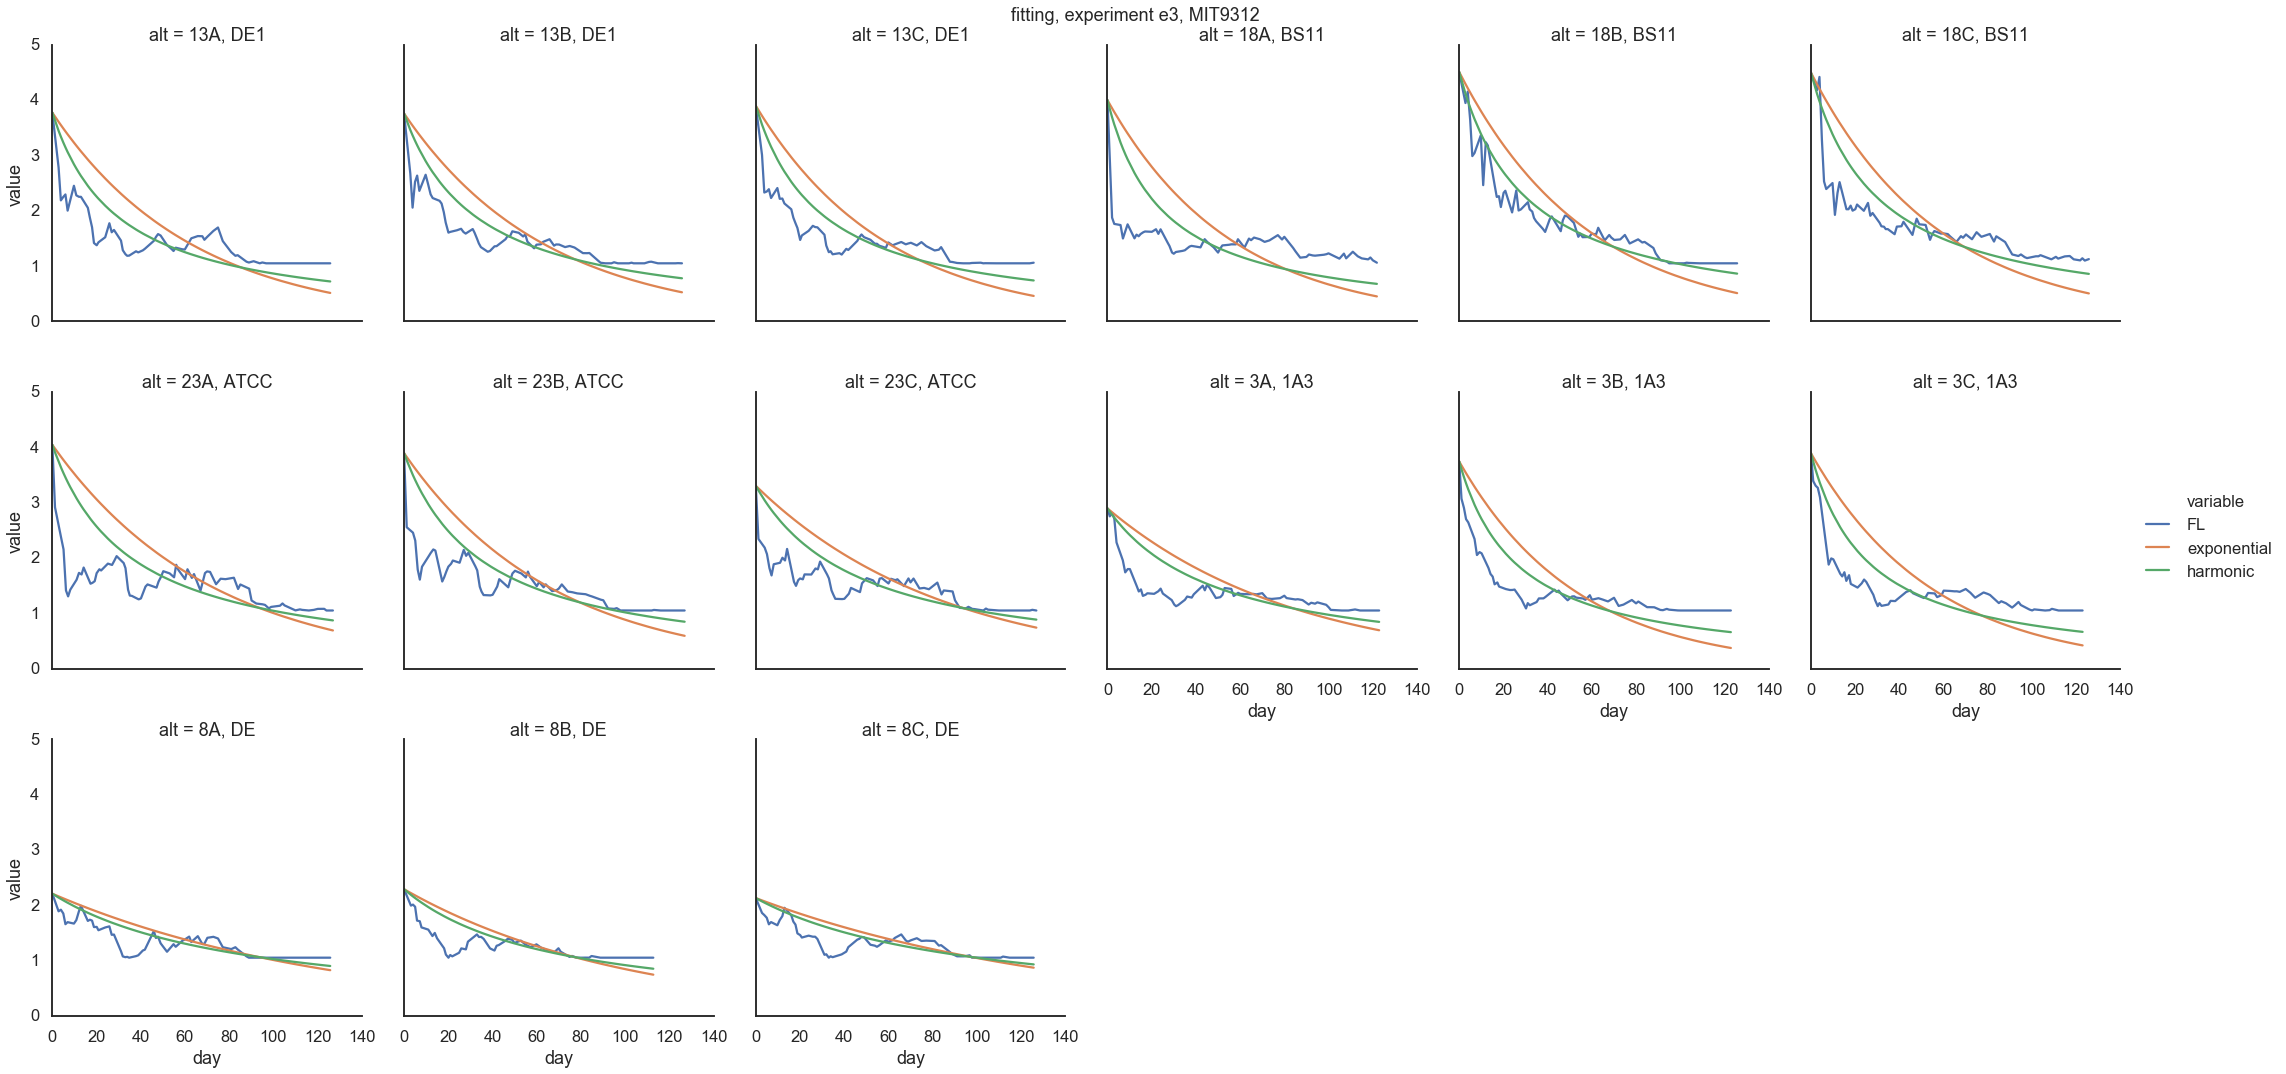

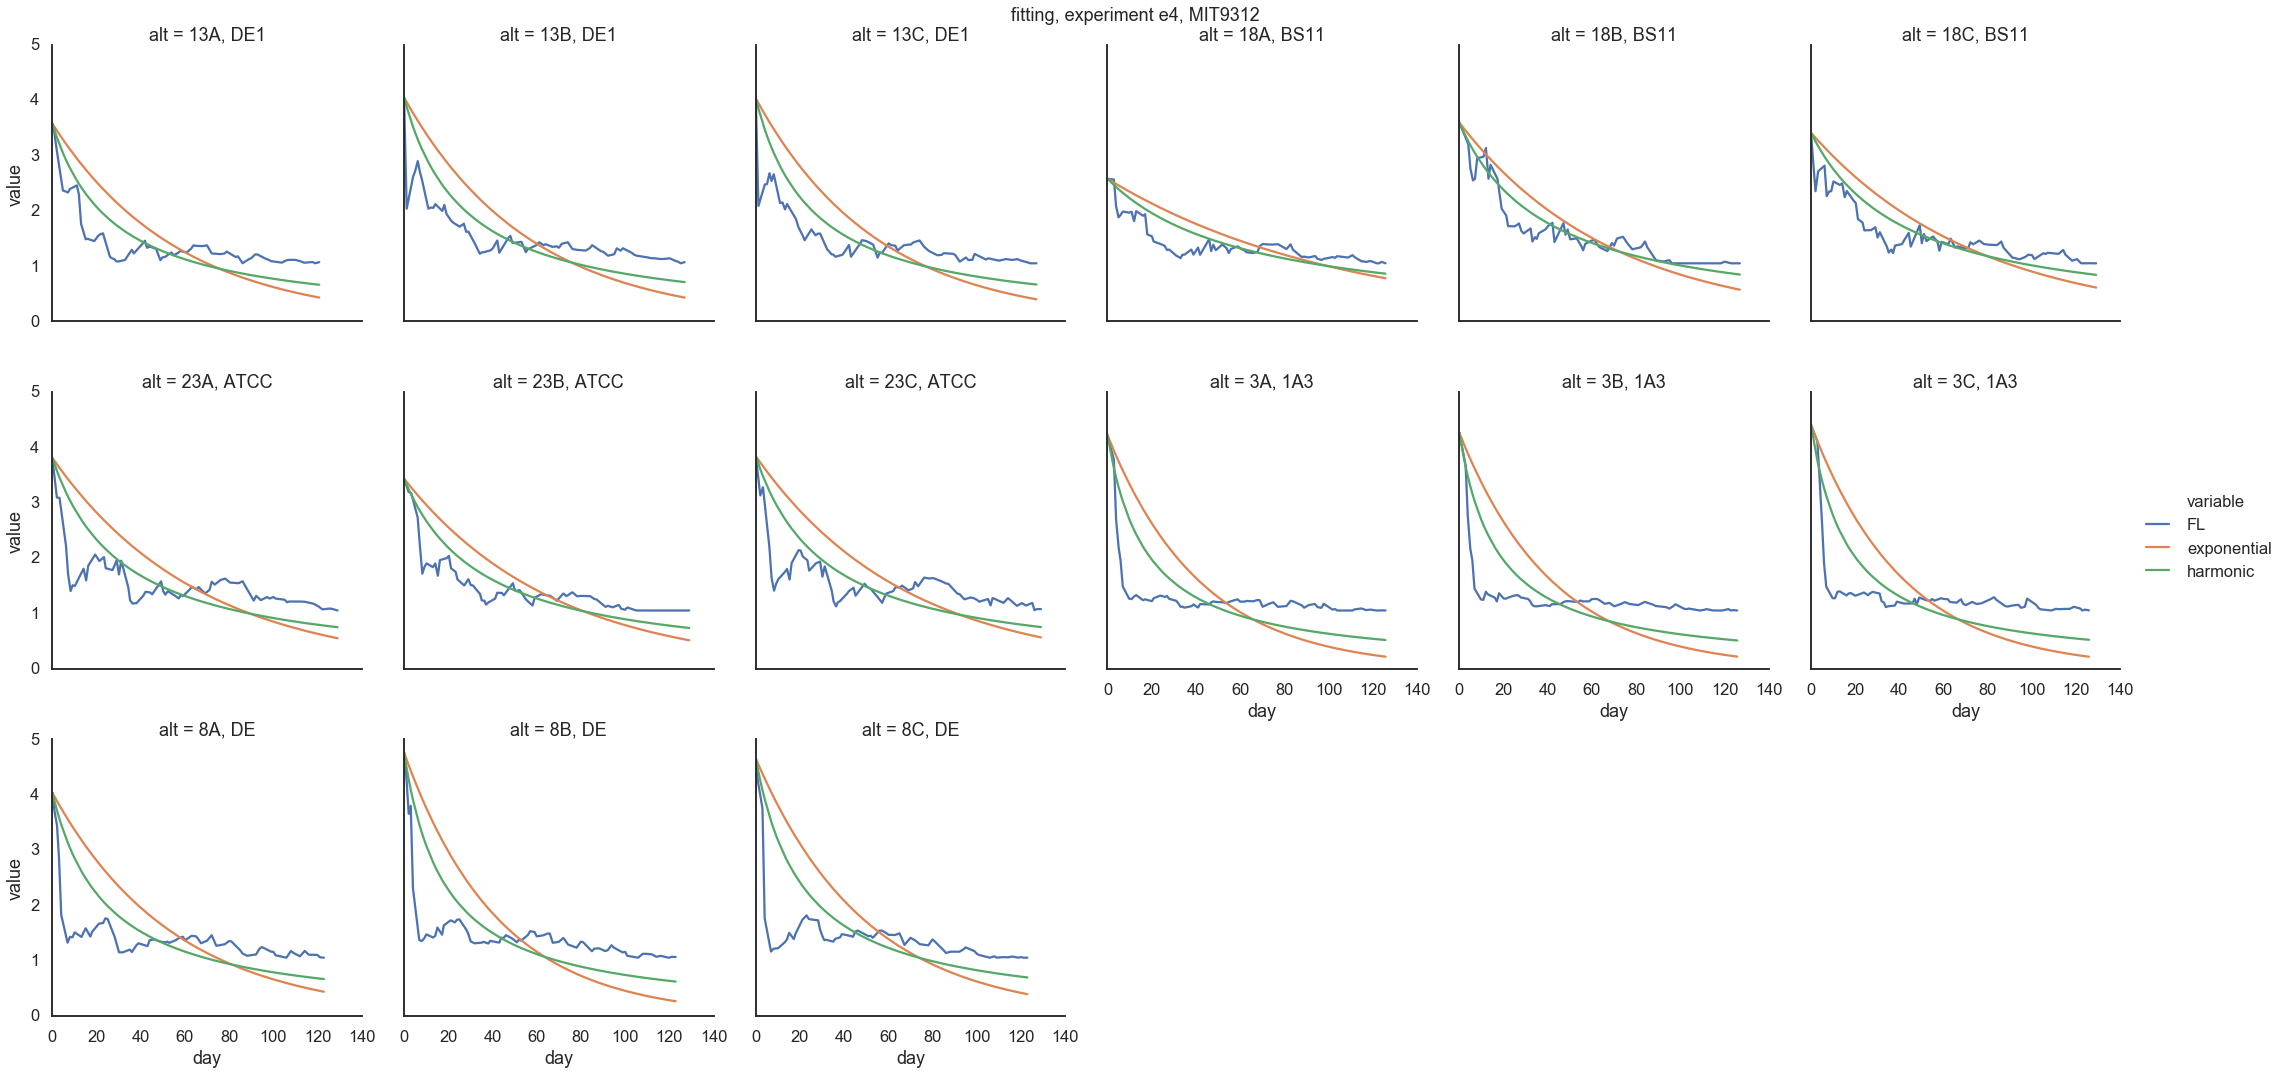

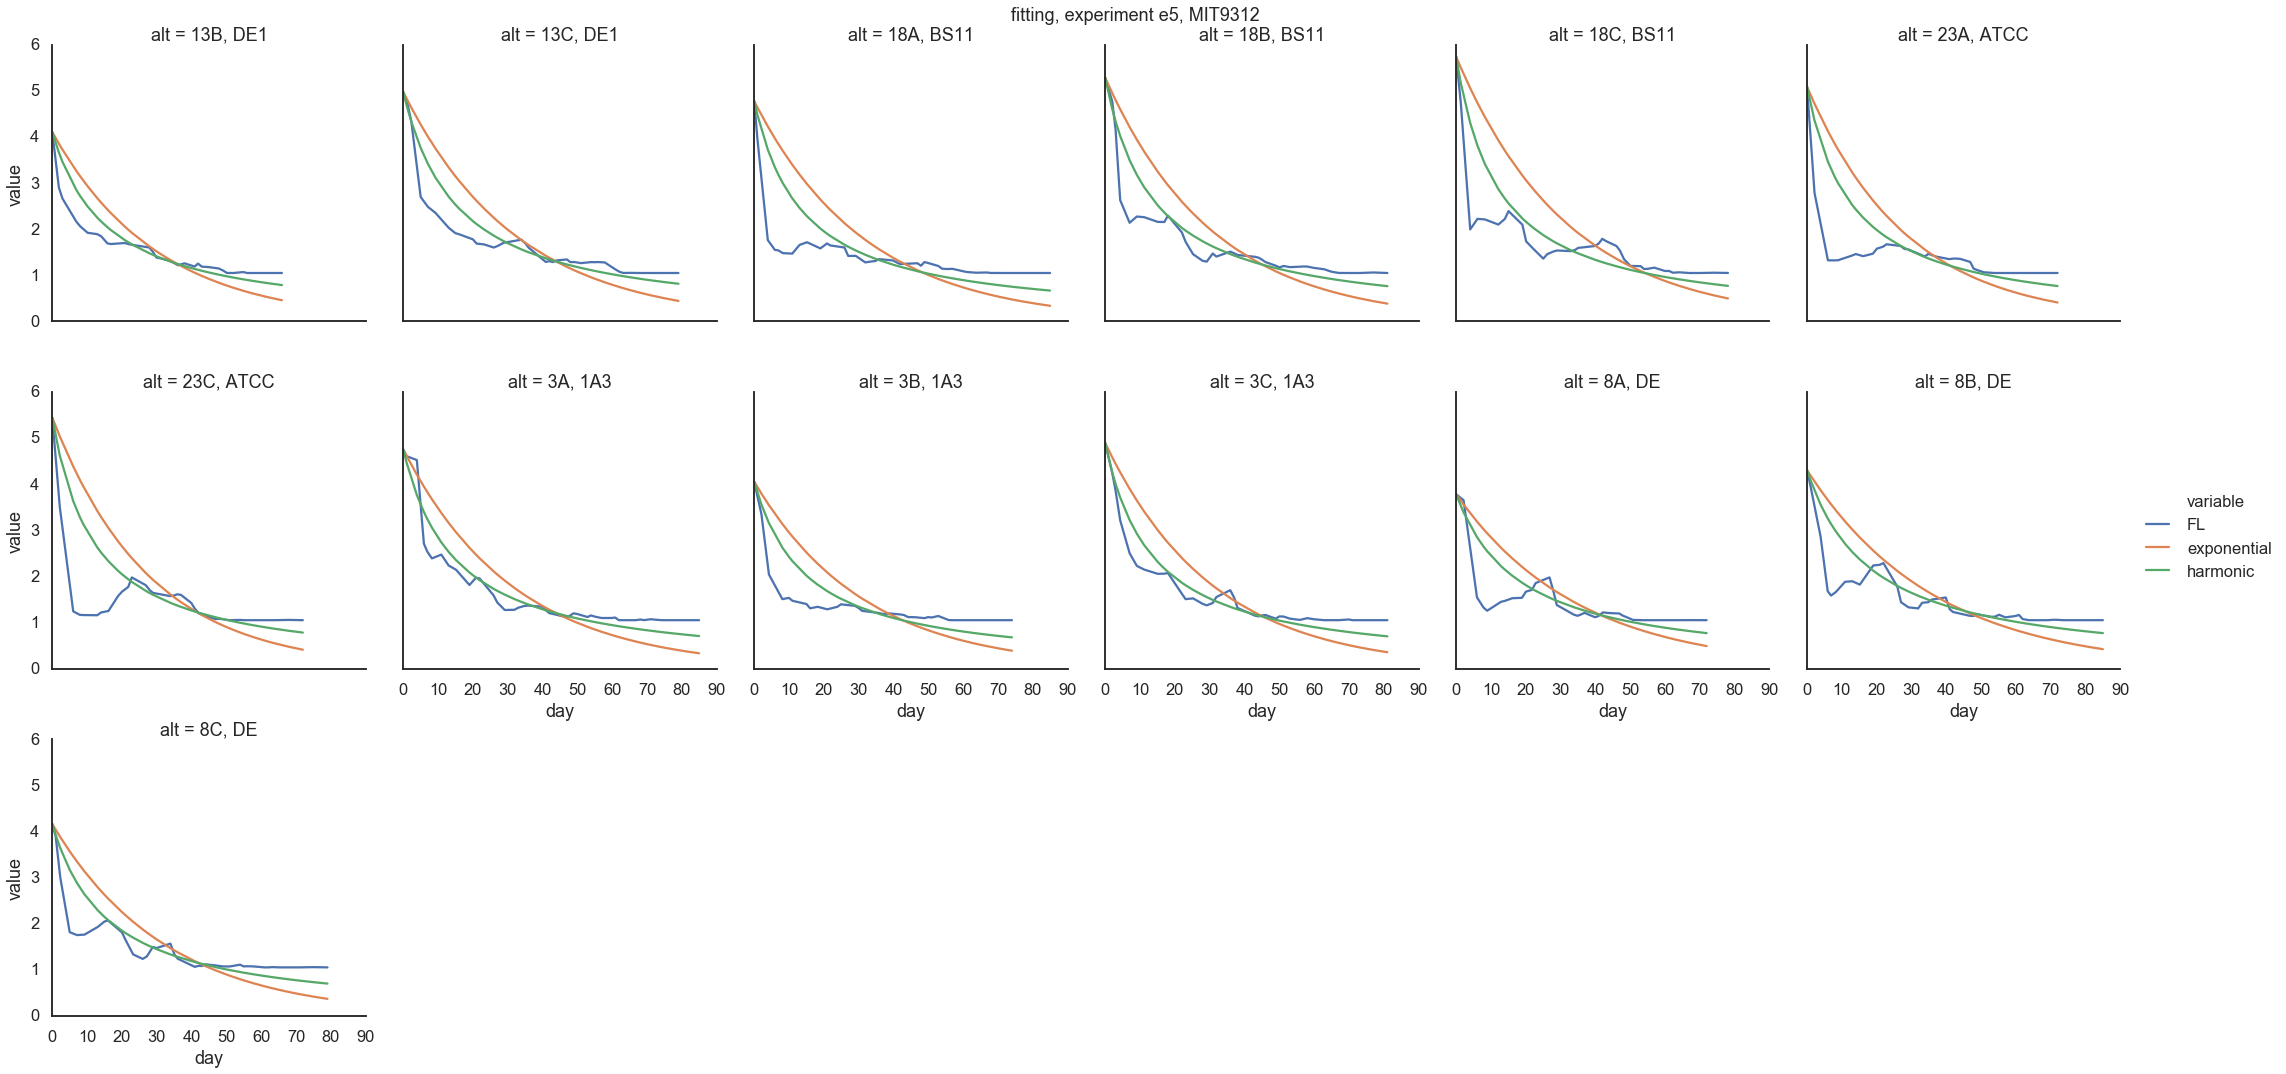

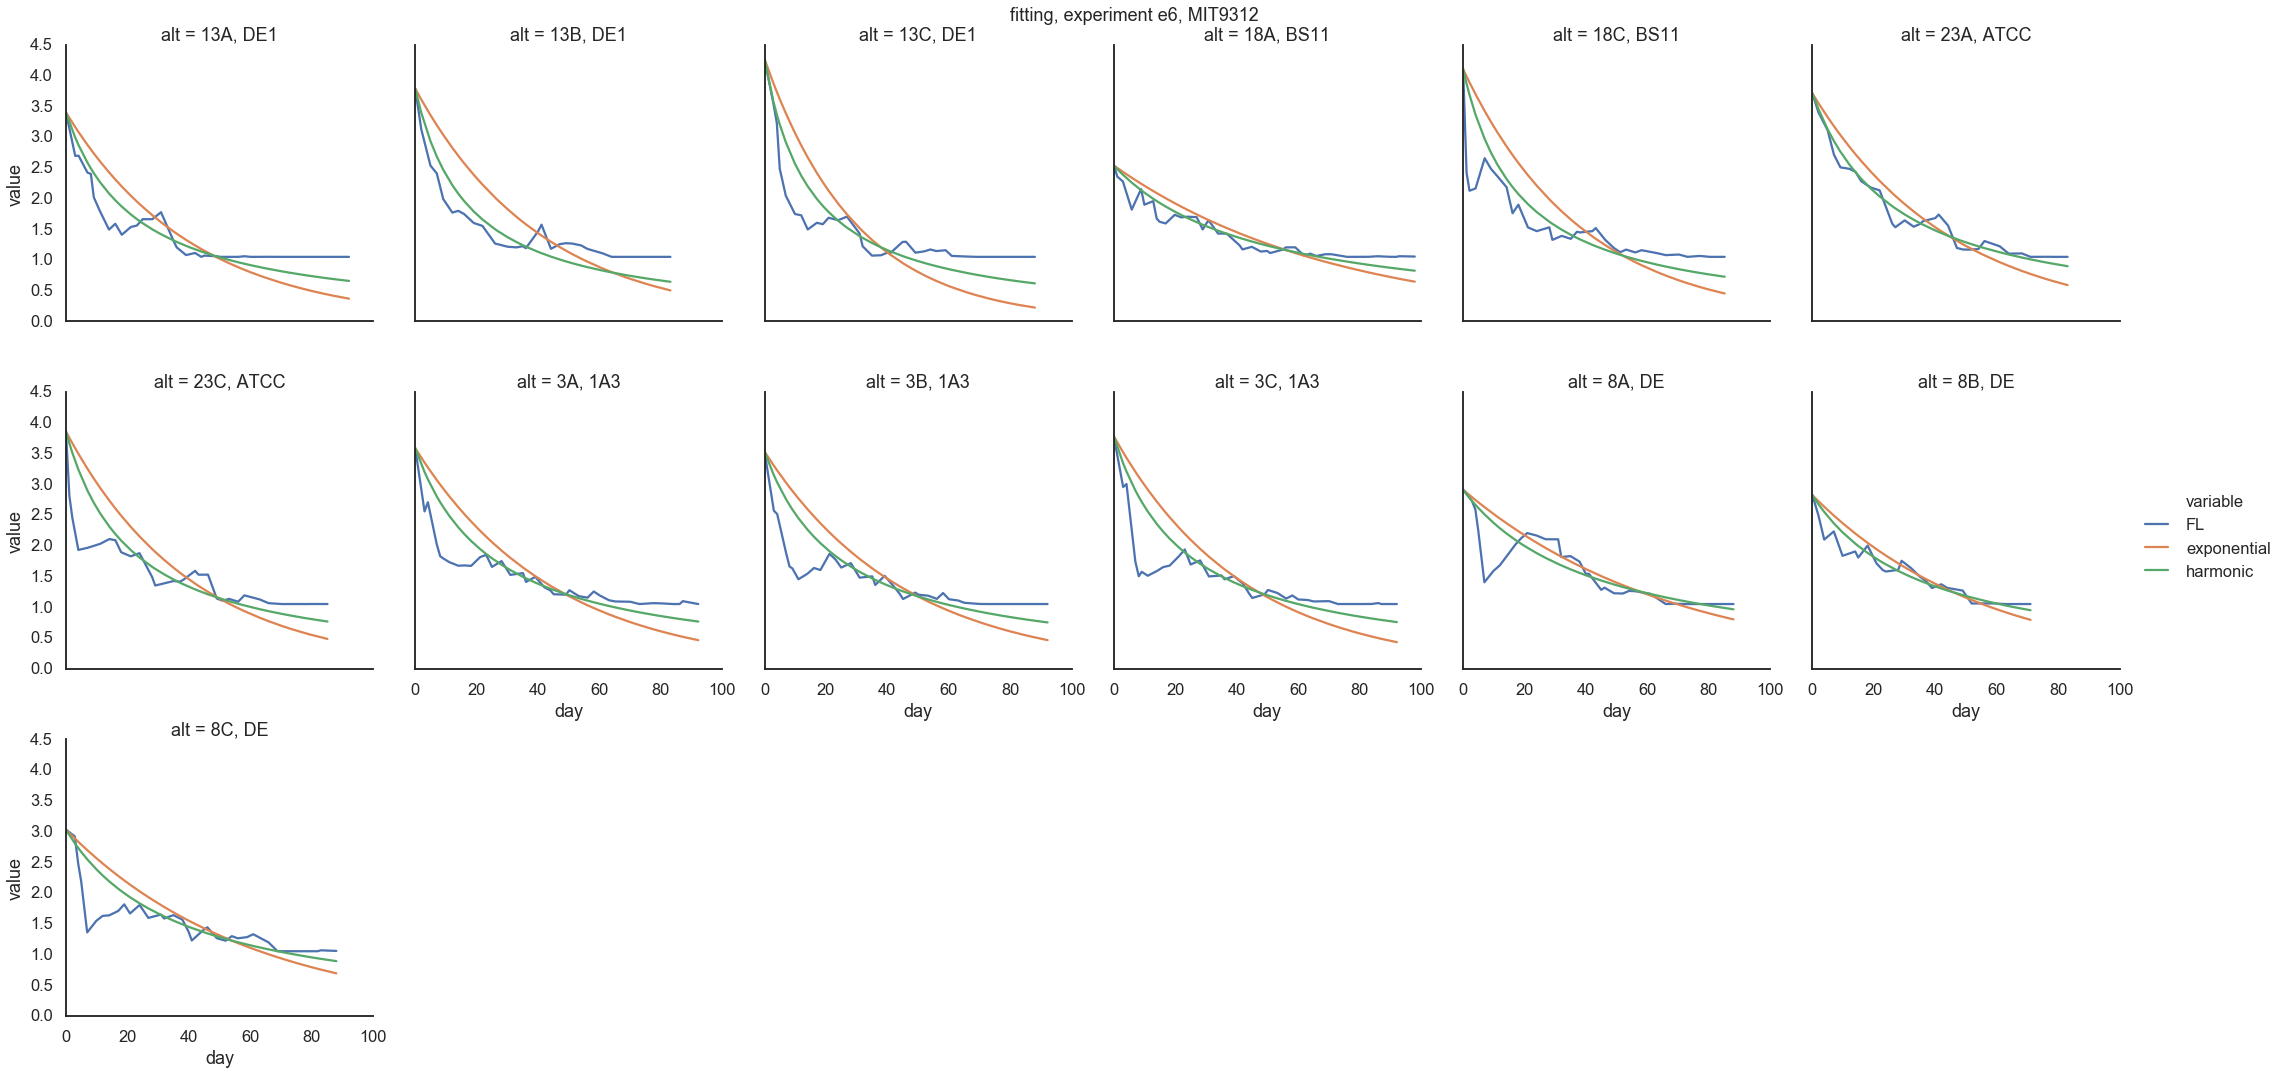

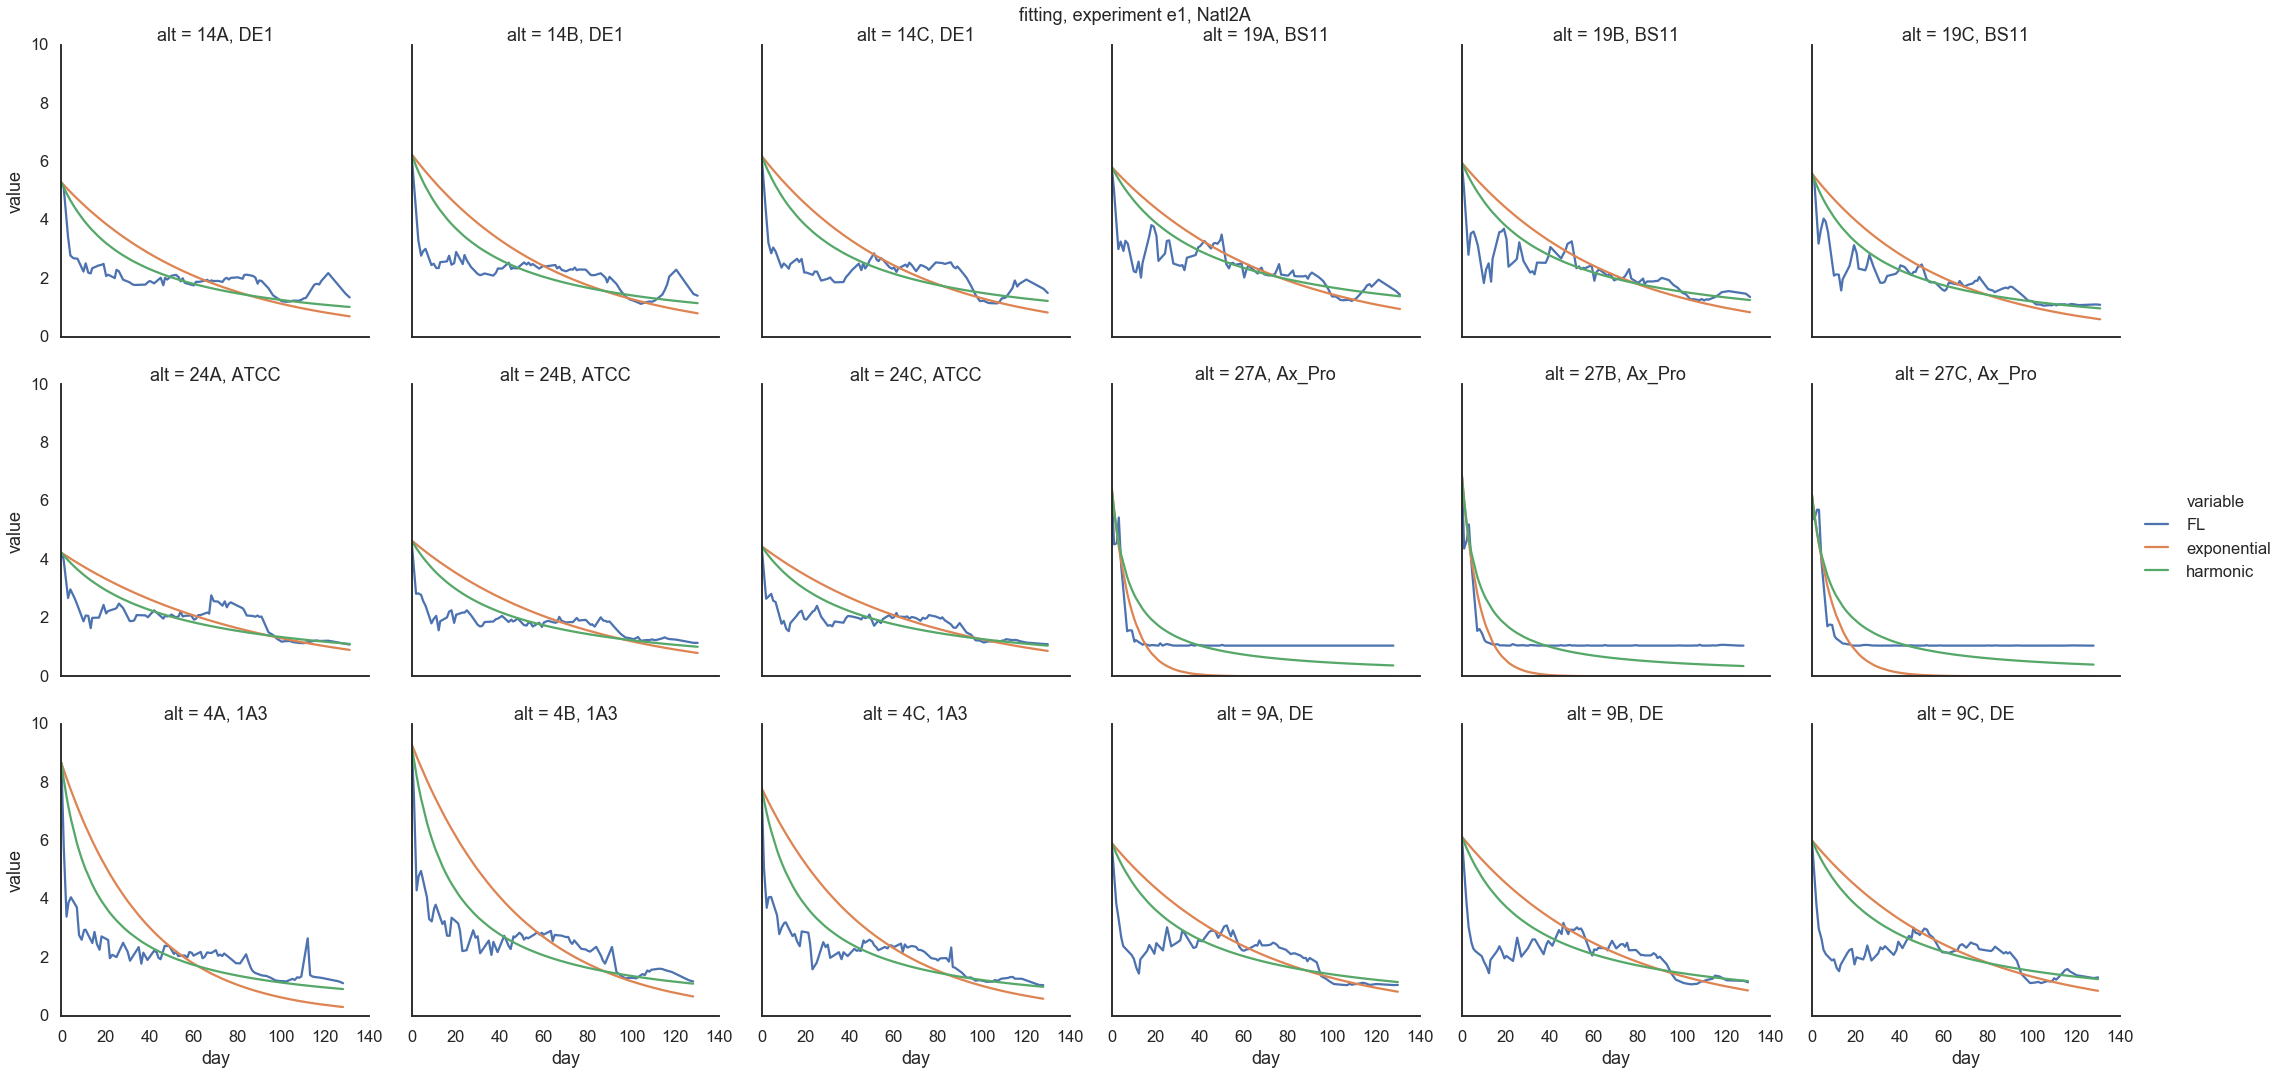

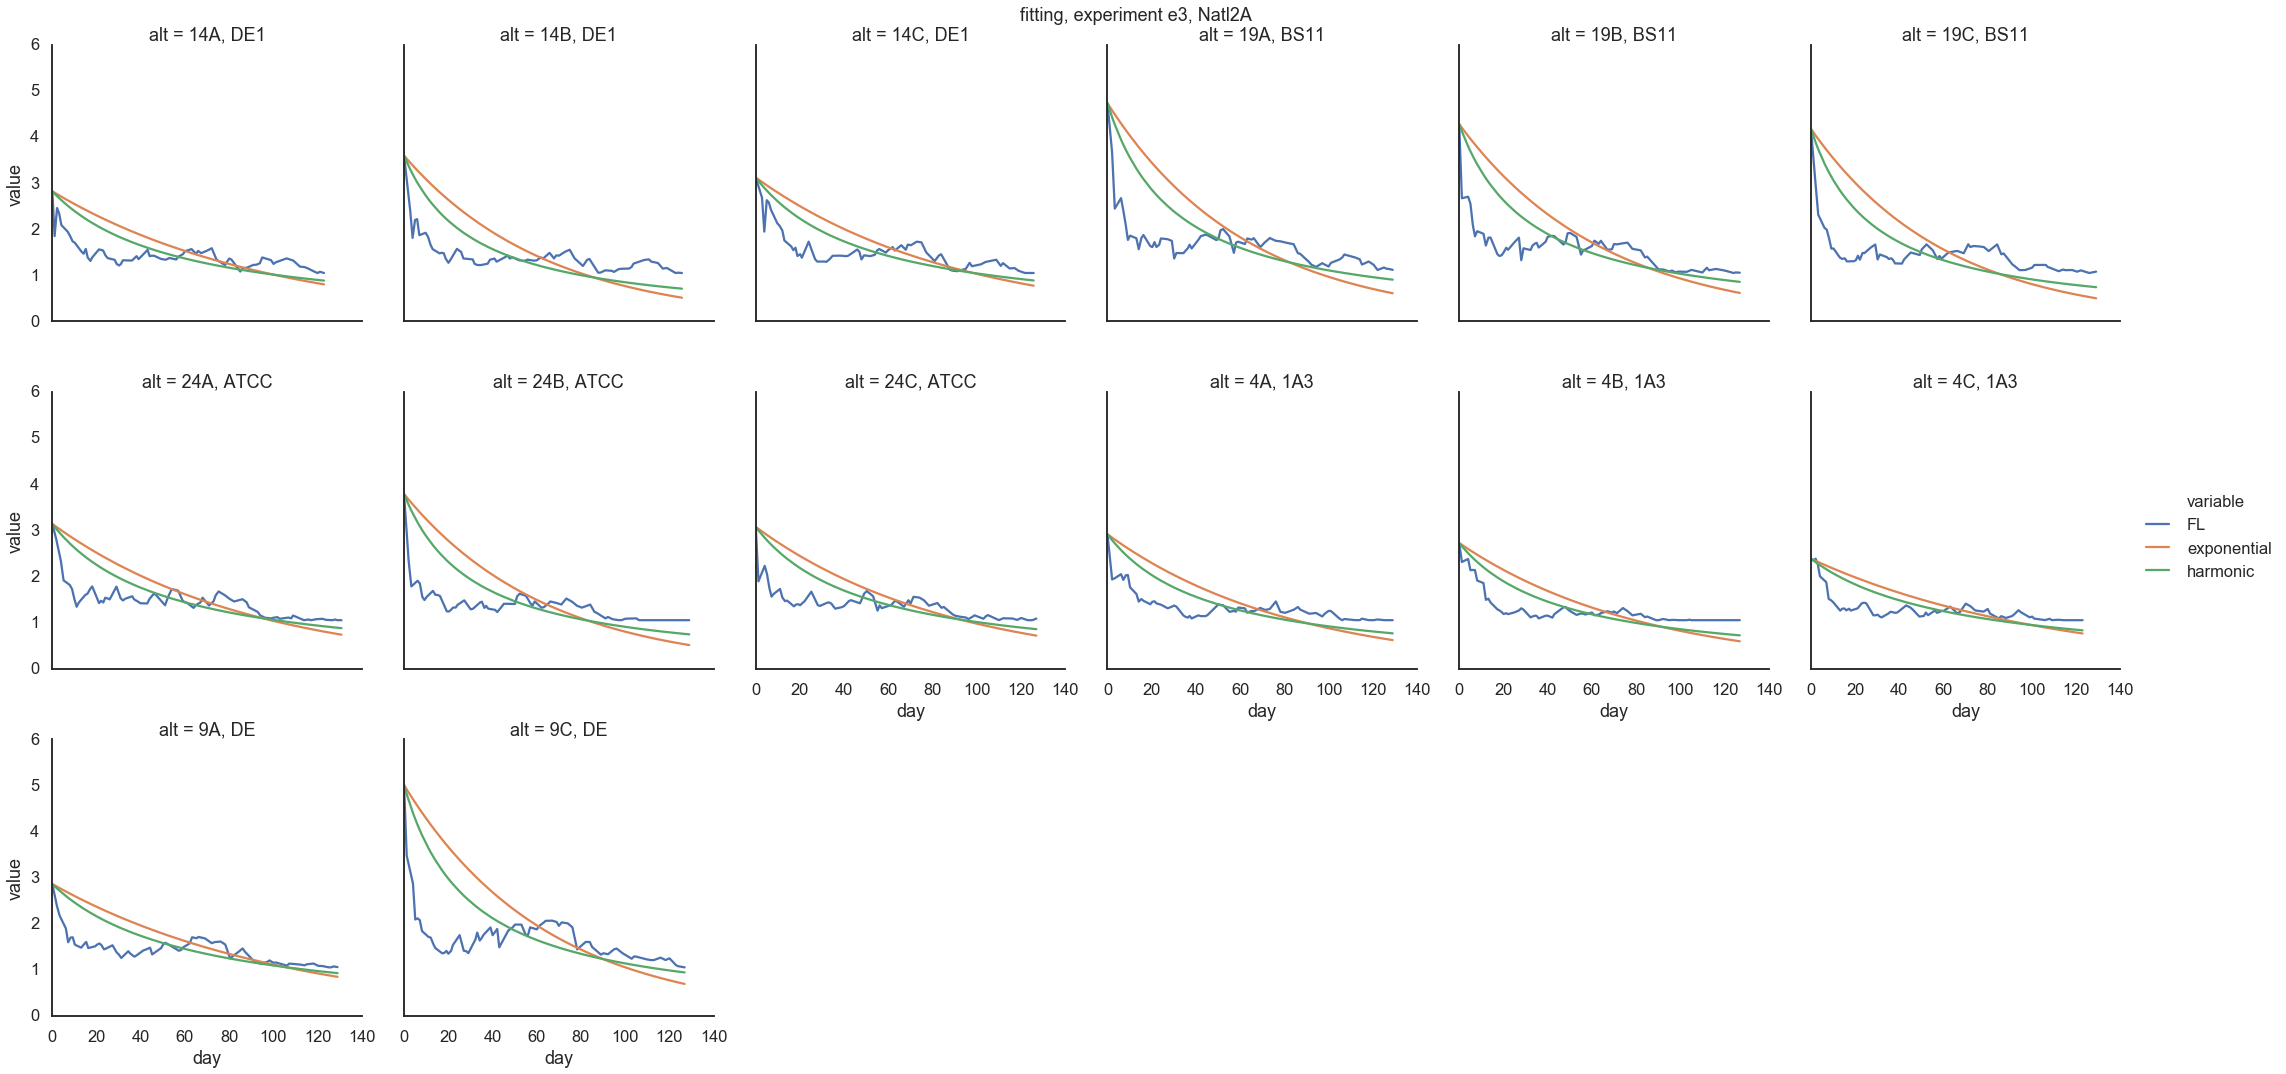

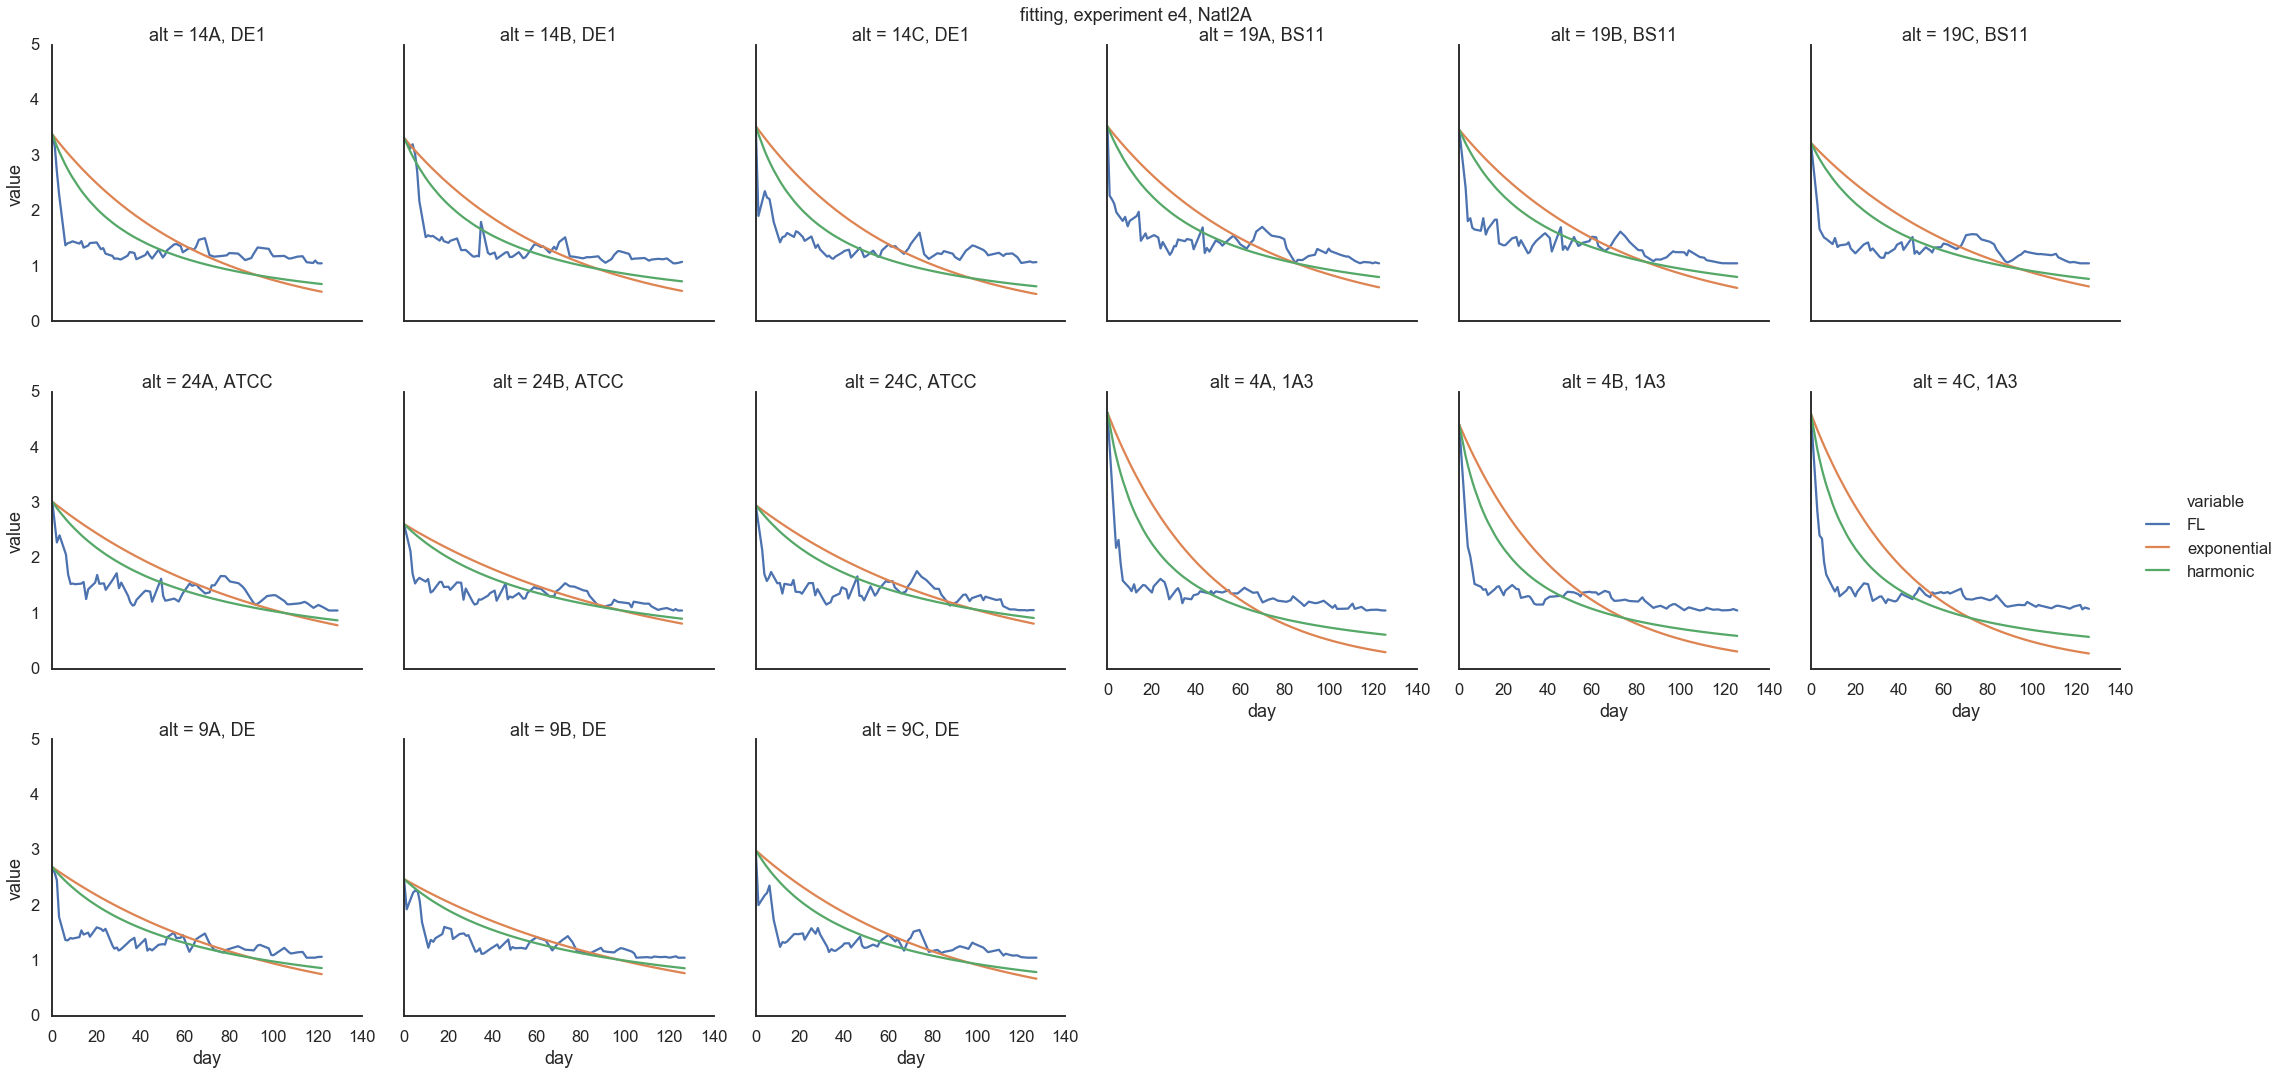

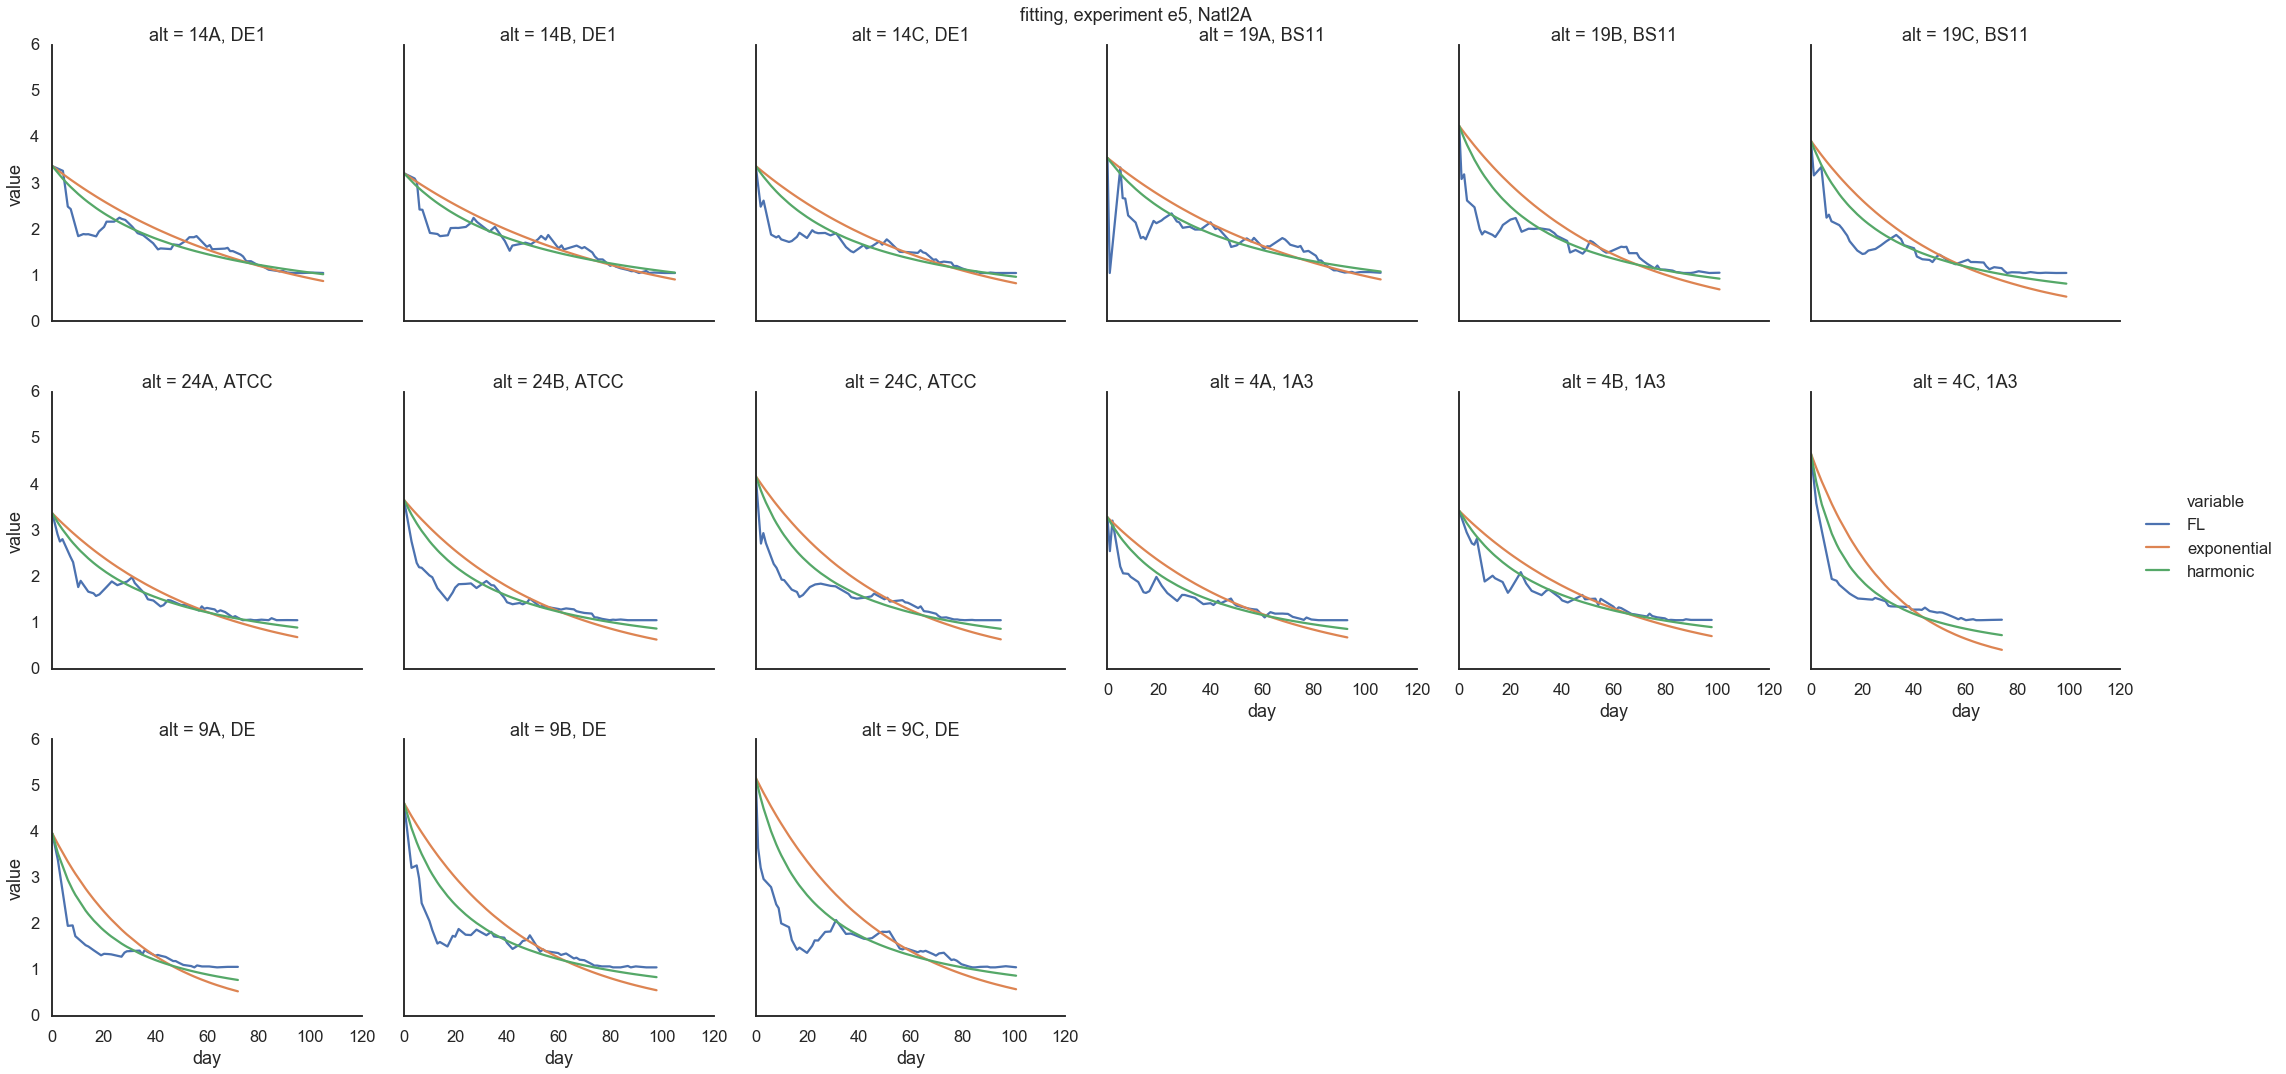

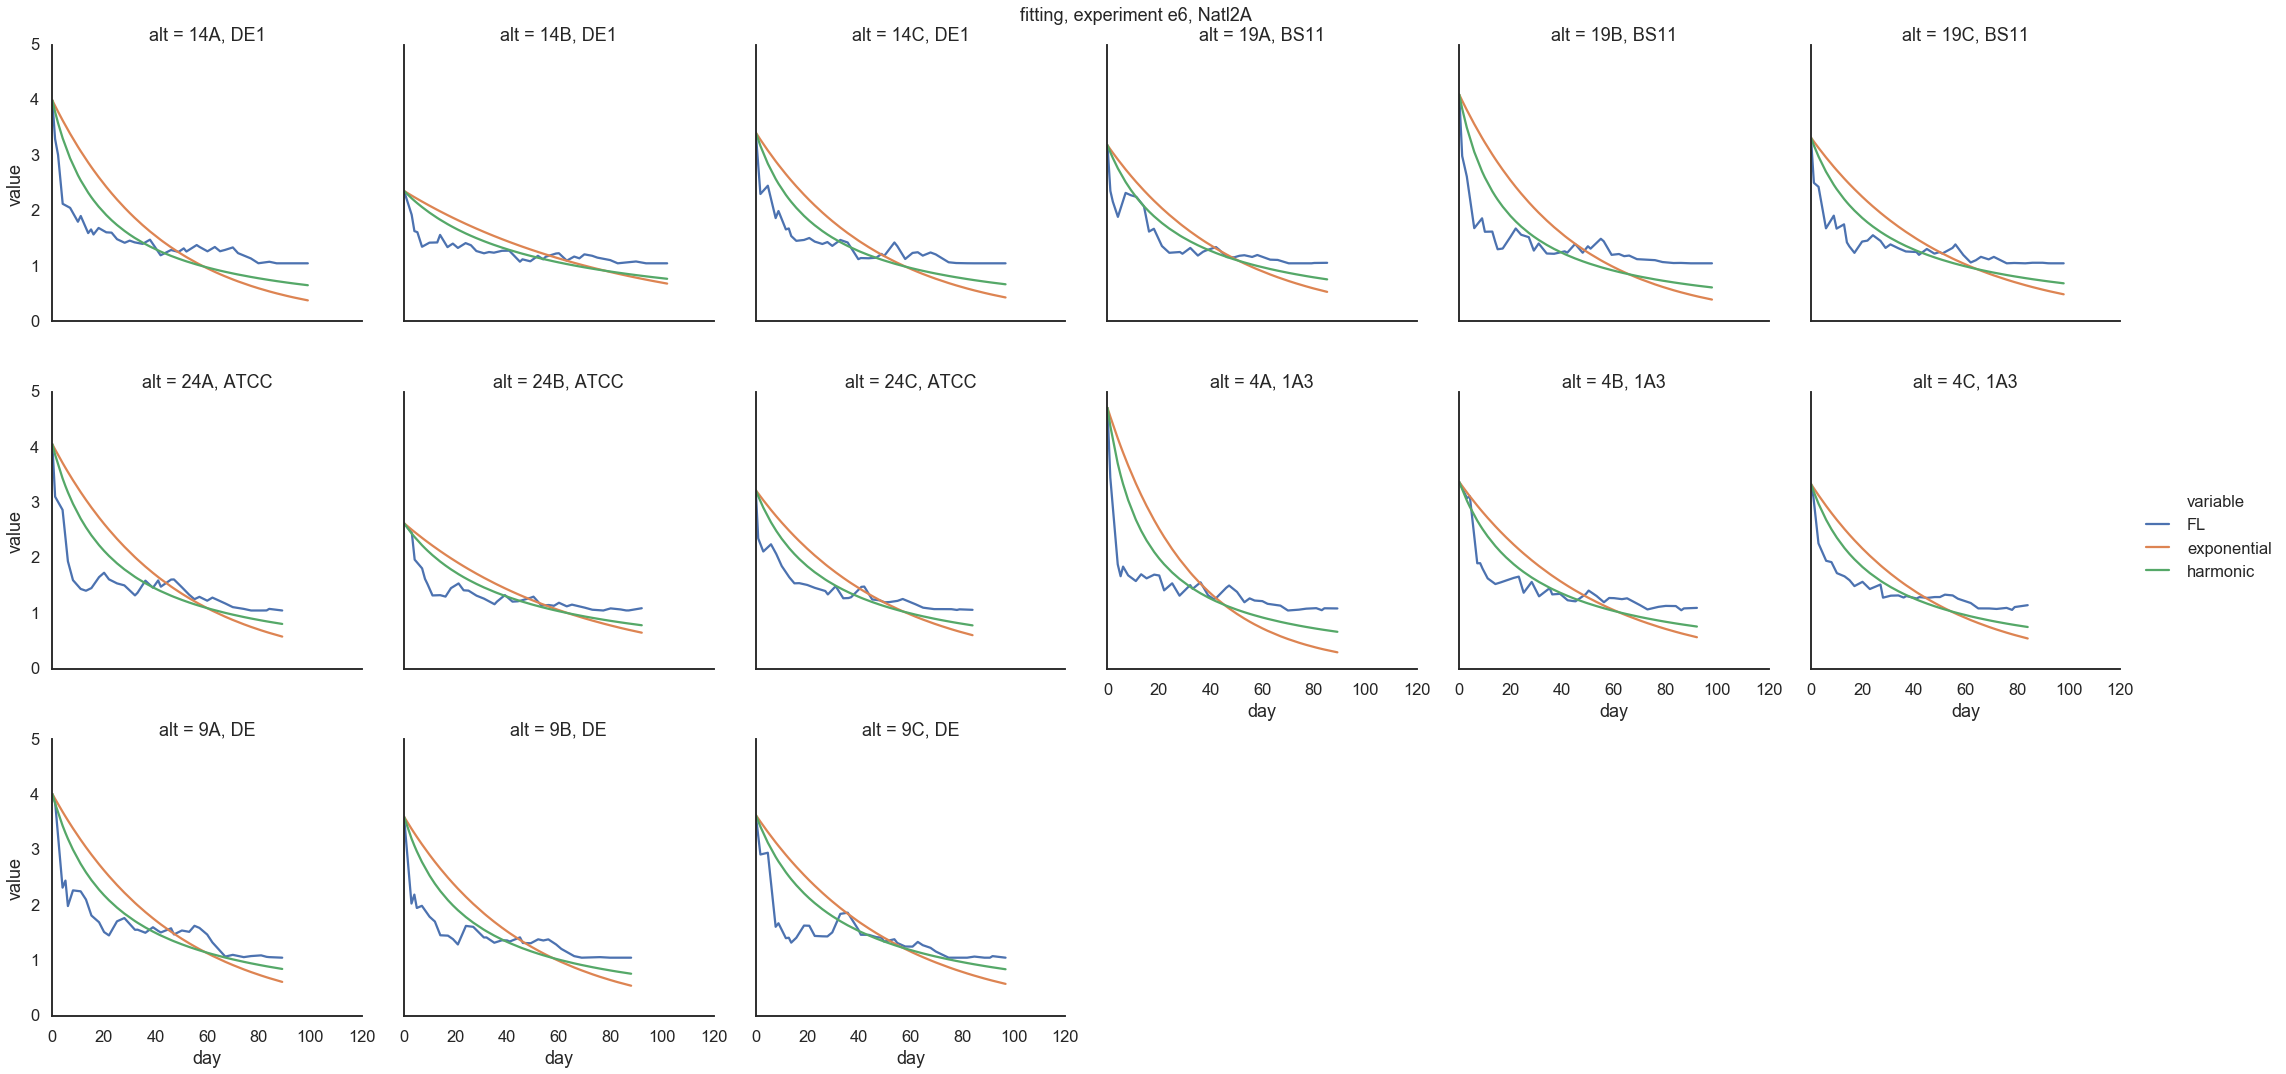

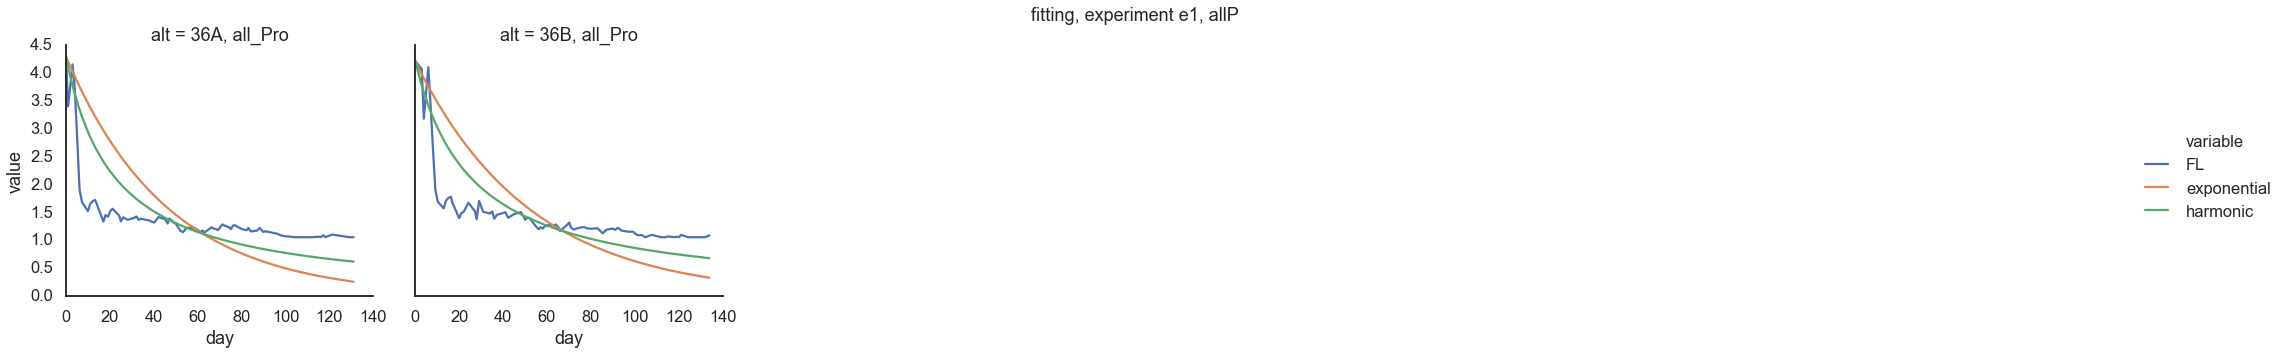

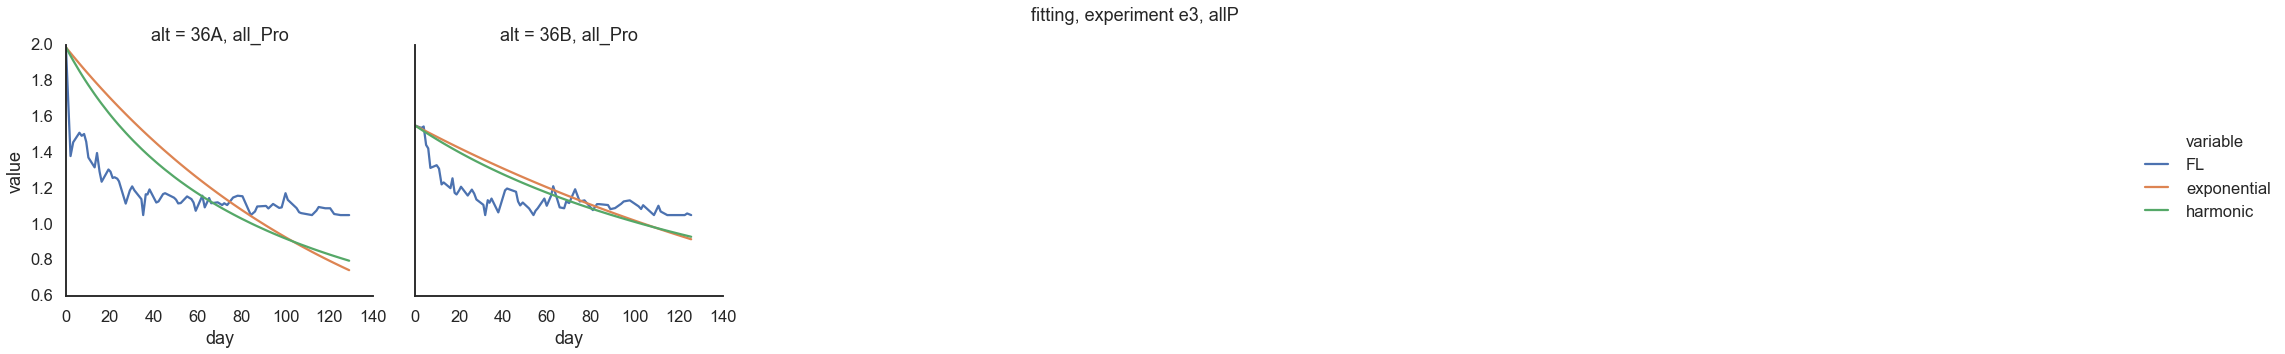

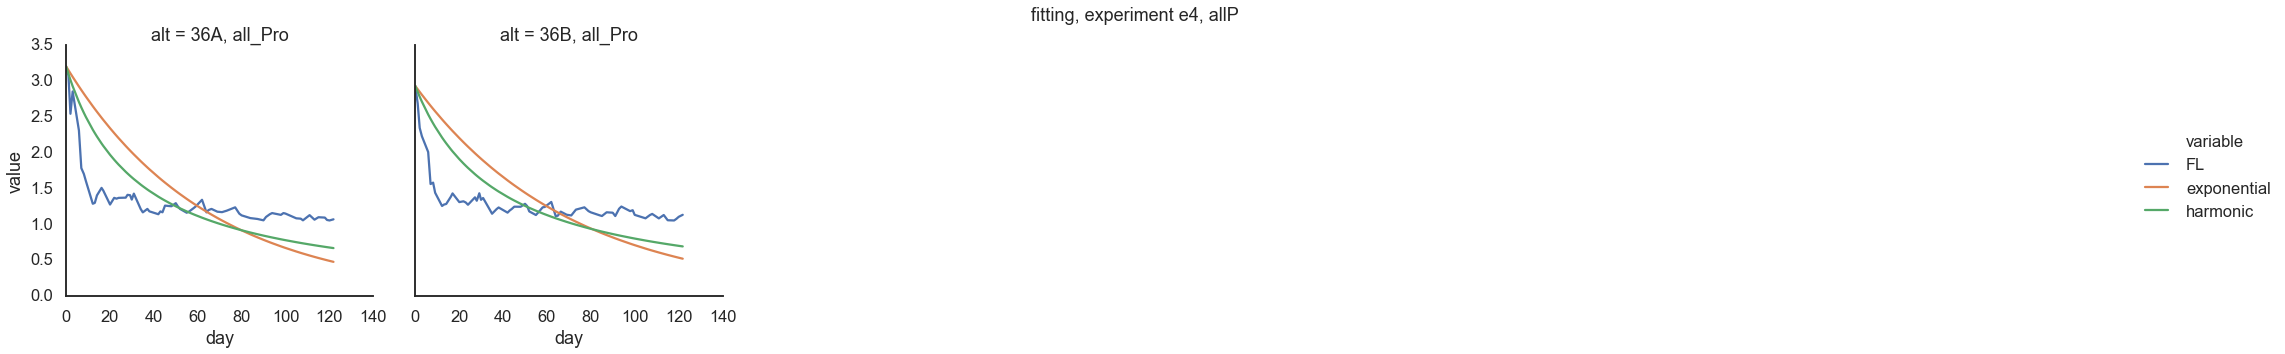

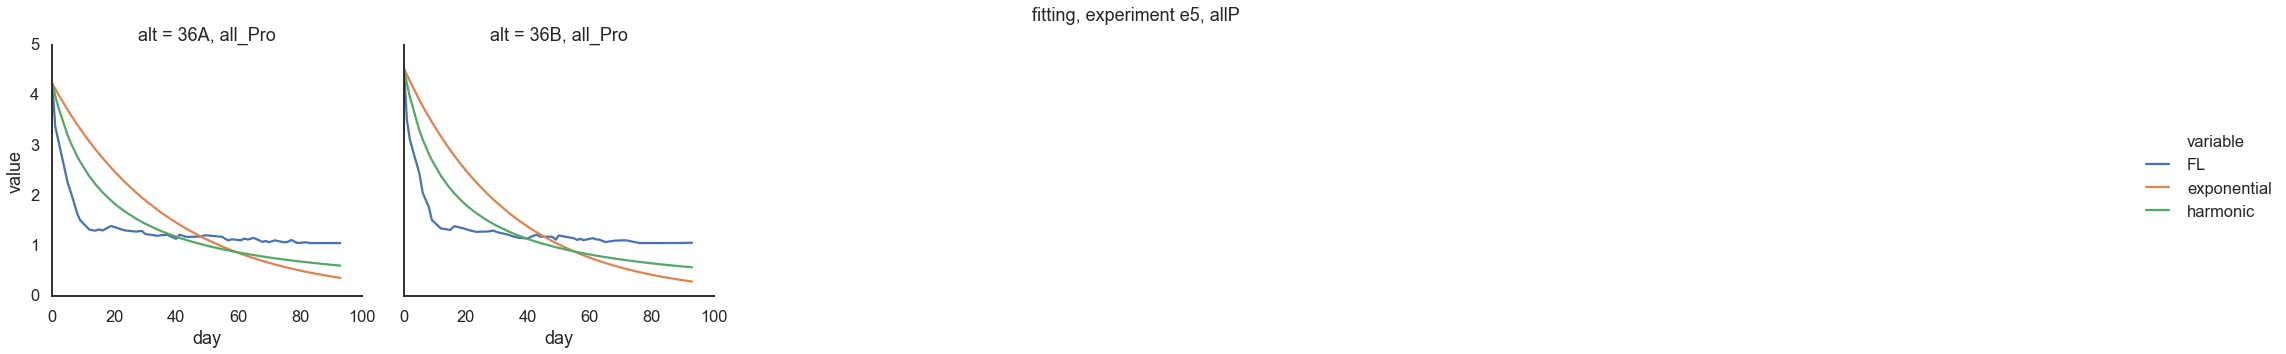

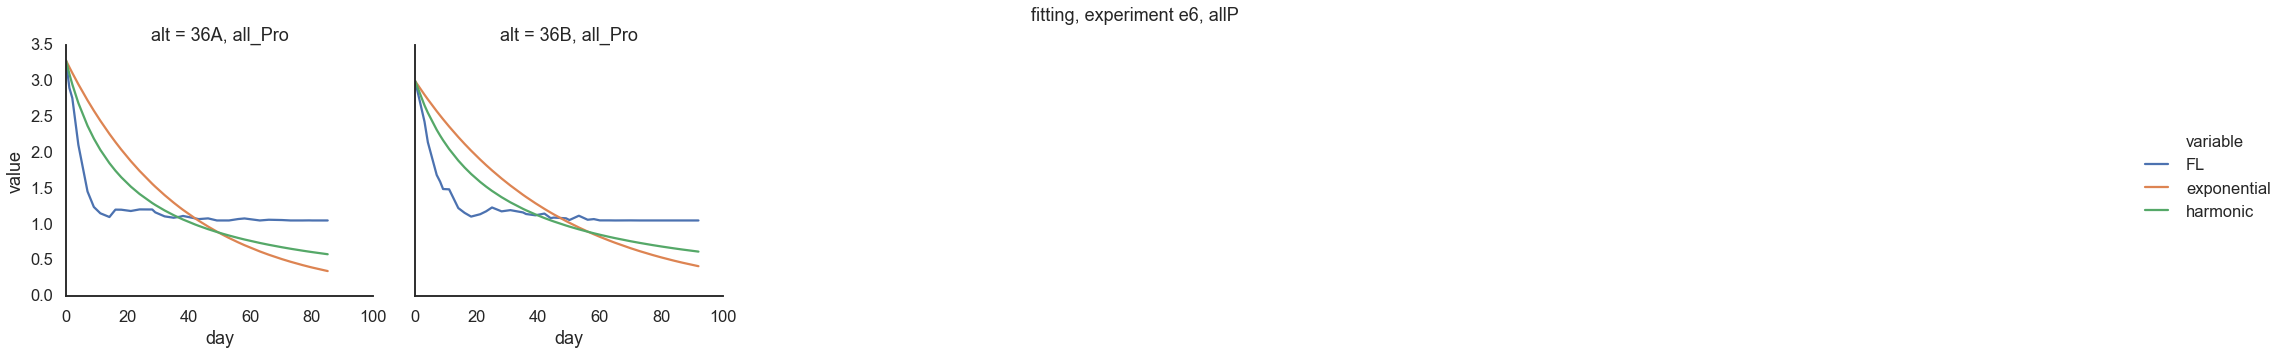

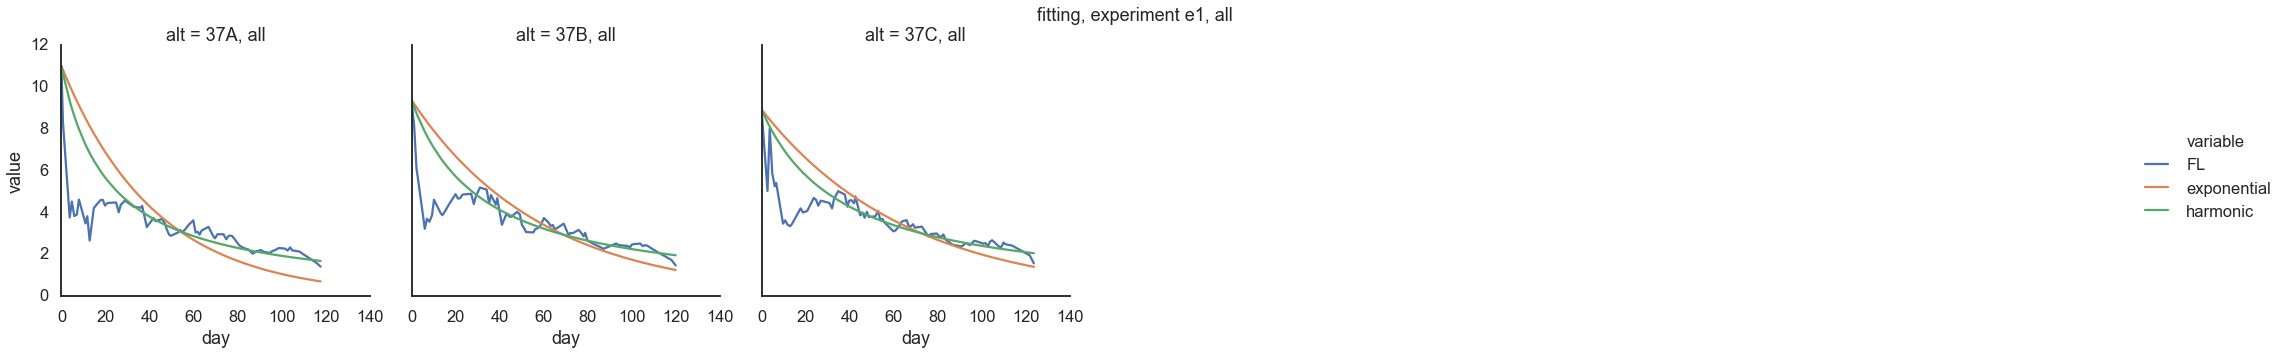

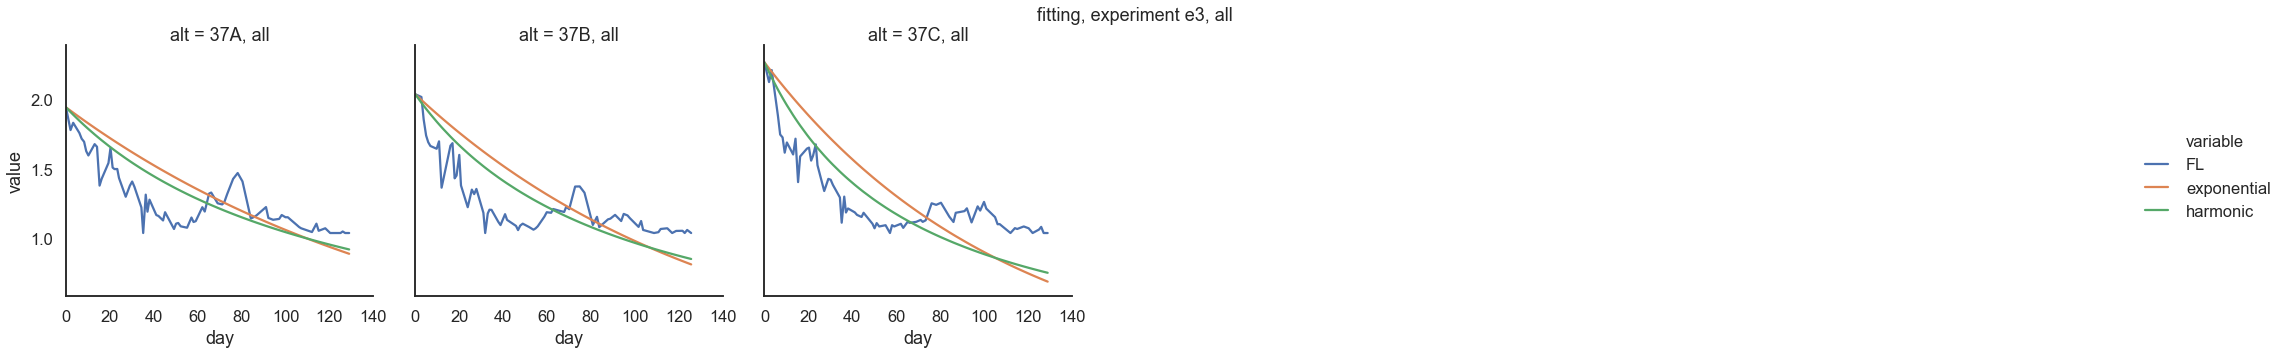

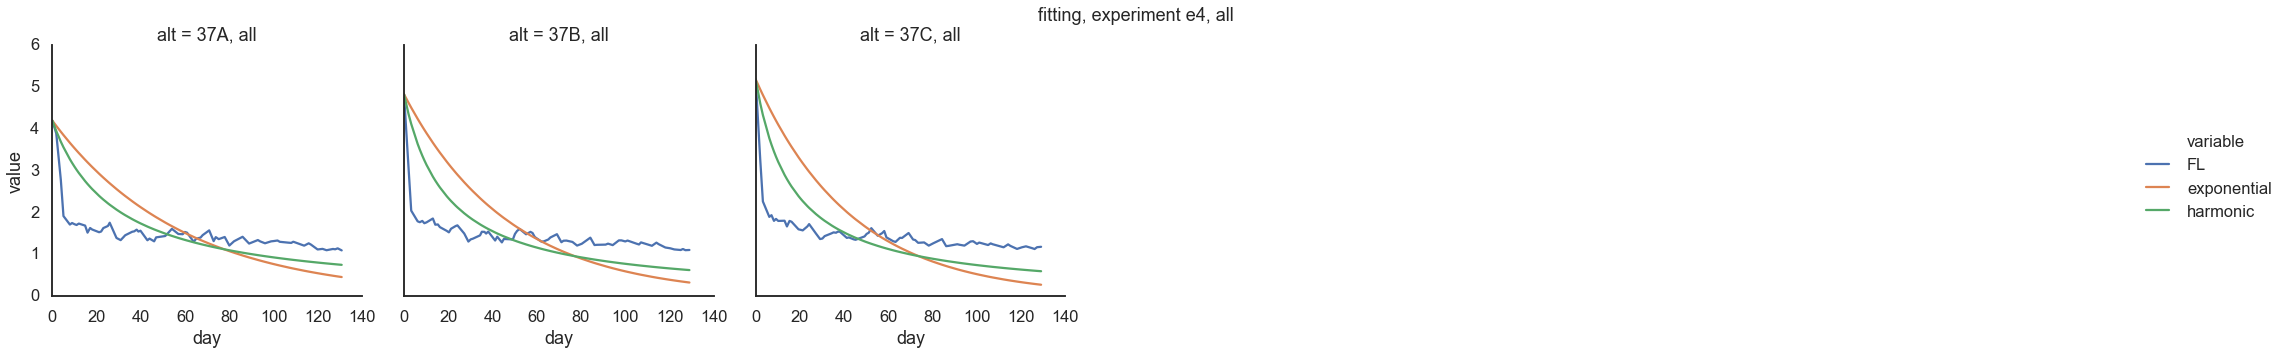

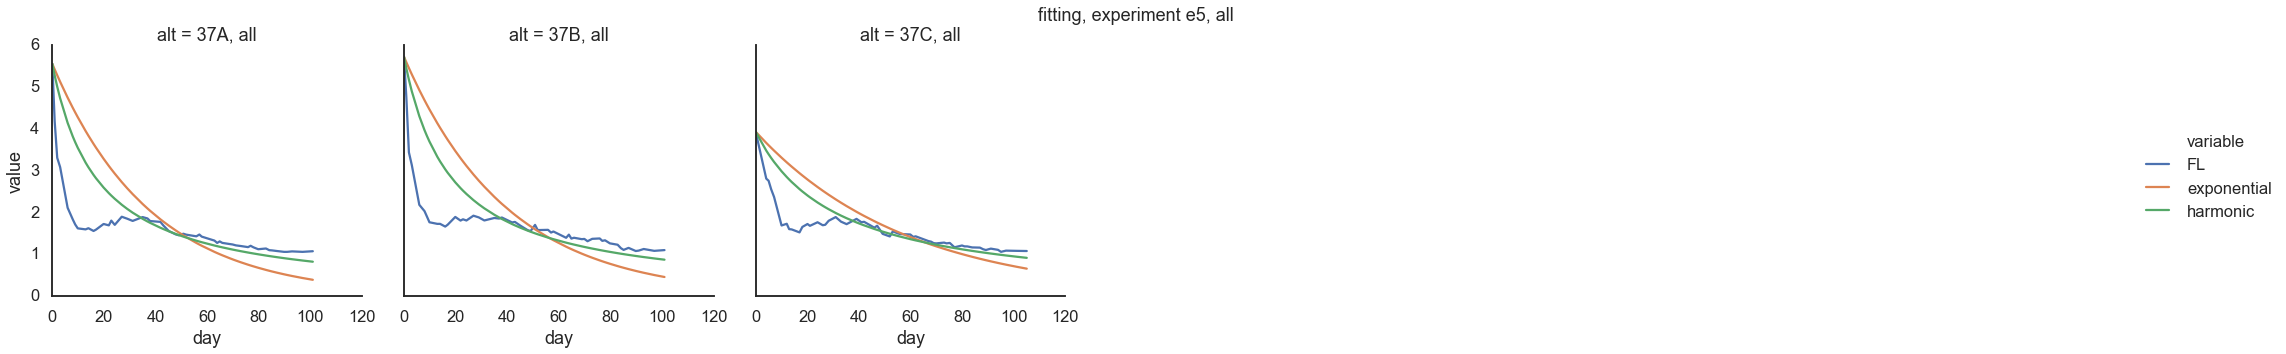

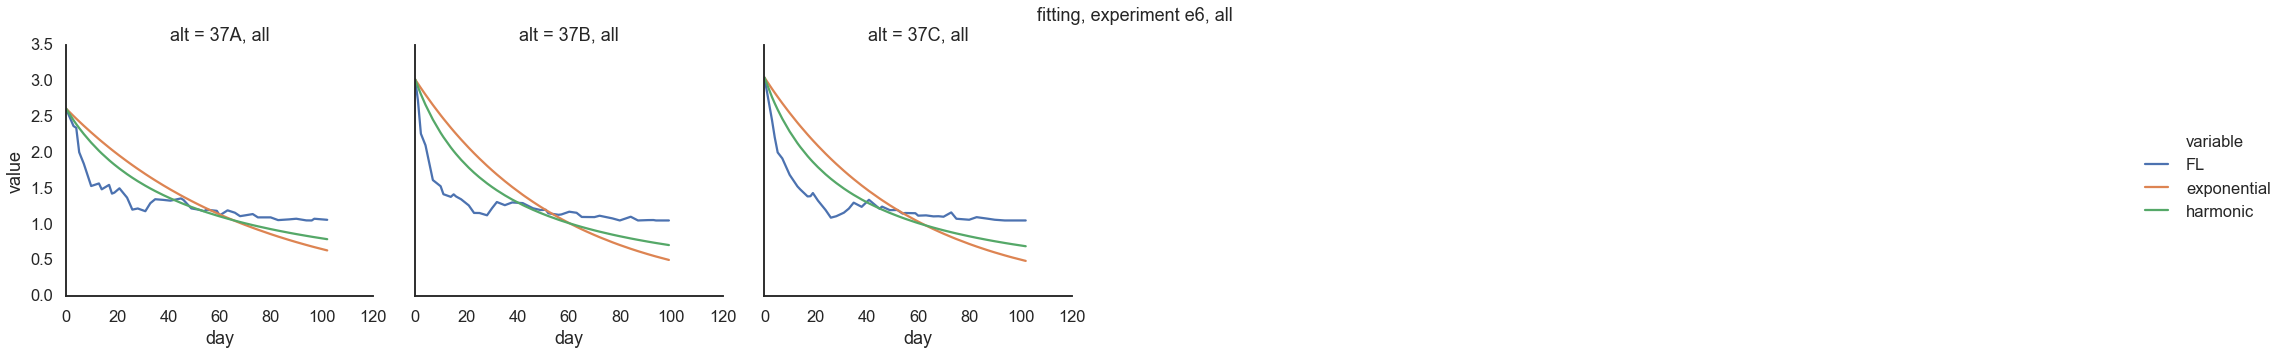

In [80]:
dfresm['alt'] = dfresm['sample'] +', '+dfresm['ALT']
for p in dfresm.PRO.unique():
    for e in dfresm.experiment.unique():
        sns.relplot(data=dfresm.loc[(dfresm.experiment == e) & (dfresm.PRO == p)], 
                x='day',
                y='value',
                hue='variable',
                col='alt',
                col_wrap=6,
                kind='line',
               )
        plt.suptitle(f'fitting, experiment {e}, {p}', y=1)
        plt.show()

In [81]:
sns.set_context('talk')
dfresm['a'] = dfresm['experiment_sample'] +', '+dfresm['PRO']+', '+dfresm['ALT']
#for p in dfresm.PRO.unique():
#    for e in dfresm.experiment.unique():
exponential_samples = best_model_df.loc[best_model_df.model == 'bic_exponential', 'experiment_sample']
sns.relplot(data=dfresm.loc[dfresm.experiment_sample.isin(exponential_samples) #& 
                           #(dfresm.experiment == 'e1')
                           ], 
                x='day',
                y='value',
                hue='variable',
                col='a',
                col_wrap=6,
                kind='line',
               )
plt.suptitle(f'exponential fit', y=1)
plt.show()

ValueError: num must be 1 <= num <= 0, not 1

<Figure size 2160x0 with 0 Axes>

In [ ]:
sns.set_context('talk')
dfresm['a'] = dfresm['experiment_sample'] +', '+dfresm['PRO']+', '+dfresm['ALT']
#for p in dfresm.PRO.unique():
exponential_samples = best_model_df.loc[best_model_df.model == 'bic_harmonic', 'experiment_sample']
for e in dfresm.experiment.unique():
    sns.relplot(data=dfresm.loc[dfresm.experiment_sample.isin(exponential_samples) & 
                               (dfresm.experiment == e)
                               ], 
                    x='day',
                    y='value',
                    hue='variable',
                    col='a',
                    col_wrap=6,
                    kind='line',
                   )
    plt.suptitle(f'harmonic fit {e}', y=1)
    plt.show()

In [ ]:
exponential_samples

In [ ]:
dfresm.columns

# Compare Models

In [ ]:
dfscore.loc[dfscore.culture.isin(['Axenic'])]